# Skane
# Bleking

![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [1]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [2]:
#Parameters
n=20
starting_week = 10-4 #start week
first_case = 9
T_max = 48 #length of prediction
pv = 0.023 #fraction of infected that are admitted
rho = 7*1/5.1 #latency period
gamma = 7*1/5 #recovery rate
delay = 3 #2.5 #delay from infection to admission

In [3]:
file = pd.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx', sheet_name = "Inskrivna i slutenvård")
data = [['Sthlm',           8, 2389923, 'SE-AB',  6524],
        ['VGR',             9, 1725881,  'SE-O', 23800],
        ['Skåne',          10, 1387650,  'SE-M', 10968],
        ['Östergötland',   11,  467095,  'SE-E', 10559],
        ['Jönköping',      12,  364750,  'SE-F',  8190],
        ['Södermanland',   13,  299101,  'SE-D', 10437],
        ['Uppsala',        14,  387628,  'SE-C',  5427],
        ['Gävleborg',      15,  287660,  'SE-X',  8504],
        ['Västmanland',    16,  277074,  'SE-U',  6075],
        ['Örebro',         17,  305726,  'SE-T', 28029],
        ['Norrbotten',     18,  249768, 'SE-BD', 18118],
        ['Dalarna',        19,  287806,  'SE-W', 17519],
        ['Västernorrland', 20,  244855,  'SE-Y',  5118],
        ['Värmland',       21,  282840,  'SE-S', 54665],
        ['Halland',        22,  336132,  'SE-N', 97239],
        ['Kalmar',         23,  245992,  'SE-H', 11165],
        ['Kronoberg',      24,  202163,  'SE-G', 21549],
        ['Västerbotten',   25,  273061,  'SE-AC', 8424],
        ['Jämtland',       26,  130972,  'SE-Z',  2931],
        ['Blekinge',       27,  159349,  'SE-K', 48935],
        ['Gotland',        28,   60106,  'SE-I',  3135]] 
regions = pd.DataFrame(data, columns = ['region', 'index','population', 'regionkod', 'area']) 
regions['density'] = regions['population']/regions['area']
first_cases = first_case*np.ones(21).astype(int) #week number when first case was recorded
regions['first case'] = first_cases
starting_weeks = first_cases - 3

regions.drop(regions.index[[20]],inplace=True) #remove Gotland


In [4]:
def getData(name, first_case):
    temp = regions.loc[regions['region'] == name] #find the right row
    index = temp['index'].values #find the region index
    N = temp['population'].values[0] #find population size of region
    R = file.iloc[index[0]] 
    R = R.replace(' ', 0) #replace missing data with 0
    R = R.replace('X', 0) 
    R = R.replace('IU', 0) 
    
    ind = np.arange(3, len(R), 2) 
    I = R.iloc[ind].values #extract admissions
    I = I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10 - first_case + 3) 
    I = np.insert(I, 0, padding) 
    veckor = np.arange(0, len(I), 1) #create array of week numbers
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(name, starting_week):
    df = pd.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp = regions.loc[regions['region'] == name] 
    code = temp['regionkod'].values 
    temp2 = df.loc[df['iso_3166_2_code'] == code[0]]
    transit = temp2['transit_stations_percent_change_from_baseline'].values 
    dagar = np.arange(46, 46 + len(transit))
    tv = np.ceil(dagar / 7)
    
    
    gveckor = np.unique(tv)
    k = 0
    Tr = np.zeros(int(max(gveckor) - min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-starting_week, Tr, kind = "linear", fill_value = "extrapolate")
    #print(Tr)
    return Trfkn

In [5]:
def loadMobility_list(name_list, starting_week):
    Trfkn_dict = dict()
    for i in name_list:
       Trfkn_dict[i] = loadMobility(i, starting_week) 
    return Trfkn_dict


def getData_list(name_list, first_case):
    getData_dict = dict()
    for i in name_list:
        I, veckor, N = getData(i, first_case)
        getData_dict[i] =  {'I': I, 'veckor': veckor, 'N': N}
    return getData_dict

# 2. Correlation Analysis

In [6]:
name_list = regions.region.tolist()
Trfkn_dict = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 

In [7]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict[region_name[0]]['I'])/regions[regions.region == region_name[0]].density.values

for j in getData_dict.keys():
    if j == region_name[0]:
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regions[regions.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [8]:
df.columns = region_name
df.head()

Sthlm       VGR Skåne Östergötland Jönköping Södermanland   Uppsala  \
0       0.0       0.0   0.0          0.0       0.0          0.0       0.0   
1       0.0       0.0   0.0          0.0       0.0          0.0       0.0   
2       0.0       0.0   0.0          0.0       0.0          0.0       0.0   
3       0.0       0.0   0.0          0.0       0.0          0.0       0.0   
4  0.101002  0.124111   0.0          0.0       0.0          0.0  0.056002   

  Gävleborg Västmanland Örebro Norrbotten Dalarna Västernorrland Värmland  \
0       0.0         0.0    0.0        0.0     0.0            0.0      0.0   
1       0.0         0.0    0.0        0.0     0.0            0.0      0.0   
2       0.0         0.0    0.0        0.0     0.0            0.0      0.0   
3       0.0         0.0    0.0        0.0     0.0            0.0      0.0   
4       0.0         0.0    0.0        0.0     0.0            0.0      0.0   

  Halland Kalmar Kronoberg Västerbotten Jämtland Blekinge  
0     0.0    0.0       0.0          0.0      0.0      0.0  
1     0.0    0.0       0.0          0.0      0.0      0.0  
2     0.0    0.0       0.0          0.0      0.0      0.0  
3     0.0    0.0       0.0          0.0      0.0      0.0  
4     0.0    0.0       0.0          0.0      0.0      0.0

In [9]:
df.corr()

Sthlm       VGR     Skåne  Östergötland  Jönköping  \
Sthlm           1.000000  0.843206  0.707943      0.968330   0.911792   
VGR             0.843206  1.000000  0.887548      0.728929   0.583918   
Skåne           0.707943  0.887548  1.000000      0.621677   0.400992   
Östergötland    0.968330  0.728929  0.621677      1.000000   0.949446   
Jönköping       0.911792  0.583918  0.400992      0.949446   1.000000   
Södermanland    0.912002  0.913086  0.826470      0.843867   0.742007   
Uppsala         0.906437  0.903484  0.836551      0.836592   0.728714   
Gävleborg       0.851443  0.892073  0.770706      0.758317   0.634586   
Västmanland     0.919852  0.902264  0.844795      0.858380   0.728252   
Örebro          0.608364  0.570380  0.357385      0.558964   0.546562   
Norrbotten      0.916373  0.880070  0.694584      0.861616   0.769218   
Dalarna         0.942713  0.705631  0.537343      0.937252   0.934666   
Västernorrland  0.767337  0.886026  0.825453      0.634197   0.496379   
Värmland        0.609362  0.854733  0.701450      0.456047   0.328326   
Halland         0.797345  0.793608  0.634010      0.695051   0.611534   
Kalmar          0.845498  0.925145  0.837116      0.749121   0.626122   
Kronoberg       0.634756  0.855745  0.895035      0.519094   0.309441   
Västerbotten    0.777421  0.805349  0.708041      0.666688   0.592080   
Jämtland        0.834126  0.664991  0.714445      0.848179   0.726492   
Blekinge        0.277613  0.540573  0.703238      0.214819   0.029500   

                Södermanland   Uppsala  Gävleborg  Västmanland    Örebro  \
Sthlm               0.912002  0.906437   0.851443     0.919852  0.608364   
VGR                 0.913086  0.903484   0.892073     0.902264  0.570380   
Skåne               0.826470  0.836551   0.770706     0.844795  0.357385   
Östergötland        0.843867  0.836592   0.758317     0.858380  0.558964   
Jönköping           0.742007  0.728714   0.634586     0.728252  0.546562   
Södermanland        1.000000  0.935397   0.890879     0.919812  0.666803   
Uppsala             0.935397  1.000000   0.834167     0.951433  0.563244   
Gävleborg           0.890879  0.834167   1.000000     0.888467  0.611241   
Västmanland         0.919812  0.951433   0.888467     1.000000  0.591124   
Örebro              0.666803  0.563244   0.611241     0.591124  1.000000   
Norrbotten          0.861836  0.822067   0.894599     0.874052  0.661141   
Dalarna             0.819782  0.805795   0.780226     0.816632  0.610308   
Västernorrland      0.839591  0.879517   0.822392     0.876964  0.579358   
Värmland            0.734929  0.724591   0.799760     0.703475  0.611706   
Halland             0.810330  0.791194   0.880823     0.832255  0.725711   
Kalmar              0.888893  0.910907   0.863245     0.882670  0.523089   
Kronoberg           0.747598  0.725122   0.827918     0.768168  0.391109   
Västerbotten        0.818094  0.833061   0.790691     0.795805  0.514327   
Jämtland            0.757545  0.812731   0.698229     0.850684  0.427815   
Blekinge            0.496441  0.496166   0.388709     0.471452  0.262842   

                Norrbotten   Dalarna  Västernorrland  Värmland   Halland  \
Sthlm             0.916373  0.942713        0.767337  0.609362  0.797345   
VGR               0.880070  0.705631        0.886026  0.854733  0.793608   
Skåne             0.694584  0.537343        0.825453  0.701450  0.634010   
Östergötland      0.861616  0.937252        0.634197  0.456047  0.695051   
Jönköping         0.769218  0.934666        0.496379  0.328326  0.611534   
Södermanland      0.861836  0.819782        0.839591  0.734929  0.810330   
Uppsala           0.822067  0.805795        0.879517  0.724591  0.791194   
Gävleborg         0.894599  0.780226        0.822392  0.799760  0.880823   
Västmanland       0.874052  0.816632        0.876964  0.703475  0.832255   
Örebro            0.661141  0.610308        0.579358  0.611706  0.725711   
Norrbotten        1.000000  0.853454        0.745972

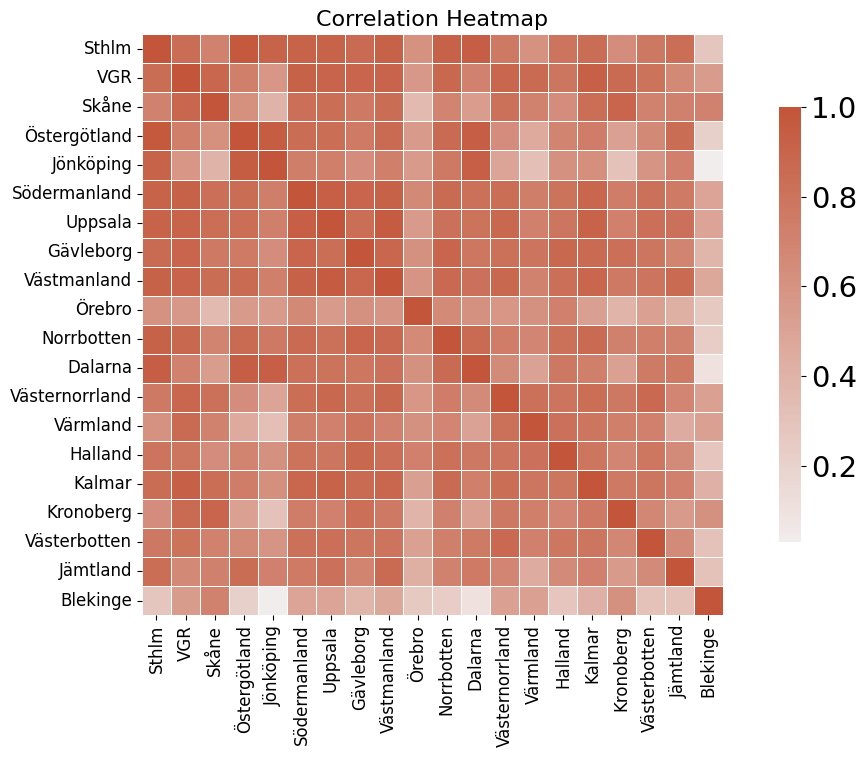

In [10]:
import seaborn as sns


corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
           # show correlation coefficients
    fmt=".2f",        # format for annotations
    linewidths=0.5,   # space between cells
    square=True,      # keep the cells square
    cbar_kws={"shrink": 0.75},  # color bar size
    center=0   ,
    annot_kws={"size": 8}       # center the colormap at zero
)

# Add title and tweak layout
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../data/correlation_heatmap.svg", format="svg")

# Display the plot
plt.show()

In [11]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

Sthlm
Sthlm           1.000000
Östergötland    0.968330
Dalarna         0.942713
Västmanland     0.919852
Norrbotten      0.916373
Södermanland    0.912002
Jönköping       0.911792
Uppsala         0.906437
Gävleborg       0.851443
Kalmar          0.845498
VGR             0.843206
Jämtland        0.834126
Halland         0.797345
Västerbotten    0.777421
Västernorrland  0.767337
Skåne           0.707943
Kronoberg       0.634756
Värmland        0.609362
Örebro          0.608364
Blekinge        0.277613

In [12]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

Skåne
Skåne           1.000000
Kronoberg       0.895035
VGR             0.887548
Västmanland     0.844795
Kalmar          0.837116
Uppsala         0.836551
Södermanland    0.826470
Västernorrland  0.825453
Gävleborg       0.770706
Jämtland        0.714445
Västerbotten    0.708041
Sthlm           0.707943
Blekinge        0.703238
Värmland        0.701450
Norrbotten      0.694584
Halland         0.634010
Östergötland    0.621677
Dalarna         0.537343
Jönköping       0.400992
Örebro          0.357385

In [13]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

Uppsala
Uppsala         1.000000
Västmanland     0.951433
Södermanland    0.935397
Kalmar          0.910907
Sthlm           0.906437
VGR             0.903484
Västernorrland  0.879517
Östergötland    0.836592
Skåne           0.836551
Gävleborg       0.834167
Västerbotten    0.833061
Norrbotten      0.822067
Jämtland        0.812731
Dalarna         0.805795
Halland         0.791194
Jönköping       0.728714
Kronoberg       0.725122
Värmland        0.724591
Örebro          0.563244
Blekinge        0.496166

# 3. Modeling

#### S[Sthlm]=x0      

#### E[Sthlm]=x1       

#### I[Sthlm]=x2       

#### R[Sthlm]=x3

#### S[Södermanland]=x4      

#### E[Södermanland]=x5       

#### I[Södermanland]=x6       

#### R[Södermanland]=x7

In [39]:
name_list = ['Kalmar', 'Blekinge']
transit_fkn_dct = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 
region_0 = name_list[0]
region_1 = name_list[1]
I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[region_0]['veckor'] 

def beta(t, a, b, transit_fkn):
    return a + b * transit_fkn(t)

def dx(x, t, N, a, b, c, lag):
    S0, E0, I0, R0, S1, E1, I1, R1 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

    dS0 =  - S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1])
    dS1 =  - S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0])
    dE0 =    S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1]) - rho*E0
    dE1 =    S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0]) - rho*E1
    dI0 =  rho*E0 - gamma*I0
    dI1 =  rho*E1 - gamma*I1
    dR0 =  gamma*I0
    dR1 =  gamma*I1

    return [dS0, dE0, dI0, dR0,
            dS1, dE1, dI1, dR1]

def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]

In [40]:
getData_dict

{'Kalmar': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 9, 10, 20, 24, 26, 28, 35, 26, 22, 7, 15,
         12, 20, 19, 7, 8, 7, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 4,
         8, 15, 23, 24, 24, 33, 25], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 245992},
 'Blekinge': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 4, 5, 10, 6, 17, 8,
         13, 0, 5, 0, 4, 0, 5, 0, 6, 5, 0, 0, 0, 0, 4, 7, 4, 0, 4, 7, 7, 12,
         9, 9, 13, 29], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 159349}}

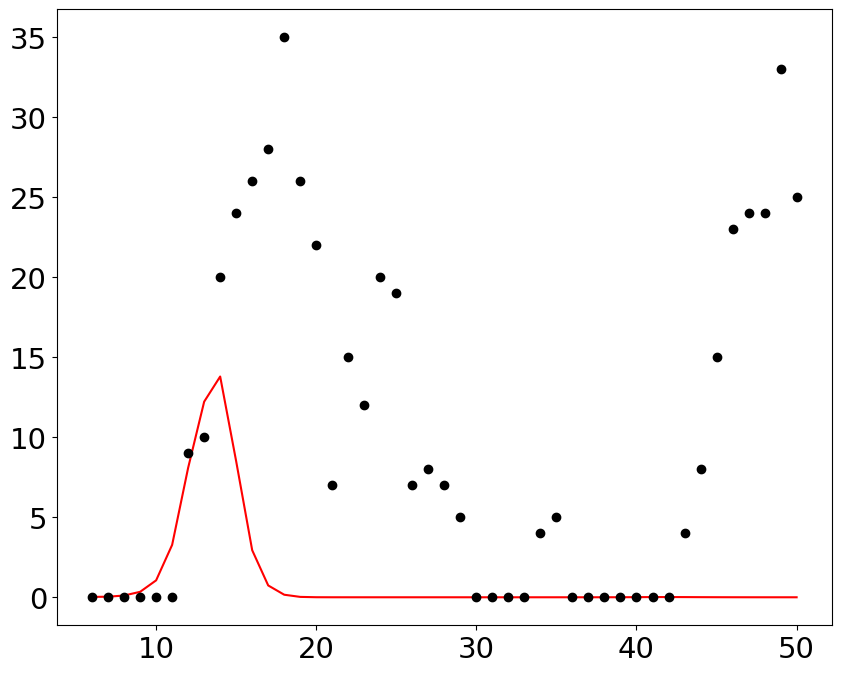

In [43]:
a = [2.380262, 1.729996 ] 
b = [11.197420, 1.387774] 
c = 0
P = pred_inlagda(weeks_train, a[0], b[0], a[1], b[1], c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")


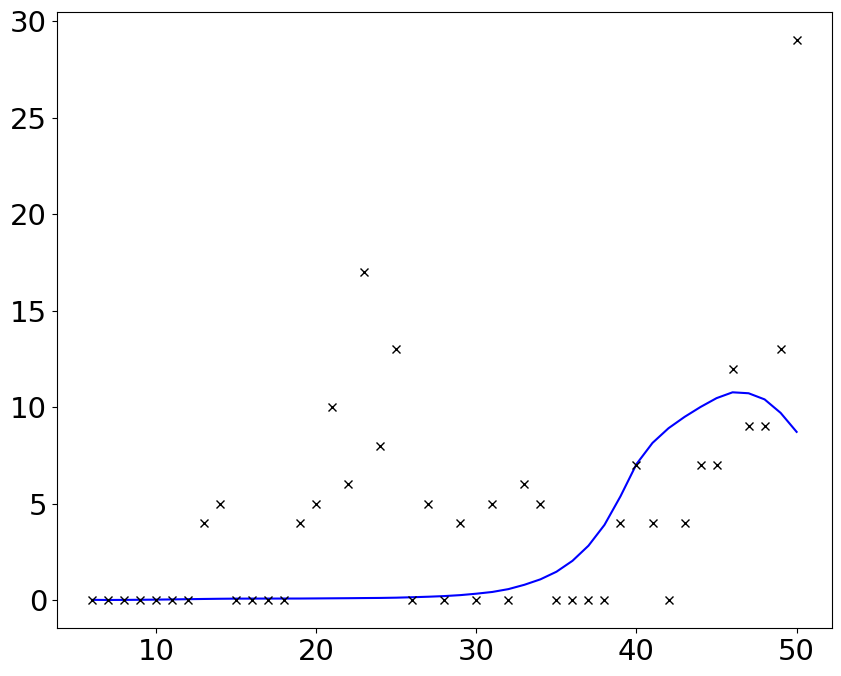

In [44]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")

In [45]:
def return_RMSE(P, I):
    return np.sqrt(np.mean((P - I)**2))

def return_CV_RMSE(P, I):
    return 100 * return_RMSE(P, I) / np.mean(I)

In [46]:
print(return_RMSE(P[:,0], I_train[0]))
print(return_RMSE(P[:,1], I_train[1]))
print(return_CV_RMSE(P[:,0], I_train[0]))
print(return_CV_RMSE(P[:,1], I_train[1]))

14.181747239381641
5.643517502542591
137.24271521982232
125.72192456159236


In [47]:
#!pip install wandb


In [57]:
from tqdm import tqdm

name_list = ['Kalmar', 'Blekinge']
transit_fkn_dict = loadMobility_list(name_list, starting_week) 
getData_dict = getData_list(name_list, first_case)

I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[name_list[0]]['veckor']  # getData_dict['Södermanland']['veckor'] == getData_dict['Sthlm']['veckor']

n=3
ah0 = np.linspace(3,10,n)
bh0 = np.linspace(4,10,n)
ah1 = np.linspace(3,10,n)
bh1 = np.linspace(4,10,n)
c = np.linspace(0,0.2,n)

E_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            for l in range(n): 
                for m in range(n):
                    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
                    
                    # Store the results in the arrays (instead of RMSE)
                    E_rmse0[i,j,k,l,m] = return_RMSE(P[:,0], I_train[0])
                    E_rmse1[i,j,k,l,m] = return_RMSE(P[:,1], I_train[1])  

                    # Store the results in the arrays (instead of cv-rms)
                    E_cv_rmse0[i, j, k, l, m] = return_CV_RMSE(P[:,0], I_train[0]) 
                    E_cv_rmse1[i, j, k, l, m] = return_CV_RMSE(P[:,1], I_train[1])

                                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.51s/it]


In [62]:
sweep_config = {
    'method': 'random'
    }

In [63]:
metric = {
    'name': 'CV_RMSE',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [64]:
parameters_dict = {
    "ah0": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    },
    "bh0": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "ah1": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    },
    "bh1": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "c": {
        "min": 0,
        "max": 1,
        "distribution": "uniform"
    }
}

sweep_config['parameters'] = parameters_dict


In [65]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'CV_RMSE'},
 'parameters': {'ah0': {'distribution': 'uniform', 'max': 3, 'min': 0},
                'ah1': {'distribution': 'uniform', 'max': 3, 'min': 0},
                'bh0': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'bh1': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'c': {'distribution': 'uniform', 'max': 1, 'min': 0}}}


In [66]:
import wandb


In [67]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-SEIR_kalmar_bleking")

Create sweep with ID: za0efz19
Sweep URL: https://wandb.ai/danish2562022/sweeps-SEIR_kalmar_bleking/sweeps/za0efz19


In [68]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms


def fit_model(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        P = pred_inlagda(weeks_train, config.ah0, config.bh0, config.ah1, config.bh1, config.c, delay)
        CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
        CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
        CV_RMSE = CV_RMSE_1 + CV_RMSE_2
        RMSE_1 = return_RMSE(P[:,0], I_train[0])
        RMSE_2 = return_RMSE(P[:,1], I_train[1])
        RMSE = RMSE_1 + RMSE_2
        wandb.log({"CV_RMSE": CV_RMSE, "RMSE": RMSE,  "RMSE_Kalmar": RMSE_1,  "RMSE_Blekinge": RMSE_2,  "CV_RMSE_'Kalmar": CV_RMSE_1,  "CV_RMSE_Blekinge": CV_RMSE_2})  

In [ ]:
wandb.agent(sweep_id,fit_model, count=10000)

wandb: Agent Starting Run: cr63j65u with config:
wandb: 	ah0: 2.9506801813249015
wandb: 	ah1: 0.16786167453393708
wandb: 	bh0: 1.116764441513246
wandb: 	bh1: 4.317528126926888
wandb: 	c: 0.807435919546565


wandb: Agent Starting Run: 24t4ecyd with config:
wandb: 	ah0: 0.1837207760066275
wandb: 	ah1: 1.6655978958453406
wandb: 	bh0: 4.983148854177436
wandb: 	bh1: 6.56279524359776
wandb: 	c: 0.08409100165827732


wandb: Agent Starting Run: 7u80o41e with config:
wandb: 	ah0: 2.610951594753526
wandb: 	ah1: 2.5012736294010818
wandb: 	bh0: 7.270242546328662
wandb: 	bh1: 7.1257641427602625
wandb: 	c: 0.0877121493148989


wandb: Agent Starting Run: 46nq5pbb with config:
wandb: 	ah0: 0.4425431233563278
wandb: 	ah1: 0.4553225098361122
wandb: 	bh0: 5.068610675015482
wandb: 	bh1: 8.57542897176797
wandb: 	c: 0.5055507039357502


wandb: Agent Starting Run: pr83nyiv with config:
wandb: 	ah0: 0.6748531226024169
wandb: 	ah1: 2.8677306396459956
wandb: 	bh0: 5.354548018246247
wandb: 	bh1: 1.8755967144281815
wandb: 	c: 0.5679315916571055


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8wfofww3 with config:
wandb: 	ah0: 0.012332942841029704
wandb: 	ah1: 0.5418320805829354
wandb: 	bh0: 3.1743316162094795
wandb: 	bh1: 9.125956513171804
wandb: 	c: 0.16092692082063476


wandb: Agent Starting Run: h86nbx1a with config:
wandb: 	ah0: 1.6827053797977964
wandb: 	ah1: 0.8989816261853492
wandb: 	bh0: 6.301394524707814
wandb: 	bh1: 4.107966352734619
wandb: 	c: 0.887592575474644


wandb: Agent Starting Run: 8klwj9eh with config:
wandb: 	ah0: 2.167423452753364
wandb: 	ah1: 2.4095360953590763
wandb: 	bh0: 9.004812129905929
wandb: 	bh1: 1.0583034738901498
wandb: 	c: 0.7867197784514648


wandb: Agent Starting Run: fkebe4xl with config:
wandb: 	ah0: 0.20178224695954605
wandb: 	ah1: 2.7532664284715977
wandb: 	bh0: 4.55254926954092
wandb: 	bh1: 1.2767754590269953
wandb: 	c: 0.8040941458325344


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vhof89w3 with config:
wandb: 	ah0: 0.6525339378645018
wandb: 	ah1: 1.798942036408269
wandb: 	bh0: 7.842826175726401
wandb: 	bh1: 9.52905269571965
wandb: 	c: 0.5925058434898206


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ko1tw82f with config:
wandb: 	ah0: 1.9054456618627096
wandb: 	ah1: 2.556395360664526
wandb: 	bh0: 7.473921935987692
wandb: 	bh1: 5.195893423000567
wandb: 	c: 0.4145421486174644


wandb: Agent Starting Run: quilnr6w with config:
wandb: 	ah0: 1.095547550651983
wandb: 	ah1: 0.06850783703444219
wandb: 	bh0: 4.898218254120441
wandb: 	bh1: 9.05706569260436
wandb: 	c: 0.9234689412696528


wandb: Agent Starting Run: ng6syaqo with config:
wandb: 	ah0: 0.3835556485161149
wandb: 	ah1: 1.3176291241427207
wandb: 	bh0: 7.311266656701287
wandb: 	bh1: 8.16993735586412
wandb: 	c: 0.8034899090303006


wandb: Agent Starting Run: a5a2tjft with config:
wandb: 	ah0: 1.3064080396350026
wandb: 	ah1: 2.728095449259698
wandb: 	bh0: 6.0157102629716235
wandb: 	bh1: 9.35058625855454
wandb: 	c: 0.5461234931245207


wandb: Agent Starting Run: z4xhzwlr with config:
wandb: 	ah0: 0.06748146047543702
wandb: 	ah1: 0.2583047257142481
wandb: 	bh0: 6.681165526793599
wandb: 	bh1: 5.656905488192918
wandb: 	c: 0.8857798626317896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eisuqlav with config:
wandb: 	ah0: 0.6938292567403672
wandb: 	ah1: 2.754979329469161
wandb: 	bh0: 5.193847357557283
wandb: 	bh1: 5.28006242965792
wandb: 	c: 0.0007441343968396241


wandb: Agent Starting Run: jo96d079 with config:
wandb: 	ah0: 2.500702657747317
wandb: 	ah1: 1.4911308207177083
wandb: 	bh0: 5.448921359886839
wandb: 	bh1: 5.452244599406596
wandb: 	c: 0.8769274987076145


wandb: Agent Starting Run: d98z71s8 with config:
wandb: 	ah0: 1.178076103153848
wandb: 	ah1: 1.2070636440604754
wandb: 	bh0: 5.5191015081708725
wandb: 	bh1: 3.0744107762781594
wandb: 	c: 0.3546416186853505


wandb: Agent Starting Run: tl39c4he with config:
wandb: 	ah0: 2.2352862473410906
wandb: 	ah1: 1.8282709807328472
wandb: 	bh0: 4.158150145784311
wandb: 	bh1: 4.429231172260342
wandb: 	c: 0.30764265417640624


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65wowtut with config:
wandb: 	ah0: 1.8499657469734816
wandb: 	ah1: 0.8360688334565105
wandb: 	bh0: 7.218253788968576
wandb: 	bh1: 2.0689783951148497
wandb: 	c: 0.7756625578210925


wandb: Agent Starting Run: og4ubknd with config:
wandb: 	ah0: 2.923047227109242
wandb: 	ah1: 2.7674841964063583
wandb: 	bh0: 2.011048152469641
wandb: 	bh1: 2.768654507590954
wandb: 	c: 0.5565990636110472


wandb: Agent Starting Run: wzm308c6 with config:
wandb: 	ah0: 1.0962631825910216
wandb: 	ah1: 0.8799384515842283
wandb: 	bh0: 6.366560871869332
wandb: 	bh1: 0.9411998180441306
wandb: 	c: 0.3156152162206468


wandb: Agent Starting Run: toa2u2vi with config:
wandb: 	ah0: 1.3767148099603916
wandb: 	ah1: 0.3736246077509328
wandb: 	bh0: 8.333754818613775
wandb: 	bh1: 6.621782548045728
wandb: 	c: 0.6872487220686605


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m8gskqvk with config:
wandb: 	ah0: 2.371456437009138
wandb: 	ah1: 1.409901288672773
wandb: 	bh0: 0.14906183604510348
wandb: 	bh1: 2.257001450649553
wandb: 	c: 0.43596488050815985


wandb: Agent Starting Run: wy1vcv1t with config:
wandb: 	ah0: 1.8806286567969277
wandb: 	ah1: 0.8771138231854646
wandb: 	bh0: 4.936557388921133
wandb: 	bh1: 7.965705069409875
wandb: 	c: 0.26337578446875776


wandb: Agent Starting Run: qasle1z9 with config:
wandb: 	ah0: 1.0033085809226086
wandb: 	ah1: 0.6119159500257614
wandb: 	bh0: 9.322018118831313
wandb: 	bh1: 4.58469201537584
wandb: 	c: 0.5182305674610544


wandb: Agent Starting Run: 5dx8tgbs with config:
wandb: 	ah0: 0.16595633568275248
wandb: 	ah1: 1.685558026593874
wandb: 	bh0: 1.1974693680043336
wandb: 	bh1: 3.7219853483484857
wandb: 	c: 0.4057894379339424


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zi58i20q with config:
wandb: 	ah0: 2.6989867992436576
wandb: 	ah1: 1.470264939901544
wandb: 	bh0: 6.137241283136314
wandb: 	bh1: 1.8388893476876025
wandb: 	c: 0.5205220116726386


wandb: Agent Starting Run: 2rendodv with config:
wandb: 	ah0: 1.0441870932146124
wandb: 	ah1: 1.5299206026485186
wandb: 	bh0: 1.938745007973438
wandb: 	bh1: 9.495053716104184
wandb: 	c: 0.6225274589818031


wandb: Agent Starting Run: zyrsdbdw with config:
wandb: 	ah0: 2.748258211262603
wandb: 	ah1: 1.143432700780159
wandb: 	bh0: 6.725170002354279
wandb: 	bh1: 8.746777411390717
wandb: 	c: 0.6867566436309804


wandb: Agent Starting Run: xckxbmsn with config:
wandb: 	ah0: 2.4772509036104204
wandb: 	ah1: 0.17114224856003957
wandb: 	bh0: 1.3183841388957385
wandb: 	bh1: 7.436404345475736
wandb: 	c: 0.4829118145535529


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u3e0k02e with config:
wandb: 	ah0: 1.8325252517347783
wandb: 	ah1: 0.05655801377506031
wandb: 	bh0: 0.9937704873418252
wandb: 	bh1: 0.3658950250121462
wandb: 	c: 0.4376331507695239


wandb: Agent Starting Run: 8buvp6sw with config:
wandb: 	ah0: 2.271682673479172
wandb: 	ah1: 1.5173820651235728
wandb: 	bh0: 0.022045669618614427
wandb: 	bh1: 1.2696694135320818
wandb: 	c: 0.9614352454605348


wandb: Agent Starting Run: mty66hgb with config:
wandb: 	ah0: 0.002505797880711924
wandb: 	ah1: 1.1297719376274649
wandb: 	bh0: 8.296742358344817
wandb: 	bh1: 4.719122420055606
wandb: 	c: 0.48237538573094063


wandb: Agent Starting Run: oxerh6tq with config:
wandb: 	ah0: 0.4934902975296468
wandb: 	ah1: 2.534138951978967
wandb: 	bh0: 5.983393112302975
wandb: 	bh1: 5.691665436158905
wandb: 	c: 0.4038730637983013


wandb: Agent Starting Run: nuxo277q with config:
wandb: 	ah0: 2.8482061176024485
wandb: 	ah1: 0.00485336244276402
wandb: 	bh0: 8.49359264962262
wandb: 	bh1: 5.615669112286764
wandb: 	c: 0.8744569221413386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfiw1s6t with config:
wandb: 	ah0: 2.3657679832259104
wandb: 	ah1: 0.2173588538029965
wandb: 	bh0: 6.945471474176081
wandb: 	bh1: 4.767854262184031
wandb: 	c: 0.14300430129567043


wandb: Agent Starting Run: fy8r4bsz with config:
wandb: 	ah0: 0.6004165207542028
wandb: 	ah1: 0.8864355356283652
wandb: 	bh0: 0.4768613580099479
wandb: 	bh1: 0.1095035548153045
wandb: 	c: 0.8631745709491117


wandb: Agent Starting Run: jb1ealw7 with config:
wandb: 	ah0: 2.3208873247691675
wandb: 	ah1: 2.8890497081586064
wandb: 	bh0: 4.012943591383698
wandb: 	bh1: 9.007993219068874
wandb: 	c: 0.5428790540607954


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqc0xlze with config:
wandb: 	ah0: 1.7172573536195488
wandb: 	ah1: 1.1238746807545217
wandb: 	bh0: 0.020124759938865425
wandb: 	bh1: 4.1380162598447
wandb: 	c: 0.45938832856233214


wandb: Agent Starting Run: 6x41ia4s with config:
wandb: 	ah0: 2.439890069080509
wandb: 	ah1: 0.7932540815145109
wandb: 	bh0: 5.780162403017401
wandb: 	bh1: 3.868768359690893
wandb: 	c: 0.42774194817663314


wandb: Agent Starting Run: nhm6vd2g with config:
wandb: 	ah0: 2.0194363666153947
wandb: 	ah1: 0.712682176195578
wandb: 	bh0: 4.303230754311946
wandb: 	bh1: 1.3511086979071807
wandb: 	c: 0.35949930087120885


wandb: Agent Starting Run: 1jkghpcq with config:
wandb: 	ah0: 2.054828535683316
wandb: 	ah1: 1.3742283750024709
wandb: 	bh0: 1.9363776129042152
wandb: 	bh1: 6.275884032778506
wandb: 	c: 0.5100639802942938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mwbozpq with config:
wandb: 	ah0: 0.5030731905314094
wandb: 	ah1: 2.943287269559869
wandb: 	bh0: 5.984118500708978
wandb: 	bh1: 3.6384126499160487
wandb: 	c: 0.5753813921226417


wandb: Agent Starting Run: 478u244o with config:
wandb: 	ah0: 0.7828864545642263
wandb: 	ah1: 2.456507556221347
wandb: 	bh0: 1.8050631946368425
wandb: 	bh1: 0.27514910154299077
wandb: 	c: 0.33748587657556395


wandb: Agent Starting Run: 9cdj6wqd with config:
wandb: 	ah0: 1.2108787956321398
wandb: 	ah1: 0.05043030853651298
wandb: 	bh0: 3.504860062519166
wandb: 	bh1: 7.440387586675337
wandb: 	c: 0.16454575564543306


wandb: Agent Starting Run: pslztxc9 with config:
wandb: 	ah0: 2.243808071126742
wandb: 	ah1: 2.1294090937510415
wandb: 	bh0: 4.645746347830833
wandb: 	bh1: 9.729075201033073
wandb: 	c: 0.13003642831564988


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9guw45b with config:
wandb: 	ah0: 2.2189408662378076
wandb: 	ah1: 1.8572140596463993
wandb: 	bh0: 1.0172952223038922
wandb: 	bh1: 0.5080524553029142
wandb: 	c: 0.6600577428607197


wandb: Agent Starting Run: 75zf8i5r with config:
wandb: 	ah0: 1.03546143408131
wandb: 	ah1: 1.0795419936093549
wandb: 	bh0: 7.083718130229318
wandb: 	bh1: 4.513782906677979
wandb: 	c: 0.5993620278466679


wandb: Agent Starting Run: 6hkqt7p8 with config:
wandb: 	ah0: 0.02629431154000672
wandb: 	ah1: 0.9238528497877966
wandb: 	bh0: 1.296690153064768
wandb: 	bh1: 0.535229322876809
wandb: 	c: 0.1839755243821007


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ti3400b with config:
wandb: 	ah0: 1.9226407879897691
wandb: 	ah1: 2.3113126977882343
wandb: 	bh0: 5.934921718564047
wandb: 	bh1: 8.153943111404404
wandb: 	c: 0.9482852279063828


wandb: Agent Starting Run: xzvko7p0 with config:
wandb: 	ah0: 1.4080728177351525
wandb: 	ah1: 1.5641449133055594
wandb: 	bh0: 6.048721893993928
wandb: 	bh1: 0.3386812503153158
wandb: 	c: 0.932869679407664


wandb: Agent Starting Run: obphr80x with config:
wandb: 	ah0: 2.7522400746395905
wandb: 	ah1: 1.9237505405179816
wandb: 	bh0: 4.845595378575389
wandb: 	bh1: 3.903906065260059
wandb: 	c: 0.33018651267703436


wandb: Agent Starting Run: 35qyegrp with config:
wandb: 	ah0: 0.11481383175294836
wandb: 	ah1: 1.9443369678629945
wandb: 	bh0: 7.467051497929676
wandb: 	bh1: 7.051040798615656
wandb: 	c: 0.3228770032668542


wandb: Agent Starting Run: va2olurw with config:
wandb: 	ah0: 1.6997449490142458
wandb: 	ah1: 0.3552822388172553
wandb: 	bh0: 9.527368031639798
wandb: 	bh1: 3.4021226319335796
wandb: 	c: 0.4404569854727378


wandb: Agent Starting Run: 58z93hpj with config:
wandb: 	ah0: 0.98482183036227
wandb: 	ah1: 0.784128815350851
wandb: 	bh0: 5.164600308330104
wandb: 	bh1: 9.58416593250856
wandb: 	c: 0.15114747695804245


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sr00rzsu with config:
wandb: 	ah0: 2.1059855498084534
wandb: 	ah1: 1.2640025751295565
wandb: 	bh0: 8.401537360879265
wandb: 	bh1: 5.955848817102022
wandb: 	c: 0.041982591913214184


wandb: Agent Starting Run: a1epvceb with config:
wandb: 	ah0: 0.9461768036885424
wandb: 	ah1: 2.814918068999863
wandb: 	bh0: 6.065758974688581
wandb: 	bh1: 4.023276805600142
wandb: 	c: 0.7126965768276302


wandb: Agent Starting Run: zraxssas with config:
wandb: 	ah0: 0.4122274709838056
wandb: 	ah1: 0.03711888525040641
wandb: 	bh0: 7.504214131069751
wandb: 	bh1: 1.341950920551972
wandb: 	c: 0.21157020708532848


wandb: Agent Starting Run: 6quy6sff with config:
wandb: 	ah0: 2.7393876850609873
wandb: 	ah1: 1.3210398536105448
wandb: 	bh0: 4.594021749679751
wandb: 	bh1: 6.367468012356605
wandb: 	c: 0.3509412825391013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sus8bdsa with config:
wandb: 	ah0: 0.23966174227650172
wandb: 	ah1: 0.3574224083442198
wandb: 	bh0: 1.8784364391647668
wandb: 	bh1: 2.5590187907397075
wandb: 	c: 0.8550644536781514


wandb: Agent Starting Run: fa0xnh60 with config:
wandb: 	ah0: 1.303468782873494
wandb: 	ah1: 2.9921023769102524
wandb: 	bh0: 0.09457084008526628
wandb: 	bh1: 6.811752181518957
wandb: 	c: 0.9394412451701112


wandb: Agent Starting Run: 2awxbbyc with config:
wandb: 	ah0: 0.13969597049189342
wandb: 	ah1: 0.6327431837282492
wandb: 	bh0: 2.7320926011477775
wandb: 	bh1: 2.235260543084281
wandb: 	c: 0.8860599365601515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gfe7rfoo with config:
wandb: 	ah0: 1.675424623612929
wandb: 	ah1: 2.4054753507173836
wandb: 	bh0: 1.7157518918274373
wandb: 	bh1: 9.20328034010008
wandb: 	c: 0.6110695326352884


wandb: Agent Starting Run: h1tsyg65 with config:
wandb: 	ah0: 0.9335624496556858
wandb: 	ah1: 2.6218176583019854
wandb: 	bh0: 8.185345028192456
wandb: 	bh1: 9.621755909013002
wandb: 	c: 0.08498571077700423


wandb: Agent Starting Run: b8m0f2oc with config:
wandb: 	ah0: 1.5756296442991822
wandb: 	ah1: 2.857565126011889
wandb: 	bh0: 0.061833229993703
wandb: 	bh1: 3.4692927044529553
wandb: 	c: 0.9747819263953


wandb: Agent Starting Run: uzxykshs with config:
wandb: 	ah0: 2.3945955048074334
wandb: 	ah1: 1.9378923812522475
wandb: 	bh0: 4.479201041508448
wandb: 	bh1: 6.360545953852612
wandb: 	c: 0.674722017841311


wandb: Agent Starting Run: 6r10hexx with config:
wandb: 	ah0: 1.1517015948935097
wandb: 	ah1: 2.0581866344034716
wandb: 	bh0: 9.192479565139823
wandb: 	bh1: 9.671000128810608
wandb: 	c: 0.2308253122049032


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: we2lxjwk with config:
wandb: 	ah0: 0.30861940738813254
wandb: 	ah1: 1.9155305944911027
wandb: 	bh0: 6.279869964576973
wandb: 	bh1: 2.7315338227195163
wandb: 	c: 0.6853056397910277


wandb: Agent Starting Run: zo5c1bct with config:
wandb: 	ah0: 0.8029404937485691
wandb: 	ah1: 2.5312097716941517
wandb: 	bh0: 6.9155971067709165
wandb: 	bh1: 2.879205436635238
wandb: 	c: 0.07017986246735386


wandb: Agent Starting Run: tnzcnnb3 with config:
wandb: 	ah0: 1.7402062261812996
wandb: 	ah1: 1.987225784704964
wandb: 	bh0: 6.645485448177161
wandb: 	bh1: 1.5584954415167718
wandb: 	c: 0.923023267204594


wandb: Agent Starting Run: pimo9qc0 with config:
wandb: 	ah0: 2.252281068389987
wandb: 	ah1: 0.7201562154431704
wandb: 	bh0: 7.746623150731853
wandb: 	bh1: 1.9263026996705424
wandb: 	c: 0.014774442604103877


wandb: Agent Starting Run: ej3wlovh with config:
wandb: 	ah0: 2.6185289892807577
wandb: 	ah1: 1.7870960407150092
wandb: 	bh0: 2.0363402017373797
wandb: 	bh1: 5.929143849156251
wandb: 	c: 0.6542513113577205


wandb: Agent Starting Run: wffbkzjp with config:
wandb: 	ah0: 2.149377439743578
wandb: 	ah1: 0.7749897787401048
wandb: 	bh0: 2.938489134062101
wandb: 	bh1: 1.2860064960084905
wandb: 	c: 0.7092723561245768


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g1lwtdx0 with config:
wandb: 	ah0: 1.2189307936353029
wandb: 	ah1: 0.20507973162713333
wandb: 	bh0: 0.642697027997865
wandb: 	bh1: 1.6272077893513526
wandb: 	c: 0.5384898765951812


wandb: Agent Starting Run: qdevwt9q with config:
wandb: 	ah0: 2.448711320723243
wandb: 	ah1: 0.9103231542752772
wandb: 	bh0: 6.638844002566668
wandb: 	bh1: 8.760806534353932
wandb: 	c: 0.5759660282538015


wandb: Agent Starting Run: s2gdj8ca with config:
wandb: 	ah0: 0.2554247652028976
wandb: 	ah1: 2.2130538233440618
wandb: 	bh0: 4.643020020463623
wandb: 	bh1: 2.0149239018138996
wandb: 	c: 0.18922151990989863


wandb: Agent Starting Run: wy1gfals with config:
wandb: 	ah0: 1.839516665166139
wandb: 	ah1: 2.5886484390295683
wandb: 	bh0: 5.784193508427067
wandb: 	bh1: 7.877299486621787
wandb: 	c: 0.7746219834745257


wandb: Agent Starting Run: a9kf7dwz with config:
wandb: 	ah0: 1.9543451716455005
wandb: 	ah1: 1.9108882641075835
wandb: 	bh0: 8.760128191989109
wandb: 	bh1: 1.3355665538973815
wandb: 	c: 0.3215767416404032


wandb: Agent Starting Run: 7xwlreoy with config:
wandb: 	ah0: 1.2507240038058005
wandb: 	ah1: 0.2900203813249528
wandb: 	bh0: 0.4488536304875934
wandb: 	bh1: 3.596921024547146
wandb: 	c: 0.56985322869529


wandb: Agent Starting Run: r6g6ea48 with config:
wandb: 	ah0: 1.68267670062272
wandb: 	ah1: 0.2721895354009344
wandb: 	bh0: 5.849862813945268
wandb: 	bh1: 3.4705080183229917
wandb: 	c: 0.7591735905000107


wandb: Agent Starting Run: 4oz5bcha with config:
wandb: 	ah0: 2.7284339724236415
wandb: 	ah1: 2.969601515670256
wandb: 	bh0: 6.066342121302571
wandb: 	bh1: 1.363164659759234
wandb: 	c: 0.42098311761756857


wandb: Agent Starting Run: bl3smblx with config:
wandb: 	ah0: 0.8264939298051188
wandb: 	ah1: 1.7943254640368118
wandb: 	bh0: 1.7204857170073062
wandb: 	bh1: 7.941681963115136
wandb: 	c: 0.5498953659948278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 839y1uu4 with config:
wandb: 	ah0: 2.144217983705081
wandb: 	ah1: 2.308085624996436
wandb: 	bh0: 0.1564254842899815
wandb: 	bh1: 9.333401037793903
wandb: 	c: 0.7128063521683808


wandb: Agent Starting Run: 76vipd47 with config:
wandb: 	ah0: 0.8100201592733767
wandb: 	ah1: 1.5702698126875023
wandb: 	bh0: 1.2274667188082566
wandb: 	bh1: 4.182697367962116
wandb: 	c: 0.2816576196457684


wandb: Agent Starting Run: bu559kil with config:
wandb: 	ah0: 2.058973332911204
wandb: 	ah1: 0.8545170427414502
wandb: 	bh0: 3.078087610944883
wandb: 	bh1: 5.132783346601794
wandb: 	c: 0.20042858018616572


wandb: Agent Starting Run: oas7zfcd with config:
wandb: 	ah0: 0.7623639399495323
wandb: 	ah1: 1.4825519598212995
wandb: 	bh0: 6.4070719473566555
wandb: 	bh1: 0.9699478641968916
wandb: 	c: 0.4156320583766786


wandb: Agent Starting Run: 4dmpo9s9 with config:
wandb: 	ah0: 0.35877751578224015
wandb: 	ah1: 2.25728028604697
wandb: 	bh0: 0.6080901919414317
wandb: 	bh1: 2.231549034697029
wandb: 	c: 0.08151198423205053


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5y5c9ma with config:
wandb: 	ah0: 2.608488257923674
wandb: 	ah1: 1.2617874838815646
wandb: 	bh0: 6.7048589623860355
wandb: 	bh1: 4.940945170528081
wandb: 	c: 0.912069465902235


wandb: Agent Starting Run: w4dt5cge with config:
wandb: 	ah0: 2.0093677756965436
wandb: 	ah1: 0.22046035226035565
wandb: 	bh0: 6.905998752488678
wandb: 	bh1: 8.54781050644754
wandb: 	c: 0.4259022429961132


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjbpqepk with config:
wandb: 	ah0: 2.27952368724106
wandb: 	ah1: 0.02088254570493175
wandb: 	bh0: 9.218431249319488
wandb: 	bh1: 2.4740407765635473
wandb: 	c: 0.15667162585975258


wandb: Agent Starting Run: vuf5opoq with config:
wandb: 	ah0: 1.3438189490791177
wandb: 	ah1: 0.40929436980598755
wandb: 	bh0: 5.060456541046579
wandb: 	bh1: 3.498935875603757
wandb: 	c: 0.8323436206794396


wandb: Agent Starting Run: y7fsv1oj with config:
wandb: 	ah0: 1.821030264771473
wandb: 	ah1: 0.6507333455232053
wandb: 	bh0: 4.989268617314248
wandb: 	bh1: 0.9863929228182844
wandb: 	c: 0.29851917837329456


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zopprhwe with config:
wandb: 	ah0: 0.5494784184239615
wandb: 	ah1: 2.273159332399985
wandb: 	bh0: 4.180612132106125
wandb: 	bh1: 0.01510723850090101
wandb: 	c: 0.4389260277899344


wandb: Agent Starting Run: qm2f5rsh with config:
wandb: 	ah0: 1.520038328142046
wandb: 	ah1: 1.557002658118091
wandb: 	bh0: 1.7180232174003651
wandb: 	bh1: 9.687580684142732
wandb: 	c: 0.6147124947313912


wandb: Agent Starting Run: 7oruiiow with config:
wandb: 	ah0: 0.04684020218194595
wandb: 	ah1: 0.44648201248612773
wandb: 	bh0: 0.6478070038927075
wandb: 	bh1: 7.487034891893188
wandb: 	c: 0.562528340986026


wandb: Agent Starting Run: ktmu2qxl with config:
wandb: 	ah0: 0.8343313439196731
wandb: 	ah1: 1.7079564610380444
wandb: 	bh0: 6.648864246533378
wandb: 	bh1: 1.3468711071063644
wandb: 	c: 0.32905918333479434


wandb: Agent Starting Run: f8tatprn with config:
wandb: 	ah0: 0.35271059240547953
wandb: 	ah1: 0.4476206017067193
wandb: 	bh0: 5.155088030390176
wandb: 	bh1: 8.927291269534642
wandb: 	c: 0.9327486160241502


wandb: Agent Starting Run: y6tlh0ao with config:
wandb: 	ah0: 0.11162877667822602
wandb: 	ah1: 2.278708253809439
wandb: 	bh0: 9.12860201356506
wandb: 	bh1: 3.454286580183359
wandb: 	c: 0.6699363343286641


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1mjm5at with config:
wandb: 	ah0: 2.014111294911804
wandb: 	ah1: 0.8275521159861927
wandb: 	bh0: 8.50979572235199
wandb: 	bh1: 5.027753721646681
wandb: 	c: 0.3446526762687704


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y1gu7q3d with config:
wandb: 	ah0: 0.07450062794244616
wandb: 	ah1: 1.975243584883759
wandb: 	bh0: 6.732276884431416
wandb: 	bh1: 1.066946439996731
wandb: 	c: 0.46670346959407016


wandb: Agent Starting Run: ngyjk4vy with config:
wandb: 	ah0: 0.1890410783143955
wandb: 	ah1: 2.77640681358064
wandb: 	bh0: 7.601539948839061
wandb: 	bh1: 9.605967595267906
wandb: 	c: 0.24572227972317384


wandb: Agent Starting Run: n72bre12 with config:
wandb: 	ah0: 0.7751354238854672
wandb: 	ah1: 0.07128724745252546
wandb: 	bh0: 0.8312650696370272
wandb: 	bh1: 4.867596778580778
wandb: 	c: 0.6605581857139706


wandb: Agent Starting Run: 9swqbqo0 with config:
wandb: 	ah0: 1.3879009062221337
wandb: 	ah1: 1.7917421101114843
wandb: 	bh0: 9.426064124720549
wandb: 	bh1: 3.980848645718268
wandb: 	c: 0.4408944858259424


wandb: Agent Starting Run: wcs43d8s with config:
wandb: 	ah0: 2.489134608839246
wandb: 	ah1: 0.7165397909487287
wandb: 	bh0: 1.0669067894216633
wandb: 	bh1: 1.2097915059309416
wandb: 	c: 0.6572903499509779


wandb: Agent Starting Run: xuh3crw9 with config:
wandb: 	ah0: 0.7922307187690998
wandb: 	ah1: 0.20087106438708344
wandb: 	bh0: 9.68201935805163
wandb: 	bh1: 2.9068767119301917
wandb: 	c: 0.045055197058055385


wandb: Agent Starting Run: ynxka7e3 with config:
wandb: 	ah0: 1.2671624846167555
wandb: 	ah1: 0.06410191340749605
wandb: 	bh0: 6.017720432948122
wandb: 	bh1: 1.320714767821768
wandb: 	c: 0.28457526558547575


wandb: Agent Starting Run: o548f7ad with config:
wandb: 	ah0: 0.0458215707134354
wandb: 	ah1: 1.36236107738345
wandb: 	bh0: 2.011571894285461
wandb: 	bh1: 3.8757906128672097
wandb: 	c: 0.19658563540348817


wandb: Agent Starting Run: augwzm3e with config:
wandb: 	ah0: 2.6475038992570856
wandb: 	ah1: 1.834157066790547
wandb: 	bh0: 7.14003821013156
wandb: 	bh1: 0.31101277674438044
wandb: 	c: 0.4288072806363528


wandb: Agent Starting Run: u4q11w65 with config:
wandb: 	ah0: 1.9904614019295437
wandb: 	ah1: 1.6766929190820212
wandb: 	bh0: 3.8710712239191825
wandb: 	bh1: 5.730062785556401
wandb: 	c: 0.40243432200653384


wandb: Agent Starting Run: ckluluad with config:
wandb: 	ah0: 0.4064834085595913
wandb: 	ah1: 1.6594498812252243
wandb: 	bh0: 2.649246367092606
wandb: 	bh1: 0.09327719929209
wandb: 	c: 0.5943688691436654


wandb: Agent Starting Run: lolc82bt with config:
wandb: 	ah0: 0.2277795060103559
wandb: 	ah1: 0.9263924520316684
wandb: 	bh0: 9.87471129114348
wandb: 	bh1: 9.68512845075928
wandb: 	c: 0.023595700946044573


wandb: Agent Starting Run: ldz7yf6h with config:
wandb: 	ah0: 1.1071799578539492
wandb: 	ah1: 0.10170250423042348
wandb: 	bh0: 8.165093364852845
wandb: 	bh1: 3.9053701025304823
wandb: 	c: 0.7941258388900859


wandb: Agent Starting Run: e295b6m8 with config:
wandb: 	ah0: 2.254136356770694
wandb: 	ah1: 0.7257552219101953
wandb: 	bh0: 1.0042805888493245
wandb: 	bh1: 0.6060168199591709
wandb: 	c: 0.4282070887350846


wandb: Agent Starting Run: ordh8w2e with config:
wandb: 	ah0: 0.104340674318656
wandb: 	ah1: 1.048875202988321
wandb: 	bh0: 4.014944955027944
wandb: 	bh1: 7.76720742229985
wandb: 	c: 0.9682211751776304


wandb: Agent Starting Run: slx1ejam with config:
wandb: 	ah0: 0.9526577128354452
wandb: 	ah1: 2.399239736952109
wandb: 	bh0: 7.742852119614707
wandb: 	bh1: 6.804979141644004
wandb: 	c: 0.7476999834230712


wandb: Agent Starting Run: htn4uvi9 with config:
wandb: 	ah0: 0.4538648992867663
wandb: 	ah1: 2.97004557127518
wandb: 	bh0: 6.397619940378543
wandb: 	bh1: 7.713168050476
wandb: 	c: 0.8717830636415682


wandb: Agent Starting Run: una8xrid with config:
wandb: 	ah0: 0.861088609741964
wandb: 	ah1: 2.160308873188127
wandb: 	bh0: 9.48204564207902
wandb: 	bh1: 5.549716420736096
wandb: 	c: 0.4673045151671007


wandb: Agent Starting Run: pytixjii with config:
wandb: 	ah0: 0.5416830877965899
wandb: 	ah1: 2.781068518364648
wandb: 	bh0: 0.4391933473269971
wandb: 	bh1: 2.303172798129448
wandb: 	c: 0.7358971142506756


wandb: Agent Starting Run: k8rl7zjn with config:
wandb: 	ah0: 1.7491394993482745
wandb: 	ah1: 1.6392633566175228
wandb: 	bh0: 0.4035142451394691
wandb: 	bh1: 5.7744219516424184
wandb: 	c: 0.11379620119320932


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 732wmsbt with config:
wandb: 	ah0: 2.27658608851955
wandb: 	ah1: 1.9211430571648005
wandb: 	bh0: 6.0617373449464305
wandb: 	bh1: 8.191291877138786
wandb: 	c: 0.6961333349325989


wandb: Agent Starting Run: b3t9yblg with config:
wandb: 	ah0: 1.7212360294744498
wandb: 	ah1: 0.9902122968248516
wandb: 	bh0: 9.64840978399761
wandb: 	bh1: 2.785202269472599
wandb: 	c: 0.18874419324291256


wandb: Agent Starting Run: mqj0c4az with config:
wandb: 	ah0: 2.9656899724961985
wandb: 	ah1: 2.3251155429301535
wandb: 	bh0: 0.1200611303084409
wandb: 	bh1: 9.046890312029296
wandb: 	c: 0.27677210552699083


wandb: Agent Starting Run: gtmg29x6 with config:
wandb: 	ah0: 2.486331321202937
wandb: 	ah1: 1.0953308933727923
wandb: 	bh0: 1.1854527319274533
wandb: 	bh1: 7.358173316880964
wandb: 	c: 0.8008165026468882


wandb: Agent Starting Run: rthg0taw with config:
wandb: 	ah0: 2.095258060677298
wandb: 	ah1: 2.892244196080451
wandb: 	bh0: 7.5665435762236175
wandb: 	bh1: 0.26541319488126325
wandb: 	c: 0.3065746235482647


wandb: Agent Starting Run: togs475x with config:
wandb: 	ah0: 0.4147493364831155
wandb: 	ah1: 0.4004479605046183
wandb: 	bh0: 5.8912759747637065
wandb: 	bh1: 9.880672520225788
wandb: 	c: 0.4042415464307445


wandb: Agent Starting Run: bc6iuhly with config:
wandb: 	ah0: 0.1703668526841624
wandb: 	ah1: 2.2366098668133816
wandb: 	bh0: 4.261722837017503
wandb: 	bh1: 0.8392063984305986
wandb: 	c: 0.10084565881302844


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 371dciph with config:
wandb: 	ah0: 1.4611732318090498
wandb: 	ah1: 2.074714029757505
wandb: 	bh0: 2.3572818291719857
wandb: 	bh1: 9.186056299312584
wandb: 	c: 0.819175145768263


wandb: Agent Starting Run: up4agxp6 with config:
wandb: 	ah0: 0.8253843705237734
wandb: 	ah1: 0.020897922203558128
wandb: 	bh0: 9.743143511854148
wandb: 	bh1: 0.233745890068765
wandb: 	c: 0.11204433776250378


wandb: Agent Starting Run: 1ij5z389 with config:
wandb: 	ah0: 2.3664557440384155
wandb: 	ah1: 1.477824359485015
wandb: 	bh0: 0.002544989565645972
wandb: 	bh1: 3.309860494874697
wandb: 	c: 0.07363188029436751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tun7unam with config:
wandb: 	ah0: 2.2752832632618385
wandb: 	ah1: 0.27635650471363027
wandb: 	bh0: 5.744911099340115
wandb: 	bh1: 7.190274481954866
wandb: 	c: 0.43287581849603607


wandb: Agent Starting Run: gzxqtdcn with config:
wandb: 	ah0: 0.06728476070410805
wandb: 	ah1: 0.32444733894071465
wandb: 	bh0: 9.728819042904089
wandb: 	bh1: 6.987995948292022
wandb: 	c: 0.04410504530041792


wandb: Agent Starting Run: exp7v12r with config:
wandb: 	ah0: 0.6864747993260794
wandb: 	ah1: 1.6809057162158152
wandb: 	bh0: 2.191907612195967
wandb: 	bh1: 2.2959638519615577
wandb: 	c: 0.7407213596371578


wandb: Agent Starting Run: gaxmveja with config:
wandb: 	ah0: 2.7700247793979735
wandb: 	ah1: 1.6571806931324766
wandb: 	bh0: 4.936086275503445
wandb: 	bh1: 6.640629132361161
wandb: 	c: 0.11984319541160492


wandb: Agent Starting Run: ox90lhg2 with config:
wandb: 	ah0: 0.8442737510681811
wandb: 	ah1: 2.278326058962276
wandb: 	bh0: 6.81220982553039
wandb: 	bh1: 3.922970866808378
wandb: 	c: 0.981790650698072


wandb: Agent Starting Run: o000khin with config:
wandb: 	ah0: 1.3166045547168372
wandb: 	ah1: 0.04446580897063068
wandb: 	bh0: 9.338728332495116
wandb: 	bh1: 6.669019321222057
wandb: 	c: 0.17208146207412325


wandb: Agent Starting Run: n280jzsr with config:
wandb: 	ah0: 1.37711156333731
wandb: 	ah1: 2.0437850637083224
wandb: 	bh0: 2.490456282670209
wandb: 	bh1: 3.7152536392510616
wandb: 	c: 0.2484842005929887


wandb: Agent Starting Run: bs77pe54 with config:
wandb: 	ah0: 2.1839107635688917
wandb: 	ah1: 0.21349491229157092
wandb: 	bh0: 9.12981444001705
wandb: 	bh1: 8.50907290496551
wandb: 	c: 0.6139619283673879


wandb: Agent Starting Run: kxxkctje with config:
wandb: 	ah0: 2.6924850560569857
wandb: 	ah1: 2.422701877268532
wandb: 	bh0: 8.200112775043749
wandb: 	bh1: 4.181691408558066
wandb: 	c: 0.3431584995176188


wandb: Agent Starting Run: nduz55zz with config:
wandb: 	ah0: 1.4290478909460256
wandb: 	ah1: 2.771773924904864
wandb: 	bh0: 1.8557213340235632
wandb: 	bh1: 5.061108868911407
wandb: 	c: 0.9046920976443676


wandb: Agent Starting Run: wi77q1c8 with config:
wandb: 	ah0: 1.144341773655405
wandb: 	ah1: 1.0659209595120065
wandb: 	bh0: 9.03439826588926
wandb: 	bh1: 5.119954475047921
wandb: 	c: 0.03055461986670416


wandb: Agent Starting Run: dx3d69t9 with config:
wandb: 	ah0: 2.6825145837764937
wandb: 	ah1: 0.1927790387357151
wandb: 	bh0: 1.502749557666827
wandb: 	bh1: 9.730498647097132
wandb: 	c: 0.8369842408975363


wandb: Agent Starting Run: 499mnnyn with config:
wandb: 	ah0: 2.4642078716455913
wandb: 	ah1: 2.0098038467361916
wandb: 	bh0: 9.61035330354682
wandb: 	bh1: 9.29755873036796
wandb: 	c: 0.43482468018561216


wandb: Agent Starting Run: xwfwibqe with config:
wandb: 	ah0: 2.6727968283410326
wandb: 	ah1: 0.319340558246651
wandb: 	bh0: 8.275117320854775
wandb: 	bh1: 0.4348094103746247
wandb: 	c: 0.6567128608808411


wandb: Agent Starting Run: 4drqfoee with config:
wandb: 	ah0: 2.292710121195906
wandb: 	ah1: 1.2130719703691204
wandb: 	bh0: 9.197976704384237
wandb: 	bh1: 9.7924143679021
wandb: 	c: 0.22629061619758972


wandb: Agent Starting Run: g0tmmswl with config:
wandb: 	ah0: 1.429377482731223
wandb: 	ah1: 2.180410341951228
wandb: 	bh0: 9.656819607610544
wandb: 	bh1: 8.944403631837355
wandb: 	c: 0.4850676793526143


wandb: Agent Starting Run: c5t2g6k6 with config:
wandb: 	ah0: 2.0108627590972006
wandb: 	ah1: 0.14081305377004671
wandb: 	bh0: 5.061113990216272
wandb: 	bh1: 4.908914092542718
wandb: 	c: 0.14017644284370734


wandb: Agent Starting Run: 1otgtuho with config:
wandb: 	ah0: 2.600718608103391
wandb: 	ah1: 1.095888803244772
wandb: 	bh0: 2.515882392194071
wandb: 	bh1: 5.19382394537225
wandb: 	c: 0.7273413355278998


wandb: Agent Starting Run: 8scp24j0 with config:
wandb: 	ah0: 1.884531200173396
wandb: 	ah1: 1.4898365179417103
wandb: 	bh0: 7.402269398382952
wandb: 	bh1: 6.038859688627123
wandb: 	c: 0.9297959757629696


wandb: Agent Starting Run: 8cc92byp with config:
wandb: 	ah0: 1.085865867354297
wandb: 	ah1: 2.341138018467556
wandb: 	bh0: 8.331948333253399
wandb: 	bh1: 0.3991790493677416
wandb: 	c: 0.6020828088472081


wandb: Agent Starting Run: nobt98t9 with config:
wandb: 	ah0: 0.5274534946393891
wandb: 	ah1: 2.241071707206646
wandb: 	bh0: 1.6274825553262218
wandb: 	bh1: 6.827013425115797
wandb: 	c: 0.33392735755473246


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x3hkhsej with config:
wandb: 	ah0: 1.006245455967092
wandb: 	ah1: 0.898617157399209
wandb: 	bh0: 8.739312273974946
wandb: 	bh1: 4.829784054384224
wandb: 	c: 0.9638276721466418


wandb: Agent Starting Run: ky11cpz6 with config:
wandb: 	ah0: 0.29346317080383155
wandb: 	ah1: 0.2858050428378984
wandb: 	bh0: 6.601715326109119
wandb: 	bh1: 3.2947792478796254
wandb: 	c: 0.16440820756199115


wandb: Agent Starting Run: wdxbvjlj with config:
wandb: 	ah0: 2.1540981879491587
wandb: 	ah1: 1.3810126371545226
wandb: 	bh0: 5.454605104064573
wandb: 	bh1: 4.961087035656742
wandb: 	c: 0.24634418056551155


wandb: Agent Starting Run: gdxrcgue with config:
wandb: 	ah0: 2.400466274435896
wandb: 	ah1: 1.4073931872698682
wandb: 	bh0: 6.587427938239129
wandb: 	bh1: 1.2242557635360518
wandb: 	c: 0.6693262449419801


wandb: Agent Starting Run: 7z8inqk9 with config:
wandb: 	ah0: 2.8591502274383864
wandb: 	ah1: 2.1647037304905776
wandb: 	bh0: 3.5509586726310305
wandb: 	bh1: 0.2677452817945991
wandb: 	c: 0.15831167693458992


wandb: Agent Starting Run: 8tak92hn with config:
wandb: 	ah0: 0.479994360435106
wandb: 	ah1: 0.2981466749039803
wandb: 	bh0: 9.228859081459632
wandb: 	bh1: 0.47361415719926137
wandb: 	c: 0.8308534645177152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7panlubb with config:
wandb: 	ah0: 0.6826977724227974
wandb: 	ah1: 2.26513381965999
wandb: 	bh0: 8.804348500267938
wandb: 	bh1: 3.603843784784554
wandb: 	c: 0.23085951353763737


wandb: Agent Starting Run: tdt5vsov with config:
wandb: 	ah0: 2.9666810351803115
wandb: 	ah1: 1.6860981207970875
wandb: 	bh0: 8.939163928113985
wandb: 	bh1: 6.352124362393314
wandb: 	c: 0.7616981592630915


wandb: Agent Starting Run: erchtlt7 with config:
wandb: 	ah0: 0.5470530937108525
wandb: 	ah1: 1.0191090369406537
wandb: 	bh0: 6.155759643788049
wandb: 	bh1: 1.2627183961006283
wandb: 	c: 0.6618808499460785


wandb: Agent Starting Run: 37869bib with config:
wandb: 	ah0: 1.2593841606327647
wandb: 	ah1: 0.3759444262606182
wandb: 	bh0: 3.002532232601088
wandb: 	bh1: 5.904366372047976
wandb: 	c: 0.09194513221093847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o7rh1qw6 with config:
wandb: 	ah0: 0.5733090072446383
wandb: 	ah1: 1.9068224386263144
wandb: 	bh0: 7.220939520324818
wandb: 	bh1: 2.933193903758753
wandb: 	c: 0.677558531360118


wandb: Agent Starting Run: tifd6u10 with config:
wandb: 	ah0: 2.4472574199448713
wandb: 	ah1: 2.3045700742753223
wandb: 	bh0: 2.7433275128137113
wandb: 	bh1: 3.102828796702708
wandb: 	c: 0.04330835433613667


wandb: Agent Starting Run: mll3ku4m with config:
wandb: 	ah0: 0.8976963765979403
wandb: 	ah1: 1.7331781085711095
wandb: 	bh0: 2.5952662450912944
wandb: 	bh1: 5.058446803170491
wandb: 	c: 0.5968481782509918


wandb: Agent Starting Run: dx0f1zg7 with config:
wandb: 	ah0: 2.9458620157722555
wandb: 	ah1: 2.2514872362339933
wandb: 	bh0: 0.8611486301999816
wandb: 	bh1: 8.001477029749914
wandb: 	c: 0.8862711804652799


wandb: Agent Starting Run: o9wyxm3b with config:
wandb: 	ah0: 1.0763384353143055
wandb: 	ah1: 2.7258331674338176
wandb: 	bh0: 9.687301697560963
wandb: 	bh1: 9.58941484587095
wandb: 	c: 0.0134937063248598


wandb: Agent Starting Run: 9cn2od4u with config:
wandb: 	ah0: 2.1639605605011845
wandb: 	ah1: 1.331785475413283
wandb: 	bh0: 9.878871419303367
wandb: 	bh1: 1.7623461586584577
wandb: 	c: 0.04166865752101612


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wlno2rw9 with config:
wandb: 	ah0: 1.658768815792666
wandb: 	ah1: 1.416149724729565
wandb: 	bh0: 3.906024691983274
wandb: 	bh1: 5.534450426109294
wandb: 	c: 0.7829683659031691


wandb: Agent Starting Run: 52ftm1bv with config:
wandb: 	ah0: 1.9585189644435523
wandb: 	ah1: 2.5474213081308994
wandb: 	bh0: 1.1907353627529826
wandb: 	bh1: 3.6437238962341887
wandb: 	c: 0.06010610239843872


wandb: Agent Starting Run: qj4ckyrq with config:
wandb: 	ah0: 0.34068054727745434
wandb: 	ah1: 2.8719108269309457
wandb: 	bh0: 0.44837924199135015
wandb: 	bh1: 9.642970369846388
wandb: 	c: 0.8487143540536584


wandb: Agent Starting Run: a8t6so4w with config:
wandb: 	ah0: 2.4042210152271064
wandb: 	ah1: 1.965599644896524
wandb: 	bh0: 7.241634077149207
wandb: 	bh1: 3.627734504578859
wandb: 	c: 0.3699151094836006


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90fint3w with config:
wandb: 	ah0: 2.981371032831406
wandb: 	ah1: 1.6655282707203785
wandb: 	bh0: 3.6886872039431178
wandb: 	bh1: 8.242484153204026
wandb: 	c: 0.7799594824372367


wandb: Agent Starting Run: nosruomk with config:
wandb: 	ah0: 1.5975987322276894
wandb: 	ah1: 2.1655931580038876
wandb: 	bh0: 7.7778645996196305
wandb: 	bh1: 6.3771736934689685
wandb: 	c: 0.47582059936986887


wandb: Agent Starting Run: eb0wlmsj with config:
wandb: 	ah0: 2.327448338316348
wandb: 	ah1: 2.082300789884483
wandb: 	bh0: 6.2210059870297645
wandb: 	bh1: 4.581484616439213
wandb: 	c: 0.6224182616211488


wandb: Agent Starting Run: y5uovyni with config:
wandb: 	ah0: 0.890057530283082
wandb: 	ah1: 0.35022804306234634
wandb: 	bh0: 8.603891653040797
wandb: 	bh1: 6.57750748043367
wandb: 	c: 0.989505545003494


wandb: Agent Starting Run: 9jqj3xac with config:
wandb: 	ah0: 0.8859699519848849
wandb: 	ah1: 1.1373697555653104
wandb: 	bh0: 1.031855057616976
wandb: 	bh1: 2.500370549209072
wandb: 	c: 0.7085377838781323


wandb: Agent Starting Run: 9c94gq36 with config:
wandb: 	ah0: 1.6586717572491203
wandb: 	ah1: 1.332129447427908
wandb: 	bh0: 5.837578795676087
wandb: 	bh1: 9.129308479596023
wandb: 	c: 0.3855745460702261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: npvarrw8 with config:
wandb: 	ah0: 0.2421072268343466
wandb: 	ah1: 1.2617442777509906
wandb: 	bh0: 2.3204984651689022
wandb: 	bh1: 2.231189770075063
wandb: 	c: 0.6793505765414655


wandb: Agent Starting Run: a66p15lx with config:
wandb: 	ah0: 0.35067765989430266
wandb: 	ah1: 0.4628542062249147
wandb: 	bh0: 3.114779534701837
wandb: 	bh1: 0.3935480363203858
wandb: 	c: 0.5685423763681746


wandb: Agent Starting Run: djwqeimc with config:
wandb: 	ah0: 2.893726598950876
wandb: 	ah1: 1.9951273106043672
wandb: 	bh0: 2.9645282371179196
wandb: 	bh1: 3.145992749431815
wandb: 	c: 0.6616250521008202


wandb: Agent Starting Run: kz9wv6jo with config:
wandb: 	ah0: 1.8055304860190249
wandb: 	ah1: 0.8456917214109728
wandb: 	bh0: 7.964974656559467
wandb: 	bh1: 7.139510480315961
wandb: 	c: 0.974480833055794


wandb: Agent Starting Run: fbs6r5zs with config:
wandb: 	ah0: 1.425122465075637
wandb: 	ah1: 2.919513958577989
wandb: 	bh0: 9.029386219211732
wandb: 	bh1: 8.684978649373086
wandb: 	c: 0.8333718800177264


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v9jgl1gw with config:
wandb: 	ah0: 2.337481343209266
wandb: 	ah1: 1.0360512900470402
wandb: 	bh0: 5.460143833359808
wandb: 	bh1: 3.00816989298844
wandb: 	c: 0.05928864257868216


wandb: Agent Starting Run: qa0m4qqt with config:
wandb: 	ah0: 2.8711190126438955
wandb: 	ah1: 1.602198203466389
wandb: 	bh0: 8.044228223095175
wandb: 	bh1: 6.259296331942847
wandb: 	c: 0.07293811683680729


wandb: Agent Starting Run: bwzqljvj with config:
wandb: 	ah0: 1.0509811983467734
wandb: 	ah1: 1.1025790449245962
wandb: 	bh0: 4.104233855718594
wandb: 	bh1: 9.409973529066733
wandb: 	c: 0.5665588099692054


wandb: Agent Starting Run: euuycbkk with config:
wandb: 	ah0: 0.4382063753010734
wandb: 	ah1: 2.6762899202791086
wandb: 	bh0: 8.441566729692966
wandb: 	bh1: 8.05595291357118
wandb: 	c: 0.8138100166302701


wandb: Agent Starting Run: qeasb1vo with config:
wandb: 	ah0: 2.466849956195193
wandb: 	ah1: 2.7456902951579445
wandb: 	bh0: 6.734154888373597
wandb: 	bh1: 3.0411521543717313
wandb: 	c: 0.028914391762884795


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 082wafsh with config:
wandb: 	ah0: 2.21051807646698
wandb: 	ah1: 1.694594978243119
wandb: 	bh0: 3.300559160210826
wandb: 	bh1: 0.059941098318374575
wandb: 	c: 0.886707712370406


wandb: Agent Starting Run: juvyinbg with config:
wandb: 	ah0: 0.9223661651253556
wandb: 	ah1: 1.7414924384956518
wandb: 	bh0: 7.244545365948686
wandb: 	bh1: 4.849259501683777
wandb: 	c: 0.04960816383746192


wandb: Agent Starting Run: hpxv8jl0 with config:
wandb: 	ah0: 2.440386893359741
wandb: 	ah1: 2.7245243404727564
wandb: 	bh0: 0.8527828177433627
wandb: 	bh1: 8.356673621752778
wandb: 	c: 0.4510660204389413


wandb: Agent Starting Run: kuonap6p with config:
wandb: 	ah0: 0.429479034477778
wandb: 	ah1: 2.101893844829509
wandb: 	bh0: 1.360191907496049
wandb: 	bh1: 1.8141022334726475
wandb: 	c: 0.4515168189439662


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vme942b with config:
wandb: 	ah0: 2.1820139248439516
wandb: 	ah1: 0.9803786221391536
wandb: 	bh0: 2.0007079739358344
wandb: 	bh1: 6.842271389527264
wandb: 	c: 0.68841512469471


wandb: Agent Starting Run: j2cpf48l with config:
wandb: 	ah0: 1.2674617613932286
wandb: 	ah1: 2.835443368643767
wandb: 	bh0: 5.332488042225606
wandb: 	bh1: 1.2916397259514143
wandb: 	c: 0.14595736785997693


wandb: Agent Starting Run: mzafi2vb with config:
wandb: 	ah0: 1.4106233048394174
wandb: 	ah1: 1.270529943681745
wandb: 	bh0: 1.341736341154075
wandb: 	bh1: 8.192995147199383
wandb: 	c: 0.23543421845824664


wandb: Agent Starting Run: c1asw45f with config:
wandb: 	ah0: 2.6809049017307345
wandb: 	ah1: 0.6043172137075721
wandb: 	bh0: 5.147420006939679
wandb: 	bh1: 0.63215191962535
wandb: 	c: 0.07721727427479741


wandb: Agent Starting Run: nzzah779 with config:
wandb: 	ah0: 1.0615916064745754
wandb: 	ah1: 0.28204646111195963
wandb: 	bh0: 2.339027630522441
wandb: 	bh1: 0.8607269524393113
wandb: 	c: 0.5661651295434278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8yxwkfny with config:
wandb: 	ah0: 2.013769438983558
wandb: 	ah1: 2.1807204981809165
wandb: 	bh0: 2.976396757416805
wandb: 	bh1: 6.861788626252285
wandb: 	c: 0.7692041063829467


wandb: Agent Starting Run: h21ay48x with config:
wandb: 	ah0: 2.162931817783355
wandb: 	ah1: 0.686530585375053
wandb: 	bh0: 2.1709760568030454
wandb: 	bh1: 1.6839745669783268
wandb: 	c: 0.5279802032599764


wandb: Agent Starting Run: yd6oflev with config:
wandb: 	ah0: 0.6988575132342301
wandb: 	ah1: 1.0089130853906263
wandb: 	bh0: 6.674655179054349
wandb: 	bh1: 6.2576936106013274
wandb: 	c: 0.6354759402471801


wandb: Agent Starting Run: koqmbzyh with config:
wandb: 	ah0: 2.753968434855097
wandb: 	ah1: 1.0355903359703102
wandb: 	bh0: 0.013237859496104676
wandb: 	bh1: 8.00795303267072
wandb: 	c: 0.48318716065595047


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wo8yciex with config:
wandb: 	ah0: 1.7975950891852015
wandb: 	ah1: 0.4234277449991535
wandb: 	bh0: 4.600052221159926
wandb: 	bh1: 9.503033220390396
wandb: 	c: 0.843825631751516


wandb: Agent Starting Run: c1mg9wtp with config:
wandb: 	ah0: 2.451007009751855
wandb: 	ah1: 1.1533628136696492
wandb: 	bh0: 5.182430534883286
wandb: 	bh1: 3.5146947648118374
wandb: 	c: 0.7345152347229156


wandb: Agent Starting Run: llhx61gm with config:
wandb: 	ah0: 2.498606788672713
wandb: 	ah1: 2.1399117961547063
wandb: 	bh0: 9.44031882776013
wandb: 	bh1: 7.0475604415104565
wandb: 	c: 0.96168876389809


wandb: Agent Starting Run: fidyew4t with config:
wandb: 	ah0: 2.82253676283874
wandb: 	ah1: 2.881687001411862
wandb: 	bh0: 5.6586907209350565
wandb: 	bh1: 3.3592258097117544
wandb: 	c: 0.852503388359959


wandb: Agent Starting Run: l6u8fm5d with config:
wandb: 	ah0: 2.2119220079674458
wandb: 	ah1: 1.5590246991518364
wandb: 	bh0: 4.838367471087244
wandb: 	bh1: 2.3237834639702157
wandb: 	c: 0.9498265627376816


wandb: Agent Starting Run: bhtf9m9i with config:
wandb: 	ah0: 1.4365188159586664
wandb: 	ah1: 1.881869827893136
wandb: 	bh0: 4.294960668385688
wandb: 	bh1: 4.781026713854521
wandb: 	c: 0.10470907623009897


wandb: Agent Starting Run: 30ls9xkb with config:
wandb: 	ah0: 2.1992134256860507
wandb: 	ah1: 2.097083477477542
wandb: 	bh0: 6.782634418816471
wandb: 	bh1: 3.5343321049131413
wandb: 	c: 0.15286390739872735


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ir86igjl with config:
wandb: 	ah0: 2.282437852465659
wandb: 	ah1: 2.5779332520097338
wandb: 	bh0: 4.42509668674824
wandb: 	bh1: 4.355617136381009
wandb: 	c: 0.8725781609478825


wandb: Agent Starting Run: nomddpp0 with config:
wandb: 	ah0: 2.729397665270468
wandb: 	ah1: 2.4612660356887557
wandb: 	bh0: 0.7559862247693916
wandb: 	bh1: 2.293429703466132
wandb: 	c: 0.4438668161271851


wandb: Agent Starting Run: in0dn9uz with config:
wandb: 	ah0: 1.5007571531741304
wandb: 	ah1: 2.842439956397767
wandb: 	bh0: 2.023852895038931
wandb: 	bh1: 7.345635157547825
wandb: 	c: 0.3754068944868787


wandb: Agent Starting Run: y58411gf with config:
wandb: 	ah0: 1.7492662057521282
wandb: 	ah1: 2.253404226381873
wandb: 	bh0: 7.400107755828936
wandb: 	bh1: 7.29069157887471
wandb: 	c: 0.23592389461910712


wandb: Agent Starting Run: eh6j1a99 with config:
wandb: 	ah0: 2.0026742631129184
wandb: 	ah1: 2.583258139980594
wandb: 	bh0: 0.04881100753106882
wandb: 	bh1: 8.742404206029237
wandb: 	c: 0.9813568844952816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cu2mddlp with config:
wandb: 	ah0: 1.5441486398665236
wandb: 	ah1: 0.3212264986518847
wandb: 	bh0: 5.80500705043855
wandb: 	bh1: 2.111291448655451
wandb: 	c: 0.8486936310626237


wandb: Agent Starting Run: gu8ffvcj with config:
wandb: 	ah0: 2.7504405645685774
wandb: 	ah1: 2.1505392828809216
wandb: 	bh0: 6.01798846534358
wandb: 	bh1: 3.461613591753255
wandb: 	c: 0.8513756752418313


wandb: Agent Starting Run: 5sfoqbwo with config:
wandb: 	ah0: 0.10479169278564304
wandb: 	ah1: 2.7039348250708013
wandb: 	bh0: 7.841401824919718
wandb: 	bh1: 7.013348271086748
wandb: 	c: 0.41454079442432057


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gvcntjaw with config:
wandb: 	ah0: 0.00212486110436394
wandb: 	ah1: 2.095107671741947
wandb: 	bh0: 5.23208186682789
wandb: 	bh1: 1.1031103892538583
wandb: 	c: 0.6509281021793885


wandb: Agent Starting Run: y59wkrh6 with config:
wandb: 	ah0: 0.5884429121955431
wandb: 	ah1: 0.4852786119556736
wandb: 	bh0: 4.335109481645068
wandb: 	bh1: 1.9798549660611495
wandb: 	c: 0.9939935838610268


wandb: Agent Starting Run: 2ed19qxk with config:
wandb: 	ah0: 0.9956362182522608
wandb: 	ah1: 2.21910547130408
wandb: 	bh0: 7.284113515494064
wandb: 	bh1: 4.873921482613284
wandb: 	c: 0.21352814659936503


wandb: Agent Starting Run: k0t5f51d with config:
wandb: 	ah0: 2.549900001564798
wandb: 	ah1: 0.562739274184367
wandb: 	bh0: 8.846115256064587
wandb: 	bh1: 6.785348322981354
wandb: 	c: 0.7812069583109857


wandb: Agent Starting Run: wd9r1484 with config:
wandb: 	ah0: 0.5953029649643251
wandb: 	ah1: 2.556247887635405
wandb: 	bh0: 7.850683620461876
wandb: 	bh1: 4.74893202457244
wandb: 	c: 0.3876771579210694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fn34a7g5 with config:
wandb: 	ah0: 0.8594989983295364
wandb: 	ah1: 1.1840390621667316
wandb: 	bh0: 0.6371242584498893
wandb: 	bh1: 0.5739376706132371
wandb: 	c: 0.6456829948240118


wandb: Agent Starting Run: mqzvk8d6 with config:
wandb: 	ah0: 2.2325717683705784
wandb: 	ah1: 0.03575645560452534
wandb: 	bh0: 9.030339108903297
wandb: 	bh1: 9.717798703121662
wandb: 	c: 0.5419313932997504


wandb: Agent Starting Run: zwga85ja with config:
wandb: 	ah0: 0.46942344597754104
wandb: 	ah1: 1.978364889260615
wandb: 	bh0: 4.007865674207291
wandb: 	bh1: 9.00208358881131
wandb: 	c: 0.1601711480774699


wandb: Agent Starting Run: 4sve3nuc with config:
wandb: 	ah0: 1.855497885466006
wandb: 	ah1: 1.408664268105913
wandb: 	bh0: 7.22136346547921
wandb: 	bh1: 5.1530962298773435
wandb: 	c: 0.7283113083359789


wandb: Agent Starting Run: 2qah7s7u with config:
wandb: 	ah0: 2.663061019843319
wandb: 	ah1: 2.3912715720657043
wandb: 	bh0: 7.832714829662998
wandb: 	bh1: 5.56850516636021
wandb: 	c: 0.4039504241482608


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hx3k5fw3 with config:
wandb: 	ah0: 0.0406177709469705
wandb: 	ah1: 1.2052073685803817
wandb: 	bh0: 4.6185702902694805
wandb: 	bh1: 3.951190466227328
wandb: 	c: 0.5569509624963468


wandb: Agent Starting Run: dokps50c with config:
wandb: 	ah0: 1.9710927329503647
wandb: 	ah1: 1.544292666093487
wandb: 	bh0: 1.8869198726020544
wandb: 	bh1: 9.605500250603384
wandb: 	c: 0.8636187313622854


wandb: Agent Starting Run: v19pcpw5 with config:
wandb: 	ah0: 1.676136457409592
wandb: 	ah1: 1.522992503435389
wandb: 	bh0: 8.88105907208469
wandb: 	bh1: 7.488017996890775
wandb: 	c: 0.3239021986698435


wandb: Agent Starting Run: 7r6f8raf with config:
wandb: 	ah0: 2.475956180729622
wandb: 	ah1: 2.0374303780661935
wandb: 	bh0: 8.023154174856593
wandb: 	bh1: 8.817143456875069
wandb: 	c: 0.700619754528509


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dam8uyrn with config:
wandb: 	ah0: 2.989944730490749
wandb: 	ah1: 1.373890287550417
wandb: 	bh0: 8.896911960985491
wandb: 	bh1: 1.2582555915100455
wandb: 	c: 0.4597697872608483


wandb: Agent Starting Run: euwpzr7w with config:
wandb: 	ah0: 0.5383189759282214
wandb: 	ah1: 0.257234202505232
wandb: 	bh0: 1.0122646943121627
wandb: 	bh1: 5.790236462875177
wandb: 	c: 0.5540796992876132


wandb: Agent Starting Run: 7mub3dx4 with config:
wandb: 	ah0: 0.3875899209878824
wandb: 	ah1: 0.581495077351206
wandb: 	bh0: 6.206082017106043
wandb: 	bh1: 7.540849050825046
wandb: 	c: 0.0022226692254263547


wandb: Agent Starting Run: 0wkbt0jm with config:
wandb: 	ah0: 2.6553712592743492
wandb: 	ah1: 0.7031957157261315
wandb: 	bh0: 6.546794920382335
wandb: 	bh1: 6.867615933608745
wandb: 	c: 0.08151105220948474


wandb: Agent Starting Run: hoht4a4v with config:
wandb: 	ah0: 0.7617809155673751
wandb: 	ah1: 0.34610791998757895
wandb: 	bh0: 4.613919905095177
wandb: 	bh1: 6.9669278693835
wandb: 	c: 0.917223841230316


wandb: Agent Starting Run: gpjvapem with config:
wandb: 	ah0: 2.1566880535184536
wandb: 	ah1: 1.9091341955162864
wandb: 	bh0: 5.924018643821976
wandb: 	bh1: 3.995950612263024
wandb: 	c: 0.2135486143396983


wandb: Agent Starting Run: n5rjmhq8 with config:
wandb: 	ah0: 2.5539733875449917
wandb: 	ah1: 0.4628430237655832
wandb: 	bh0: 0.6035875523199197
wandb: 	bh1: 3.8502263167922712
wandb: 	c: 0.8240814144942761


wandb: Agent Starting Run: 3q5ldezb with config:
wandb: 	ah0: 2.669831325668057
wandb: 	ah1: 2.900767358015294
wandb: 	bh0: 0.25802723741147116
wandb: 	bh1: 4.820899039593115
wandb: 	c: 0.11963185004190836


wandb: Agent Starting Run: btwtuz76 with config:
wandb: 	ah0: 2.981753688709724
wandb: 	ah1: 0.2766950671557594
wandb: 	bh0: 3.2414464955583777
wandb: 	bh1: 3.721112732639999
wandb: 	c: 0.6603065159644782


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5jbg59pp with config:
wandb: 	ah0: 0.5015120928154464
wandb: 	ah1: 0.5325882871643136
wandb: 	bh0: 5.776803308257876
wandb: 	bh1: 2.1987850012731105
wandb: 	c: 0.33495274802017627


wandb: Agent Starting Run: 4vnizios with config:
wandb: 	ah0: 1.982635435424616
wandb: 	ah1: 1.7020233226732375
wandb: 	bh0: 1.3930490737186565
wandb: 	bh1: 7.112804338768268
wandb: 	c: 0.10068251685178577


wandb: Agent Starting Run: o2icqmv5 with config:
wandb: 	ah0: 2.416565828324272
wandb: 	ah1: 0.7065712122006078
wandb: 	bh0: 7.116211754062674
wandb: 	bh1: 4.815818734981984
wandb: 	c: 0.6415617831987455


wandb: Agent Starting Run: ecgbg0hv with config:
wandb: 	ah0: 2.0805872248627084
wandb: 	ah1: 2.566948627890418
wandb: 	bh0: 4.856164506883907
wandb: 	bh1: 0.4696863112315153
wandb: 	c: 0.8891146127293726


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w8ebprtl with config:
wandb: 	ah0: 1.7068964819628996
wandb: 	ah1: 2.633986282216642
wandb: 	bh0: 4.042268346212714
wandb: 	bh1: 3.4059633022376734
wandb: 	c: 0.1411858530383887


wandb: Agent Starting Run: 86688xgi with config:
wandb: 	ah0: 0.13249231463085598
wandb: 	ah1: 0.2173372194685419
wandb: 	bh0: 5.897194123077915
wandb: 	bh1: 7.601247369417471
wandb: 	c: 0.7991835649860493


wandb: Agent Starting Run: w5atuiwf with config:
wandb: 	ah0: 1.5355866169862142
wandb: 	ah1: 1.967839902561554
wandb: 	bh0: 7.181940906093556
wandb: 	bh1: 0.3675527528550915
wandb: 	c: 0.998595115150361


wandb: Agent Starting Run: t1u8szgo with config:
wandb: 	ah0: 0.25493826686158905
wandb: 	ah1: 2.36524867593923
wandb: 	bh0: 8.549084372448364
wandb: 	bh1: 1.014823686576365
wandb: 	c: 0.7358212691178805


wandb: Agent Starting Run: xml94sss with config:
wandb: 	ah0: 2.5257689545553004
wandb: 	ah1: 0.9528656375574772
wandb: 	bh0: 8.334189510650896
wandb: 	bh1: 2.2190302309111667
wandb: 	c: 0.9212889557170404


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sm6mxbpx with config:
wandb: 	ah0: 1.018913458278584
wandb: 	ah1: 1.9739203326519323
wandb: 	bh0: 2.2905685406010723
wandb: 	bh1: 9.261939590338187
wandb: 	c: 0.009513588356576674


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzd2wqzk with config:
wandb: 	ah0: 0.7871179825015534
wandb: 	ah1: 1.5590219763081392
wandb: 	bh0: 2.313493308207212
wandb: 	bh1: 8.872755125323604
wandb: 	c: 0.7229577660204295


wandb: Agent Starting Run: g4hh19w4 with config:
wandb: 	ah0: 0.7525902180321703
wandb: 	ah1: 0.3162128601000683
wandb: 	bh0: 3.5435973139698964
wandb: 	bh1: 8.026941821220536
wandb: 	c: 0.6195930124712633


wandb: Agent Starting Run: 0hzh9dca with config:
wandb: 	ah0: 0.7463298132344096
wandb: 	ah1: 0.07267046401127586
wandb: 	bh0: 8.232552606639693
wandb: 	bh1: 9.781121442874923
wandb: 	c: 0.28897836130552035


wandb: Agent Starting Run: zpk6m63n with config:
wandb: 	ah0: 2.9492247500753583
wandb: 	ah1: 1.8994524863307092
wandb: 	bh0: 2.3627880656881297
wandb: 	bh1: 8.653272614984438
wandb: 	c: 0.2331781359091064


wandb: Agent Starting Run: ebg2mgrj with config:
wandb: 	ah0: 1.0721666940651424
wandb: 	ah1: 1.8057860553683895
wandb: 	bh0: 0.7591704321031001
wandb: 	bh1: 9.857201024688209
wandb: 	c: 0.8932166912607845


wandb: Agent Starting Run: 2aioyp1y with config:
wandb: 	ah0: 1.5731493034070625
wandb: 	ah1: 2.6572401427215744
wandb: 	bh0: 0.0027842589366477988
wandb: 	bh1: 6.469319589057431
wandb: 	c: 0.5034470651941663


wandb: Agent Starting Run: czx6scv2 with config:
wandb: 	ah0: 2.9951428376652287
wandb: 	ah1: 0.8653290640987087
wandb: 	bh0: 3.7318952552552496
wandb: 	bh1: 8.648126380246278
wandb: 	c: 0.8981294521611468


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hzck0442 with config:
wandb: 	ah0: 0.7135790632482807
wandb: 	ah1: 1.931907438611054
wandb: 	bh0: 9.219863244877086
wandb: 	bh1: 4.755879387965392
wandb: 	c: 0.03267845268006497


wandb: Agent Starting Run: v6db4ffj with config:
wandb: 	ah0: 2.755947553953999
wandb: 	ah1: 2.169886188313077
wandb: 	bh0: 1.1684253441149195
wandb: 	bh1: 4.640480829700269
wandb: 	c: 0.3790418534847757


wandb: Agent Starting Run: p5rm9un4 with config:
wandb: 	ah0: 1.9618513110965057
wandb: 	ah1: 2.3182620696888905
wandb: 	bh0: 6.771399890573192
wandb: 	bh1: 5.075584300737264
wandb: 	c: 0.7930408241135889


wandb: Agent Starting Run: loay1urj with config:
wandb: 	ah0: 1.9102550602701869
wandb: 	ah1: 2.4189578920499577
wandb: 	bh0: 0.2640392375939049
wandb: 	bh1: 3.314083119862954
wandb: 	c: 0.33324926297101354


wandb: Agent Starting Run: wgb2zx7z with config:
wandb: 	ah0: 1.8704974306793585
wandb: 	ah1: 0.9430377118663684
wandb: 	bh0: 6.783320308267983
wandb: 	bh1: 5.030521254673425
wandb: 	c: 0.3367451454995284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: si2s98qz with config:
wandb: 	ah0: 0.6636129394886754
wandb: 	ah1: 0.6794877127623198
wandb: 	bh0: 0.6224469305829217
wandb: 	bh1: 8.187560126066911
wandb: 	c: 0.3179815976542365


wandb: Agent Starting Run: aa8w4fri with config:
wandb: 	ah0: 0.1517613097533924
wandb: 	ah1: 1.8292144110194448
wandb: 	bh0: 2.7188672362606257
wandb: 	bh1: 7.141221721645781
wandb: 	c: 0.07930449181289478


wandb: Agent Starting Run: degtkbyv with config:
wandb: 	ah0: 0.11779768820987802
wandb: 	ah1: 2.409890357811416
wandb: 	bh0: 5.9584738559198955
wandb: 	bh1: 5.296666391274161
wandb: 	c: 0.1064359539045172


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6n2b4lpr with config:
wandb: 	ah0: 2.396811183134586
wandb: 	ah1: 0.41458323916789774
wandb: 	bh0: 5.788921997448022
wandb: 	bh1: 1.5424492121418245
wandb: 	c: 0.4860783978831757


wandb: Agent Starting Run: t3y87juv with config:
wandb: 	ah0: 1.13464530591521
wandb: 	ah1: 2.4360601987280197
wandb: 	bh0: 2.336414412500172
wandb: 	bh1: 4.611498530904554
wandb: 	c: 0.6710339359610581


wandb: Agent Starting Run: hh6q4dac with config:
wandb: 	ah0: 2.8547889797955603
wandb: 	ah1: 2.2170304160803944
wandb: 	bh0: 0.9118747182045216
wandb: 	bh1: 0.7813115582167973
wandb: 	c: 0.4626408378072373


wandb: Agent Starting Run: 8a0f92mo with config:
wandb: 	ah0: 0.93305089770822
wandb: 	ah1: 0.7260954036676875
wandb: 	bh0: 2.3278672372743756
wandb: 	bh1: 9.922175075795051
wandb: 	c: 0.5607693991177491


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ld36u70v with config:
wandb: 	ah0: 1.0467576834429546
wandb: 	ah1: 1.044947735338877
wandb: 	bh0: 1.28560744689584
wandb: 	bh1: 5.7001762154707745
wandb: 	c: 0.2550728828329447


wandb: Agent Starting Run: anrd7zhe with config:
wandb: 	ah0: 2.521445928974003
wandb: 	ah1: 0.23690843721108068
wandb: 	bh0: 5.666120621445537
wandb: 	bh1: 0.4464691706267965
wandb: 	c: 0.8284091067140039


wandb: Agent Starting Run: p9rjdurs with config:
wandb: 	ah0: 2.8077732815664778
wandb: 	ah1: 1.7515046038115942
wandb: 	bh0: 7.347907645063031
wandb: 	bh1: 7.031872716064224
wandb: 	c: 0.20491974048729655


wandb: Agent Starting Run: k208wmkn with config:
wandb: 	ah0: 0.22339483498173163
wandb: 	ah1: 1.2417697986594596
wandb: 	bh0: 5.8564540579912405
wandb: 	bh1: 3.955330823885184
wandb: 	c: 0.5703330932314955


wandb: Agent Starting Run: epe7zpna with config:
wandb: 	ah0: 2.6735154159297405
wandb: 	ah1: 0.86931745260343
wandb: 	bh0: 2.924170524828501
wandb: 	bh1: 9.252965123359347
wandb: 	c: 0.007814707377443386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lskobbtc with config:
wandb: 	ah0: 1.8804781889100195
wandb: 	ah1: 0.47291143203875585
wandb: 	bh0: 4.928422915337736
wandb: 	bh1: 0.9959558201245532
wandb: 	c: 0.0980915346612844


wandb: Agent Starting Run: 66gqcl9d with config:
wandb: 	ah0: 1.192331983544214
wandb: 	ah1: 1.837678496964408
wandb: 	bh0: 7.321110274969096
wandb: 	bh1: 0.7222300150859962
wandb: 	c: 0.903405063538748


wandb: Agent Starting Run: mbhx8u08 with config:
wandb: 	ah0: 1.0112227078224196
wandb: 	ah1: 0.7292722208967609
wandb: 	bh0: 4.454454362096508
wandb: 	bh1: 6.432339329283976
wandb: 	c: 0.9429804221009972


wandb: Agent Starting Run: 3hdmkakq with config:
wandb: 	ah0: 1.2048718342534763
wandb: 	ah1: 1.0673875498093803
wandb: 	bh0: 0.278631793764863
wandb: 	bh1: 2.592685672283009
wandb: 	c: 0.8742836488124024


wandb: Agent Starting Run: bfxufcl5 with config:
wandb: 	ah0: 1.1740024054484843
wandb: 	ah1: 0.3677046524612344
wandb: 	bh0: 5.380315342209402
wandb: 	bh1: 4.995639997375009
wandb: 	c: 0.30410248463513456


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sicq7v04 with config:
wandb: 	ah0: 2.1736201545292504
wandb: 	ah1: 0.8267295475285761
wandb: 	bh0: 8.394737031694682
wandb: 	bh1: 9.686261432957368
wandb: 	c: 0.19692515692403323


wandb: Agent Starting Run: fkkhh8ed with config:
wandb: 	ah0: 1.900017003799999
wandb: 	ah1: 0.26031744924442435
wandb: 	bh0: 7.82206322530731
wandb: 	bh1: 2.259002266751955
wandb: 	c: 0.9671810253357565


wandb: Agent Starting Run: x5o7zxx0 with config:
wandb: 	ah0: 1.3140733202188422
wandb: 	ah1: 1.2597091476018598
wandb: 	bh0: 6.869368477732256
wandb: 	bh1: 9.277002412432498
wandb: 	c: 0.3938163091114838


wandb: Agent Starting Run: wbnoqr54 with config:
wandb: 	ah0: 0.21075422932811483
wandb: 	ah1: 1.4088873647505342
wandb: 	bh0: 6.636636272865641
wandb: 	bh1: 6.4234065768419235
wandb: 	c: 0.010840839480066866


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7oiahff with config:
wandb: 	ah0: 0.29764031039297345
wandb: 	ah1: 0.30376817834135406
wandb: 	bh0: 7.775876659459592
wandb: 	bh1: 9.120284183073972
wandb: 	c: 0.15238386472659426


wandb: Agent Starting Run: 9m995u1r with config:
wandb: 	ah0: 0.4910366760872894
wandb: 	ah1: 1.6024692175174735
wandb: 	bh0: 7.482202731045485
wandb: 	bh1: 2.24557888261368
wandb: 	c: 0.3406012754863924


wandb: Agent Starting Run: d7c82qkq with config:
wandb: 	ah0: 2.6379148118197486
wandb: 	ah1: 2.9442104873395927
wandb: 	bh0: 1.7699625098153526
wandb: 	bh1: 8.375573695071424
wandb: 	c: 0.1662981631687923


wandb: Agent Starting Run: jc7eamq7 with config:
wandb: 	ah0: 2.836533743058583
wandb: 	ah1: 1.3147187519174692
wandb: 	bh0: 6.749139117037597
wandb: 	bh1: 9.83568356144379
wandb: 	c: 0.152935179656144


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: su2k2rao with config:
wandb: 	ah0: 0.5061941618827496
wandb: 	ah1: 2.5357168952064884
wandb: 	bh0: 6.671255411257231
wandb: 	bh1: 5.065454339705387
wandb: 	c: 0.7685744310534017


wandb: Agent Starting Run: 24smf5n2 with config:
wandb: 	ah0: 1.3086848656327117
wandb: 	ah1: 1.2582084055423328
wandb: 	bh0: 9.822828757373207
wandb: 	bh1: 9.4869387364195
wandb: 	c: 0.6417091166306492


wandb: Agent Starting Run: ezx2vd4w with config:
wandb: 	ah0: 0.23956223463903148
wandb: 	ah1: 0.44967916991436774
wandb: 	bh0: 1.9149297809970944
wandb: 	bh1: 6.421283519254041
wandb: 	c: 0.6674022618077838


wandb: Agent Starting Run: 46555w1a with config:
wandb: 	ah0: 0.5463691305874853
wandb: 	ah1: 2.4079364087104533
wandb: 	bh0: 1.1928564571660685
wandb: 	bh1: 8.081267688858308
wandb: 	c: 0.7548747618275118


wandb: Agent Starting Run: d6ud33wz with config:
wandb: 	ah0: 2.3792946028660418
wandb: 	ah1: 0.4303757003603145
wandb: 	bh0: 5.517918696825943
wandb: 	bh1: 9.901939333224671
wandb: 	c: 0.7184252575040898


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2k17bru with config:
wandb: 	ah0: 0.7112592925209916
wandb: 	ah1: 2.1013726052651536
wandb: 	bh0: 6.9310331586789875
wandb: 	bh1: 1.7135805411841063
wandb: 	c: 0.8230963058099277


wandb: Agent Starting Run: mbputs5s with config:
wandb: 	ah0: 1.244541010558624
wandb: 	ah1: 0.12026795920574929
wandb: 	bh0: 0.15091151206079734
wandb: 	bh1: 8.1090866994184
wandb: 	c: 0.15392627412900384


wandb: Agent Starting Run: j2jcl6lu with config:
wandb: 	ah0: 1.914328802476468
wandb: 	ah1: 1.436327831387056
wandb: 	bh0: 0.3215104323420359
wandb: 	bh1: 4.025379520534465
wandb: 	c: 0.18873018806311329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dtsip2ky with config:
wandb: 	ah0: 0.07799451220466458
wandb: 	ah1: 1.6776708056429526
wandb: 	bh0: 7.7569761574384
wandb: 	bh1: 6.817512239204762
wandb: 	c: 0.7158362874362777


wandb: Agent Starting Run: 6v6l11sc with config:
wandb: 	ah0: 1.5418982045176826
wandb: 	ah1: 1.664905655372234
wandb: 	bh0: 7.805912121152877
wandb: 	bh1: 0.3925253297782161
wandb: 	c: 0.6555795635126417


wandb: Agent Starting Run: vixbmjfh with config:
wandb: 	ah0: 0.09296473863108136
wandb: 	ah1: 2.743269923071434
wandb: 	bh0: 1.7472725152255977
wandb: 	bh1: 3.670512951459368
wandb: 	c: 0.6205369163215176


wandb: Agent Starting Run: 8h7rnbd2 with config:
wandb: 	ah0: 1.0613549158992832
wandb: 	ah1: 1.0175354407080892
wandb: 	bh0: 8.741944959173406
wandb: 	bh1: 6.480842640971099
wandb: 	c: 0.37195868640872987


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wcj8x9gq with config:
wandb: 	ah0: 1.130618725378589
wandb: 	ah1: 1.130908288391952
wandb: 	bh0: 7.201352637692521
wandb: 	bh1: 8.202194313997627
wandb: 	c: 0.6037192757013898


wandb: Agent Starting Run: c5mela36 with config:
wandb: 	ah0: 0.3588878412460864
wandb: 	ah1: 1.5372410405750991
wandb: 	bh0: 7.51447294681768
wandb: 	bh1: 7.952760731464173
wandb: 	c: 0.5011410656071685


wandb: Agent Starting Run: jx94a3ma with config:
wandb: 	ah0: 1.517309183190321
wandb: 	ah1: 1.8404639450078952
wandb: 	bh0: 4.520745208199576
wandb: 	bh1: 1.7067275135814708
wandb: 	c: 0.9290199008945296


wandb: Agent Starting Run: 24yi0hpg with config:
wandb: 	ah0: 0.6068027186005581
wandb: 	ah1: 0.6005080500065139
wandb: 	bh0: 7.01504903258134
wandb: 	bh1: 2.0376885180198014
wandb: 	c: 0.6067584065300448


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3q7c1kyn with config:
wandb: 	ah0: 1.4621079216017403
wandb: 	ah1: 2.859384582656321
wandb: 	bh0: 9.39271623625141
wandb: 	bh1: 9.113734958734078
wandb: 	c: 0.5115468469191661


wandb: Agent Starting Run: 901ozk0p with config:
wandb: 	ah0: 0.5678121255838531
wandb: 	ah1: 2.9730539995949687
wandb: 	bh0: 5.575552624288789
wandb: 	bh1: 9.922493978729124
wandb: 	c: 0.774559150104166


wandb: Agent Starting Run: pxs2c90i with config:
wandb: 	ah0: 0.31001480563235495
wandb: 	ah1: 2.5219074878110925
wandb: 	bh0: 6.491863593557028
wandb: 	bh1: 6.6152579641419385
wandb: 	c: 0.6773734024522553


wandb: Agent Starting Run: w8c0wk5r with config:
wandb: 	ah0: 2.4007575418405778
wandb: 	ah1: 0.30300644594338866
wandb: 	bh0: 8.224181945891559
wandb: 	bh1: 2.2366454897239207
wandb: 	c: 0.9698283564382164


wandb: Agent Starting Run: 6vpq7u0k with config:
wandb: 	ah0: 0.5555499859467825
wandb: 	ah1: 2.3937254040810476
wandb: 	bh0: 3.9951881424627023
wandb: 	bh1: 2.7960658427082175
wandb: 	c: 0.4255594920170616


wandb: Agent Starting Run: mke5ibll with config:
wandb: 	ah0: 2.395646827444029
wandb: 	ah1: 1.9736550768838708
wandb: 	bh0: 3.860332050832059
wandb: 	bh1: 1.211662361824568
wandb: 	c: 0.22944454568543649


wandb: Agent Starting Run: yr7eqgjt with config:
wandb: 	ah0: 2.6445315662028452
wandb: 	ah1: 2.4317722279534832
wandb: 	bh0: 2.218651957073149
wandb: 	bh1: 6.995591353656713
wandb: 	c: 0.23868351419559264


wandb: Agent Starting Run: 0ott31q3 with config:
wandb: 	ah0: 0.7508813182467592
wandb: 	ah1: 2.908433683361106
wandb: 	bh0: 4.659727501140313
wandb: 	bh1: 2.9720551417916505
wandb: 	c: 0.29943585709951004


wandb: Agent Starting Run: tqwdkq7r with config:
wandb: 	ah0: 1.7946663184662932
wandb: 	ah1: 1.2522693839245496
wandb: 	bh0: 5.3175458360304955
wandb: 	bh1: 8.230310946318372
wandb: 	c: 0.5202689830653058


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ptdzw42c with config:
wandb: 	ah0: 1.6561194830028088
wandb: 	ah1: 0.05285639088629035
wandb: 	bh0: 3.783627355788707
wandb: 	bh1: 7.158097935874391
wandb: 	c: 0.6562419062125653


wandb: Agent Starting Run: vpmyxs9x with config:
wandb: 	ah0: 1.2275116620910422
wandb: 	ah1: 2.5803137474518767
wandb: 	bh0: 9.270204727925291
wandb: 	bh1: 0.2922896881311887
wandb: 	c: 0.9071806362469432


wandb: Agent Starting Run: wysvdkd8 with config:
wandb: 	ah0: 1.0452390092813195
wandb: 	ah1: 1.746054007673843
wandb: 	bh0: 9.62228190110696
wandb: 	bh1: 8.570444944446432
wandb: 	c: 0.17289042001975052


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7rud8s9z with config:
wandb: 	ah0: 2.6426212969327554
wandb: 	ah1: 1.8066420645110712
wandb: 	bh0: 0.731671573261633
wandb: 	bh1: 7.207301456640471
wandb: 	c: 0.10589086683140814


wandb: Agent Starting Run: tvgubsvp with config:
wandb: 	ah0: 2.568397632427332
wandb: 	ah1: 1.724788582166061
wandb: 	bh0: 5.439787423591725
wandb: 	bh1: 9.033323106732754
wandb: 	c: 0.6061000719501923


wandb: Agent Starting Run: yymzftof with config:
wandb: 	ah0: 1.600878619564636
wandb: 	ah1: 2.1049794789698675
wandb: 	bh0: 9.958325792615083
wandb: 	bh1: 5.186220119619149
wandb: 	c: 0.7292865939444266


wandb: Agent Starting Run: 2z5jnfcn with config:
wandb: 	ah0: 0.08733406897692864
wandb: 	ah1: 2.3075153799966563
wandb: 	bh0: 1.4038263877426538
wandb: 	bh1: 7.336303973477888
wandb: 	c: 0.33400677651301747


wandb: Agent Starting Run: 3pow43i1 with config:
wandb: 	ah0: 0.9963549209342668
wandb: 	ah1: 0.07688693660209611
wandb: 	bh0: 9.353737424140467
wandb: 	bh1: 7.165618346412427
wandb: 	c: 0.05803556242455532


wandb: Agent Starting Run: uj81qozq with config:
wandb: 	ah0: 0.10696272691771792
wandb: 	ah1: 1.8461600549458033
wandb: 	bh0: 1.8164485663899632
wandb: 	bh1: 3.94349335011364
wandb: 	c: 0.583772674382176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8y9mjct with config:
wandb: 	ah0: 2.070916776786967
wandb: 	ah1: 2.0882926175370486
wandb: 	bh0: 3.8649653771294346
wandb: 	bh1: 0.26228250655789154
wandb: 	c: 0.6809205301208893


wandb: Agent Starting Run: 2vzk6emo with config:
wandb: 	ah0: 2.143039837168903
wandb: 	ah1: 1.6377492302926218
wandb: 	bh0: 9.644354052728875
wandb: 	bh1: 0.6936074388713676
wandb: 	c: 0.15917562145872344


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p8au6dq6 with config:
wandb: 	ah0: 2.7761943688048976
wandb: 	ah1: 1.4922794962815031
wandb: 	bh0: 4.839163722250023
wandb: 	bh1: 9.883840577301225
wandb: 	c: 0.47710271446022656


wandb: Agent Starting Run: pzqmg0wu with config:
wandb: 	ah0: 0.22170428153083444
wandb: 	ah1: 2.5203980299428173
wandb: 	bh0: 5.71658562915152
wandb: 	bh1: 1.435328295184648
wandb: 	c: 0.053524910554238136


wandb: Agent Starting Run: gyawsflx with config:
wandb: 	ah0: 1.9177235557741348
wandb: 	ah1: 1.3216926698366924
wandb: 	bh0: 0.834030162342374
wandb: 	bh1: 6.264960294398863
wandb: 	c: 0.5179481081191579


wandb: Agent Starting Run: cw8wca22 with config:
wandb: 	ah0: 1.643056119593267
wandb: 	ah1: 1.1748518016862095
wandb: 	bh0: 7.350795863547387
wandb: 	bh1: 0.874689622479462
wandb: 	c: 0.11355480065508217


wandb: Agent Starting Run: q9qi1atq with config:
wandb: 	ah0: 0.4284153452815469
wandb: 	ah1: 2.1345599926507326
wandb: 	bh0: 0.9626642136614384
wandb: 	bh1: 3.511000814553624
wandb: 	c: 0.7050777173557953


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ma6tuydl with config:
wandb: 	ah0: 0.432162393094491
wandb: 	ah1: 1.0887364713724157
wandb: 	bh0: 2.6039933882779387
wandb: 	bh1: 3.137149212204654
wandb: 	c: 0.6761204204375426


wandb: Agent Starting Run: ybwijiui with config:
wandb: 	ah0: 0.94591071192388
wandb: 	ah1: 0.5243118232596589
wandb: 	bh0: 4.426114761721889
wandb: 	bh1: 6.675338463112651
wandb: 	c: 0.11203858876353234


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zbfp745w with config:
wandb: 	ah0: 0.41340226741758146
wandb: 	ah1: 1.9195682032533052
wandb: 	bh0: 6.74477036008689
wandb: 	bh1: 4.704848117633515
wandb: 	c: 0.8169715689563929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 56ex83fz with config:
wandb: 	ah0: 0.5673503748080864
wandb: 	ah1: 1.009649503008911
wandb: 	bh0: 5.765488998158669
wandb: 	bh1: 2.4579978153865003
wandb: 	c: 0.2343096267112884


wandb: Agent Starting Run: bnxyqjlx with config:
wandb: 	ah0: 0.5388708829660517
wandb: 	ah1: 1.2808805203570932
wandb: 	bh0: 7.0490418904477625
wandb: 	bh1: 3.416679403191341
wandb: 	c: 0.1811959785291276


wandb: Agent Starting Run: wpyc5pvv with config:
wandb: 	ah0: 2.8301588291457707
wandb: 	ah1: 2.51981436119325
wandb: 	bh0: 0.4102186210082326
wandb: 	bh1: 7.542073112949083
wandb: 	c: 0.5640923220894873


wandb: Agent Starting Run: ty938la7 with config:
wandb: 	ah0: 1.1555641655781104
wandb: 	ah1: 2.2913906519553
wandb: 	bh0: 6.311416358530119
wandb: 	bh1: 7.709109617741193
wandb: 	c: 0.375292099827234


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8wgojpt5 with config:
wandb: 	ah0: 2.4193896493009
wandb: 	ah1: 2.8949637869547673
wandb: 	bh0: 0.622838157782003
wandb: 	bh1: 9.422397964102297
wandb: 	c: 0.21412656478944103


wandb: Agent Starting Run: 6wd3ay1s with config:
wandb: 	ah0: 2.7343997098808916
wandb: 	ah1: 2.075843558134767
wandb: 	bh0: 6.599191010549154
wandb: 	bh1: 7.799850415494969
wandb: 	c: 0.33907767306434244


wandb: Agent Starting Run: krpm23k5 with config:
wandb: 	ah0: 2.935402238356874
wandb: 	ah1: 1.1040663879164192
wandb: 	bh0: 6.44910136113438
wandb: 	bh1: 4.18177504826922
wandb: 	c: 0.4510171519210444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lrhthaj4 with config:
wandb: 	ah0: 0.9515575240073072
wandb: 	ah1: 2.2420572424388605
wandb: 	bh0: 0.11867034473596384
wandb: 	bh1: 0.9755294710505368
wandb: 	c: 0.5633789946455631


wandb: Agent Starting Run: edf7o7h8 with config:
wandb: 	ah0: 2.3485788498518385
wandb: 	ah1: 2.697522854828193
wandb: 	bh0: 2.5076833945404298
wandb: 	bh1: 2.818442591996356
wandb: 	c: 0.7910683701993725


wandb: Agent Starting Run: y74b742z with config:
wandb: 	ah0: 1.6083074907365271
wandb: 	ah1: 0.06765013195614289
wandb: 	bh0: 6.823269760210894
wandb: 	bh1: 4.955991740163261
wandb: 	c: 0.42090381245904607


wandb: Agent Starting Run: 6lrp4fci with config:
wandb: 	ah0: 2.569695622173613
wandb: 	ah1: 1.0168945823089974
wandb: 	bh0: 0.8270030006444007
wandb: 	bh1: 5.0799240685538205
wandb: 	c: 0.18423380869442363


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6bjln5v with config:
wandb: 	ah0: 0.16245231671293126
wandb: 	ah1: 1.610745937729658
wandb: 	bh0: 5.318518527561085
wandb: 	bh1: 0.31114427155293556
wandb: 	c: 0.7603334592370267


wandb: Agent Starting Run: rcmofciu with config:
wandb: 	ah0: 1.429849159464268
wandb: 	ah1: 1.8015145363216791
wandb: 	bh0: 8.459732107593304
wandb: 	bh1: 5.466985808518778
wandb: 	c: 0.39723881154833174


wandb: Agent Starting Run: pwpe8bw4 with config:
wandb: 	ah0: 0.07613249120306098
wandb: 	ah1: 2.352476326866017
wandb: 	bh0: 8.596543013758438
wandb: 	bh1: 5.719672925635033
wandb: 	c: 0.845483553974415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1hvd5zof with config:
wandb: 	ah0: 0.9859449583573264
wandb: 	ah1: 2.3179449966352967
wandb: 	bh0: 2.099005611482092
wandb: 	bh1: 8.08126494114909
wandb: 	c: 0.31520432453184555


wandb: Agent Starting Run: xan2s8rz with config:
wandb: 	ah0: 0.4591326384535732
wandb: 	ah1: 2.213015707251184
wandb: 	bh0: 3.080482611167189
wandb: 	bh1: 4.514004501162757
wandb: 	c: 0.7264690536275628


wandb: Agent Starting Run: z7hu4iuy with config:
wandb: 	ah0: 2.8016490312543785
wandb: 	ah1: 0.505739740461315
wandb: 	bh0: 7.23160963047996
wandb: 	bh1: 1.7023881343721037
wandb: 	c: 0.043126617650221966


wandb: Agent Starting Run: jthotwzu with config:
wandb: 	ah0: 1.6197383798423028
wandb: 	ah1: 0.8895316018869949
wandb: 	bh0: 8.549752337800319
wandb: 	bh1: 9.228705696779944
wandb: 	c: 0.7991148515444698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 96534c8q with config:
wandb: 	ah0: 2.526846240159177
wandb: 	ah1: 2.374991672792463
wandb: 	bh0: 5.134147173991781
wandb: 	bh1: 8.010660967463178
wandb: 	c: 0.4729640184775102


wandb: Agent Starting Run: 6ggtpfri with config:
wandb: 	ah0: 1.4421744651763229
wandb: 	ah1: 1.1298609512581903
wandb: 	bh0: 5.795755832110306
wandb: 	bh1: 9.005813085694177
wandb: 	c: 0.10473713188369248


wandb: Agent Starting Run: vkiu9633 with config:
wandb: 	ah0: 2.9070777921818234
wandb: 	ah1: 2.5293743573971876
wandb: 	bh0: 6.896002178572496
wandb: 	bh1: 1.0939238128393336
wandb: 	c: 0.7782256321293282


wandb: Agent Starting Run: c85ghx8n with config:
wandb: 	ah0: 1.8660011494216369
wandb: 	ah1: 2.171656441696261
wandb: 	bh0: 3.2060646849380667
wandb: 	bh1: 7.033509023867457
wandb: 	c: 0.09232867764431196


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzv7c9db with config:
wandb: 	ah0: 0.05632830451349413
wandb: 	ah1: 0.6003599608652515
wandb: 	bh0: 7.542060421101588
wandb: 	bh1: 7.717406334056419
wandb: 	c: 0.20792205816523537


wandb: Agent Starting Run: ok65osbn with config:
wandb: 	ah0: 0.2003485641124334
wandb: 	ah1: 2.2615635855006
wandb: 	bh0: 2.2043760221441477
wandb: 	bh1: 6.102528459654986
wandb: 	c: 0.6960769900415428


wandb: Agent Starting Run: dykdmr1j with config:
wandb: 	ah0: 2.537712577820448
wandb: 	ah1: 1.2587011495388594
wandb: 	bh0: 0.7828446694828084
wandb: 	bh1: 8.16264821506568
wandb: 	c: 0.5050149195076937


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdejsg5n with config:
wandb: 	ah0: 2.095637778235086
wandb: 	ah1: 2.6056557284712256
wandb: 	bh0: 2.6888015980591993
wandb: 	bh1: 0.0554013921018226
wandb: 	c: 0.8004341556934456


wandb: Agent Starting Run: d8vw76bh with config:
wandb: 	ah0: 0.5339870444021273
wandb: 	ah1: 2.6399756245628287
wandb: 	bh0: 6.42596539155244
wandb: 	bh1: 9.711038375600388
wandb: 	c: 0.1711740437379281


wandb: Agent Starting Run: ajo7c5hf with config:
wandb: 	ah0: 1.2125605208512122
wandb: 	ah1: 1.2345127505556666
wandb: 	bh0: 9.4364623580535
wandb: 	bh1: 6.528258738265604
wandb: 	c: 0.023515280050220744


wandb: Agent Starting Run: w5m3webv with config:
wandb: 	ah0: 1.700178946100296
wandb: 	ah1: 1.2480379685601366
wandb: 	bh0: 2.6688875376363552
wandb: 	bh1: 5.088915218837889
wandb: 	c: 0.6262076361857065


wandb: Agent Starting Run: 5vw8cpyp with config:
wandb: 	ah0: 1.340255702890249
wandb: 	ah1: 0.19663949624768673
wandb: 	bh0: 7.4929640968807245
wandb: 	bh1: 3.648761006217875
wandb: 	c: 0.2359210266389875


wandb: Agent Starting Run: b754d2go with config:
wandb: 	ah0: 2.150177055463912
wandb: 	ah1: 0.31439632639271264
wandb: 	bh0: 5.071502294070776
wandb: 	bh1: 5.141251546972163
wandb: 	c: 0.4399089931247151


wandb: Agent Starting Run: gguqnbon with config:
wandb: 	ah0: 1.827384381233689
wandb: 	ah1: 1.0772386200184705
wandb: 	bh0: 8.9880398743614
wandb: 	bh1: 9.701703248938742
wandb: 	c: 0.7318495463376464


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hhsqequa with config:
wandb: 	ah0: 1.5951891043297437
wandb: 	ah1: 0.16048138852700056
wandb: 	bh0: 9.039022675555568
wandb: 	bh1: 7.767088050463763
wandb: 	c: 0.7198438766055002


wandb: Agent Starting Run: pw0uiyl6 with config:
wandb: 	ah0: 0.9978495734037848
wandb: 	ah1: 2.4878698308789886
wandb: 	bh0: 6.936588888873003
wandb: 	bh1: 4.483079419489888
wandb: 	c: 0.3233610106711782


wandb: Agent Starting Run: 1hse5iy9 with config:
wandb: 	ah0: 0.06149416081664971
wandb: 	ah1: 2.675569685082454
wandb: 	bh0: 1.7549117349565069
wandb: 	bh1: 2.828463349390109
wandb: 	c: 0.7559958149430832


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mriykbi1 with config:
wandb: 	ah0: 0.6742917962439092
wandb: 	ah1: 2.4317225956118915
wandb: 	bh0: 4.122707568902819
wandb: 	bh1: 6.155527022815827
wandb: 	c: 0.7869078332661471


wandb: Agent Starting Run: zjy9553s with config:
wandb: 	ah0: 0.8024856188182904
wandb: 	ah1: 2.9567842034163343
wandb: 	bh0: 4.170848116075945
wandb: 	bh1: 8.350235413610239
wandb: 	c: 0.5251889647158928


wandb: Agent Starting Run: bvfqe1du with config:
wandb: 	ah0: 2.6032179285148382
wandb: 	ah1: 1.8301425526383688
wandb: 	bh0: 7.686649243234963
wandb: 	bh1: 2.162395266997023
wandb: 	c: 0.022939599271627142


wandb: Agent Starting Run: eq5syvr7 with config:
wandb: 	ah0: 2.110936313698093
wandb: 	ah1: 1.6097346405005952
wandb: 	bh0: 3.366527065896414
wandb: 	bh1: 2.9522459517645414
wandb: 	c: 0.5160407364571418


wandb: Agent Starting Run: 82mxntnh with config:
wandb: 	ah0: 2.5168867535996458
wandb: 	ah1: 0.5706468418301135
wandb: 	bh0: 8.338661563801523
wandb: 	bh1: 3.963765581700227
wandb: 	c: 0.7782830431774586


wandb: Agent Starting Run: 00b7p8b4 with config:
wandb: 	ah0: 0.25309139331531816
wandb: 	ah1: 1.2269606630761962
wandb: 	bh0: 3.1850667109772326
wandb: 	bh1: 7.603361883028628
wandb: 	c: 0.8463490428798212


wandb: Agent Starting Run: dphsk3nq with config:
wandb: 	ah0: 2.360088722876008
wandb: 	ah1: 1.7322398155954484
wandb: 	bh0: 3.667179184743576
wandb: 	bh1: 1.885300077850215
wandb: 	c: 0.11709505430591138


wandb: Agent Starting Run: 48usg321 with config:
wandb: 	ah0: 1.50266966917519
wandb: 	ah1: 0.5289835184346432
wandb: 	bh0: 7.710737304318744
wandb: 	bh1: 6.366509579106396
wandb: 	c: 0.5178725099767434


wandb: Agent Starting Run: s0cznw8h with config:
wandb: 	ah0: 2.1887542456137385
wandb: 	ah1: 0.7120241878485393
wandb: 	bh0: 7.98664540292303
wandb: 	bh1: 6.236527525636571
wandb: 	c: 0.04585157898069847


wandb: Agent Starting Run: bz2xl078 with config:
wandb: 	ah0: 1.2848204351274903
wandb: 	ah1: 0.3182890115936857
wandb: 	bh0: 1.5079096631120037
wandb: 	bh1: 2.6812910167251047
wandb: 	c: 0.5110107877540596


wandb: Agent Starting Run: vqcp3xtb with config:
wandb: 	ah0: 0.16880518095266894
wandb: 	ah1: 1.2798284035387848
wandb: 	bh0: 0.3807113965801112
wandb: 	bh1: 9.839890880837702
wandb: 	c: 0.1749517466565269


wandb: Agent Starting Run: aoopkb7u with config:
wandb: 	ah0: 1.0732471612905594
wandb: 	ah1: 2.457388648344254
wandb: 	bh0: 5.928953970226884
wandb: 	bh1: 8.915521933393565
wandb: 	c: 0.9273357455296364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5y6sy1y3 with config:
wandb: 	ah0: 2.9460732050584726
wandb: 	ah1: 2.0268278816693783
wandb: 	bh0: 9.285750797907404
wandb: 	bh1: 3.5209343683915617
wandb: 	c: 0.7160773350307015


wandb: Agent Starting Run: 5kmidjen with config:
wandb: 	ah0: 2.4816356185443516
wandb: 	ah1: 1.117107226575118
wandb: 	bh0: 4.046300719220346
wandb: 	bh1: 2.1764470767362996
wandb: 	c: 0.4101864835832686


wandb: Agent Starting Run: ibgx2jl1 with config:
wandb: 	ah0: 1.9022203126387376
wandb: 	ah1: 1.0959615222728871
wandb: 	bh0: 9.403394722405876
wandb: 	bh1: 6.187430767726481
wandb: 	c: 0.7974124207282189


wandb: Agent Starting Run: 1z386up0 with config:
wandb: 	ah0: 1.9108443914444213
wandb: 	ah1: 1.4603078753395904
wandb: 	bh0: 5.206629154767346
wandb: 	bh1: 5.237308969620637
wandb: 	c: 0.42233141426371745


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q84ds9rm with config:
wandb: 	ah0: 2.416306344588885
wandb: 	ah1: 0.6256688828269511
wandb: 	bh0: 2.1804137627997378
wandb: 	bh1: 4.954668426263246
wandb: 	c: 0.9601985743607696


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4blv1miw with config:
wandb: 	ah0: 0.47820324224911614
wandb: 	ah1: 1.5885496758807232
wandb: 	bh0: 1.4382997884398774
wandb: 	bh1: 5.693210940278652
wandb: 	c: 0.06645385751765132


wandb: Agent Starting Run: fwqx2y6f with config:
wandb: 	ah0: 0.16167088558625164
wandb: 	ah1: 2.0533571473528487
wandb: 	bh0: 8.7213369077288
wandb: 	bh1: 4.782457893128749
wandb: 	c: 0.26052608908687047


wandb: Agent Starting Run: hdltiyh5 with config:
wandb: 	ah0: 2.3876757379045075
wandb: 	ah1: 1.143120214238511
wandb: 	bh0: 6.407039088341813
wandb: 	bh1: 7.332593838844142
wandb: 	c: 0.3817844487374401


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

wandb: Job received.
wandb: Agent Starting Run: 3a5ef8i6 with config:
wandb: 	ah0: 1.09081028461974
wandb: 	ah1: 0.1663555961813873
wandb: 	bh0: 7.689635489916572
wandb: 	bh1: 5.759982512482813
wandb: 	c: 0.7506687444978657


wandb: Agent Starting Run: uafw03yh with config:
wandb: 	ah0: 1.9704319016622656
wandb: 	ah1: 0.7629505065665186
wandb: 	bh0: 8.20085416337957
wandb: 	bh1: 2.4514841169270607
wandb: 	c: 0.11715664581691287


wandb: Agent Starting Run: y6mdj371 with config:
wandb: 	ah0: 1.809485371915467
wandb: 	ah1: 0.7887890401911966
wandb: 	bh0: 3.92223703382618
wandb: 	bh1: 4.584090244571787
wandb: 	c: 0.5413843624996069


wandb: Agent Starting Run: p3hncxl0 with config:
wandb: 	ah0: 2.612186567325349
wandb: 	ah1: 0.3995761678793124
wandb: 	bh0: 5.4729866552031
wandb: 	bh1: 3.4234014183276695
wandb: 	c: 0.8835381209757833


wandb: Agent Starting Run: 8rdshwv5 with config:
wandb: 	ah0: 2.26398753121272
wandb: 	ah1: 0.853414058799724
wandb: 	bh0: 1.4072010391175993
wandb: 	bh1: 4.979447609853356
wandb: 	c: 0.18283163424475235


wandb: Agent Starting Run: vtqvsqgy with config:
wandb: 	ah0: 1.3223091493599777
wandb: 	ah1: 0.09688672967063794
wandb: 	bh0: 0.7718564112607429
wandb: 	bh1: 6.357444838709478
wandb: 	c: 0.7825747429668184


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zwpu6ws7 with config:
wandb: 	ah0: 1.3197130870775011
wandb: 	ah1: 0.6084831874956799
wandb: 	bh0: 8.008471586351144
wandb: 	bh1: 3.120181160289185
wandb: 	c: 0.8924874500779225


wandb: Agent Starting Run: ig6ukxun with config:
wandb: 	ah0: 1.1892680232318462
wandb: 	ah1: 1.1219404680736298
wandb: 	bh0: 5.043154667143559
wandb: 	bh1: 0.7542093500238456
wandb: 	c: 0.653093098795115


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ho1q2fve with config:
wandb: 	ah0: 2.3951663487811627
wandb: 	ah1: 2.2565909073069417
wandb: 	bh0: 1.6228875745361515
wandb: 	bh1: 7.705710934393574
wandb: 	c: 0.9074231938770776


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: npgiyvl7 with config:
wandb: 	ah0: 0.40804827343277184
wandb: 	ah1: 0.8559419736118312
wandb: 	bh0: 5.8055512905167586
wandb: 	bh1: 1.0521230288872785
wandb: 	c: 0.4729879263206018


wandb: Agent Starting Run: qp3cstkb with config:
wandb: 	ah0: 2.611730342692513
wandb: 	ah1: 0.5410184762151042
wandb: 	bh0: 3.5576258335293733
wandb: 	bh1: 9.780500010039272
wandb: 	c: 0.1256734445608021


wandb: Agent Starting Run: 8473ancv with config:
wandb: 	ah0: 0.5384232577179472
wandb: 	ah1: 2.440284719457245
wandb: 	bh0: 9.259760730899185
wandb: 	bh1: 9.705527496872126
wandb: 	c: 0.415329053623695


wandb: Agent Starting Run: vyj9dleh with config:
wandb: 	ah0: 2.320150357874569
wandb: 	ah1: 0.90730100603944
wandb: 	bh0: 4.72531059917782
wandb: 	bh1: 1.799729507612321
wandb: 	c: 0.05649584590082968


wandb: Agent Starting Run: iz6aktna with config:
wandb: 	ah0: 0.20303537850572528
wandb: 	ah1: 1.2502100222575574
wandb: 	bh0: 1.9254512681809344
wandb: 	bh1: 7.600104231660704
wandb: 	c: 0.9716464712534868


wandb: Agent Starting Run: khnvvw91 with config:
wandb: 	ah0: 1.0789755856344525
wandb: 	ah1: 0.07997706986037079
wandb: 	bh0: 5.059243537106659
wandb: 	bh1: 4.39723675006806
wandb: 	c: 0.2995774317431117


wandb: Agent Starting Run: qnbxpfpm with config:
wandb: 	ah0: 2.24181200033597
wandb: 	ah1: 1.7937441299463242
wandb: 	bh0: 9.436784802012028
wandb: 	bh1: 4.346983816357075
wandb: 	c: 0.8968962092128381


wandb: Agent Starting Run: e4fk6s6b with config:
wandb: 	ah0: 1.566148424581156
wandb: 	ah1: 0.47535690861715096
wandb: 	bh0: 7.792548074701302
wandb: 	bh1: 2.9926573187355334
wandb: 	c: 0.3022598268665442


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dfeczhxn with config:
wandb: 	ah0: 0.7128069514159896
wandb: 	ah1: 1.7051835864788865
wandb: 	bh0: 6.748214823828044
wandb: 	bh1: 7.789966166028432
wandb: 	c: 0.4238708625040708


wandb: Agent Starting Run: x7k99oo9 with config:
wandb: 	ah0: 1.079021622124304
wandb: 	ah1: 0.2192834111449652
wandb: 	bh0: 2.5988824369568917
wandb: 	bh1: 3.8693279034957606
wandb: 	c: 0.13410100403320557


wandb: Agent Starting Run: p56rejdd with config:
wandb: 	ah0: 1.3608781599746895
wandb: 	ah1: 2.885254882223811
wandb: 	bh0: 7.909624951240861
wandb: 	bh1: 1.5331409406353036
wandb: 	c: 0.210346735589256


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kutyqy8i with config:
wandb: 	ah0: 1.012420479823612
wandb: 	ah1: 1.199334029796073
wandb: 	bh0: 5.306825402693789
wandb: 	bh1: 3.5706609965766933
wandb: 	c: 0.2980113202894584


wandb: Agent Starting Run: 4j80137g with config:
wandb: 	ah0: 1.2329000964443648
wandb: 	ah1: 1.045527801100962
wandb: 	bh0: 3.342238922031693
wandb: 	bh1: 9.769095691876611
wandb: 	c: 0.8307213828384697


wandb: Agent Starting Run: isi0jkln with config:
wandb: 	ah0: 2.091735647182785
wandb: 	ah1: 2.870420749291483
wandb: 	bh0: 5.642873478809985
wandb: 	bh1: 0.35790606680359827
wandb: 	c: 0.349736084110128


wandb: Agent Starting Run: m0mzd2ek with config:
wandb: 	ah0: 2.5312660348905336
wandb: 	ah1: 1.5989279784048671
wandb: 	bh0: 8.328237781036048
wandb: 	bh1: 9.300529680556323
wandb: 	c: 0.36081860797268006


wandb: Agent Starting Run: 3ibl0fbx with config:
wandb: 	ah0: 1.031425781151594
wandb: 	ah1: 0.6118359836592968
wandb: 	bh0: 3.739735237001524
wandb: 	bh1: 4.3098429666489775
wandb: 	c: 0.10883111967992244


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mc2aqt5m with config:
wandb: 	ah0: 0.26809393648231716
wandb: 	ah1: 2.1275604488903364
wandb: 	bh0: 6.618979178074787
wandb: 	bh1: 5.483213998846387
wandb: 	c: 0.45396963390957346


wandb: Agent Starting Run: exsdxf7y with config:
wandb: 	ah0: 1.328251444612483
wandb: 	ah1: 0.3961186487680175
wandb: 	bh0: 9.022537856959367
wandb: 	bh1: 9.80311916932308
wandb: 	c: 0.2893369344370652


wandb: Agent Starting Run: mqpszszg with config:
wandb: 	ah0: 0.7460530049782553
wandb: 	ah1: 0.13040016004877053
wandb: 	bh0: 8.400997911254056
wandb: 	bh1: 8.866230884926026
wandb: 	c: 0.5904326179111888


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gsx5s48 with config:
wandb: 	ah0: 0.6526028352924126
wandb: 	ah1: 2.7567992889481685
wandb: 	bh0: 5.216837743098003
wandb: 	bh1: 6.95856576696532
wandb: 	c: 0.05522788875416129


wandb: Agent Starting Run: u73tdive with config:
wandb: 	ah0: 1.778325004647571
wandb: 	ah1: 2.8002803511978533
wandb: 	bh0: 2.5270391107495738
wandb: 	bh1: 8.153682225552002
wandb: 	c: 0.7488754088015509


wandb: Agent Starting Run: rkwrmtq4 with config:
wandb: 	ah0: 1.5130863840394873
wandb: 	ah1: 1.3952314405548991
wandb: 	bh0: 9.080555979850372
wandb: 	bh1: 0.5498894085799721
wandb: 	c: 0.35154709853682675


wandb: Agent Starting Run: perr1e9f with config:
wandb: 	ah0: 0.2951156745980933
wandb: 	ah1: 0.3755519385320085
wandb: 	bh0: 6.4319721456061245
wandb: 	bh1: 6.860556297810118
wandb: 	c: 0.8653852846368364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a3n60tsu with config:
wandb: 	ah0: 0.5217806756331118
wandb: 	ah1: 0.2826728591714479
wandb: 	bh0: 3.941222520660234
wandb: 	bh1: 1.7619355622832222
wandb: 	c: 0.2109917945886316


wandb: Agent Starting Run: u6z0vj7d with config:
wandb: 	ah0: 0.6550085565076922
wandb: 	ah1: 2.187862407636183
wandb: 	bh0: 1.029645770716845
wandb: 	bh1: 6.6853807374423475
wandb: 	c: 0.0625637933002765


wandb: Agent Starting Run: pmcy3kt5 with config:
wandb: 	ah0: 0.24604229880706752
wandb: 	ah1: 2.9289359095136844
wandb: 	bh0: 9.620447314341495
wandb: 	bh1: 2.056044172090028
wandb: 	c: 0.9804947463411936


wandb: Agent Starting Run: irkpo0oj with config:
wandb: 	ah0: 2.8571267282429185
wandb: 	ah1: 1.7470563174350335
wandb: 	bh0: 5.202914340492767
wandb: 	bh1: 5.913719024804353
wandb: 	c: 0.6245132367258903


wandb: Agent Starting Run: gc6uspoq with config:
wandb: 	ah0: 1.282325769410588
wandb: 	ah1: 0.9389691750372202
wandb: 	bh0: 3.706561295905119
wandb: 	bh1: 9.45779991663081
wandb: 	c: 0.8990469433300929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: edk27h6t with config:
wandb: 	ah0: 1.3764556667099583
wandb: 	ah1: 0.43096301292302897
wandb: 	bh0: 4.299567105640328
wandb: 	bh1: 4.207619075778831
wandb: 	c: 0.796903684392202


wandb: Agent Starting Run: kccuxw79 with config:
wandb: 	ah0: 0.4428921013609347
wandb: 	ah1: 1.1034795822824264
wandb: 	bh0: 7.754144396279786
wandb: 	bh1: 9.35045747848839
wandb: 	c: 0.915162911691668


wandb: Agent Starting Run: oywhb7kc with config:
wandb: 	ah0: 1.367929376041202
wandb: 	ah1: 1.9234405596371085
wandb: 	bh0: 4.5709152543900124
wandb: 	bh1: 7.79662025962573
wandb: 	c: 0.2649839263402335


wandb: Agent Starting Run: qmczqdjd with config:
wandb: 	ah0: 1.2564119545526435
wandb: 	ah1: 2.8797300964487995
wandb: 	bh0: 9.08589573860516
wandb: 	bh1: 6.187263085723277
wandb: 	c: 0.21005417320713937


wandb: Agent Starting Run: 07d8pzyy with config:
wandb: 	ah0: 1.9555232788226216
wandb: 	ah1: 0.7074788566464074
wandb: 	bh0: 1.1175567335920822
wandb: 	bh1: 9.768527077455332
wandb: 	c: 0.30140894482821334


wandb: Agent Starting Run: 2i0qwtjc with config:
wandb: 	ah0: 2.76493346571573
wandb: 	ah1: 2.211107188746677
wandb: 	bh0: 6.098051320155687
wandb: 	bh1: 9.763823833474593
wandb: 	c: 0.6659957510423589


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rivxtvsp with config:
wandb: 	ah0: 0.2881518497068276
wandb: 	ah1: 2.573741900252055
wandb: 	bh0: 3.4096343280412276
wandb: 	bh1: 8.788021834271827
wandb: 	c: 0.1323832263477348


wandb: Agent Starting Run: ks95ib21 with config:
wandb: 	ah0: 2.422042868311227
wandb: 	ah1: 0.9354286855959608
wandb: 	bh0: 2.5755851681578745
wandb: 	bh1: 8.78341012821688
wandb: 	c: 0.8751077800849912


wandb: Agent Starting Run: yo3ijhgk with config:
wandb: 	ah0: 0.9306517482284258
wandb: 	ah1: 0.01865002147633399
wandb: 	bh0: 6.204644295486377
wandb: 	bh1: 9.386247128091949
wandb: 	c: 0.9346017876108794


wandb: Agent Starting Run: v3kg82t3 with config:
wandb: 	ah0: 0.01517088573295744
wandb: 	ah1: 2.55806889346899
wandb: 	bh0: 0.4102146100160798
wandb: 	bh1: 7.484648150273885
wandb: 	c: 0.4666302672289208


wandb: Agent Starting Run: uw9d41gt with config:
wandb: 	ah0: 1.9024885069310753
wandb: 	ah1: 1.2528239750139236
wandb: 	bh0: 2.625261708180279
wandb: 	bh1: 7.580372405136075
wandb: 	c: 0.9133858595796488


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iktgc1xq with config:
wandb: 	ah0: 1.0139287240667962
wandb: 	ah1: 2.366493067647207
wandb: 	bh0: 8.76151636788163
wandb: 	bh1: 3.557457609911596
wandb: 	c: 0.12690065617759083


wandb: Agent Starting Run: e5bom927 with config:
wandb: 	ah0: 0.6813586817950311
wandb: 	ah1: 0.5314891424924078
wandb: 	bh0: 7.756840124093623
wandb: 	bh1: 0.6858015377631033
wandb: 	c: 0.030002643644283625


wandb: Agent Starting Run: 9mdbv0us with config:
wandb: 	ah0: 1.6441323254559173
wandb: 	ah1: 1.2724090271758834
wandb: 	bh0: 1.4083175420253613
wandb: 	bh1: 7.216450467468397
wandb: 	c: 0.03835672286322145


wandb: Agent Starting Run: wdtewcx9 with config:
wandb: 	ah0: 0.8294588793442588
wandb: 	ah1: 2.3856861751477783
wandb: 	bh0: 4.987116090641242
wandb: 	bh1: 0.2990067527117979
wandb: 	c: 0.6261361133370407


wandb: Agent Starting Run: 5d97hsfn with config:
wandb: 	ah0: 0.4790404831634214
wandb: 	ah1: 2.414610007866073
wandb: 	bh0: 1.4787562605687377
wandb: 	bh1: 7.238871394914971
wandb: 	c: 0.8605559175042823


wandb: Agent Starting Run: s0no5dxn with config:
wandb: 	ah0: 0.6043502561387456
wandb: 	ah1: 2.195020879659635
wandb: 	bh0: 4.021042931327859
wandb: 	bh1: 6.388907487109881
wandb: 	c: 0.8330705517146687


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7qqhoe7 with config:
wandb: 	ah0: 1.9428650745919225
wandb: 	ah1: 1.4402408941754028
wandb: 	bh0: 9.652103879461846
wandb: 	bh1: 7.89059485544557
wandb: 	c: 0.0870764862592448


wandb: Agent Starting Run: yf0y9svt with config:
wandb: 	ah0: 0.8834534865538659
wandb: 	ah1: 2.374229156326957
wandb: 	bh0: 2.379463861169242
wandb: 	bh1: 6.560592550590316
wandb: 	c: 0.36973123855366574


wandb: Agent Starting Run: wamx024w with config:
wandb: 	ah0: 2.1699640607601665
wandb: 	ah1: 0.968711878037912
wandb: 	bh0: 6.4589948852583055
wandb: 	bh1: 9.79707478713076
wandb: 	c: 0.3733650671864974


wandb: Agent Starting Run: qxcjddik with config:
wandb: 	ah0: 2.5656422206659
wandb: 	ah1: 0.41856569284571343
wandb: 	bh0: 2.0617484465754576
wandb: 	bh1: 0.05264278736883288
wandb: 	c: 0.41992141228897384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jl3f704e with config:
wandb: 	ah0: 1.3478782926614707
wandb: 	ah1: 1.5733114798635794
wandb: 	bh0: 1.676176633700743
wandb: 	bh1: 6.295840387343428
wandb: 	c: 0.2505039348284578


wandb: Agent Starting Run: q2ryx7y4 with config:
wandb: 	ah0: 2.957516729915543
wandb: 	ah1: 0.20062627755095608
wandb: 	bh0: 5.44806522010629
wandb: 	bh1: 2.5586204823414125
wandb: 	c: 0.18789228234079813


wandb: Agent Starting Run: daw9mnfr with config:
wandb: 	ah0: 1.3657390301032488
wandb: 	ah1: 0.3090085465613659
wandb: 	bh0: 4.655221538491411
wandb: 	bh1: 3.724944506103341
wandb: 	c: 0.18439845903969732


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p90lidvc with config:
wandb: 	ah0: 1.783618410320588
wandb: 	ah1: 2.4212531439387477
wandb: 	bh0: 4.444959202353952
wandb: 	bh1: 9.328481759879626
wandb: 	c: 0.06310191534407794


wandb: Agent Starting Run: 3u20f5sg with config:
wandb: 	ah0: 1.0908570797609702
wandb: 	ah1: 0.7316438328732261
wandb: 	bh0: 3.766374876890426
wandb: 	bh1: 6.4453286771403935
wandb: 	c: 0.7137189162654153


wandb: Agent Starting Run: j91igz7g with config:
wandb: 	ah0: 1.4047997846458644
wandb: 	ah1: 1.3077564439944038
wandb: 	bh0: 1.7852930414441237
wandb: 	bh1: 0.4868948404119111
wandb: 	c: 0.26409233910148


wandb: Agent Starting Run: u2k6s4at with config:
wandb: 	ah0: 0.824099934572638
wandb: 	ah1: 0.5565616417258813
wandb: 	bh0: 0.4454838557396579
wandb: 	bh1: 9.372195340771464
wandb: 	c: 0.09632199535980512


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ea3rwcr4 with config:
wandb: 	ah0: 2.371768886606292
wandb: 	ah1: 0.9836962012828204
wandb: 	bh0: 4.396823953566264
wandb: 	bh1: 3.056745969246377
wandb: 	c: 0.5710379632397229


wandb: Agent Starting Run: 26g73wn0 with config:
wandb: 	ah0: 1.205124594753554
wandb: 	ah1: 0.023468635444562236
wandb: 	bh0: 4.959206798536612
wandb: 	bh1: 4.369740211455136
wandb: 	c: 0.4498964099049402


wandb: Agent Starting Run: jt2zjbld with config:
wandb: 	ah0: 2.060478064713638
wandb: 	ah1: 1.2882519495641271
wandb: 	bh0: 8.50804937807016
wandb: 	bh1: 5.130246451002566
wandb: 	c: 0.7781585379161501


wandb: Agent Starting Run: ct0dj3i5 with config:
wandb: 	ah0: 1.0250106579937728
wandb: 	ah1: 1.365262332675674
wandb: 	bh0: 3.517498068304609
wandb: 	bh1: 9.876537131726312
wandb: 	c: 0.5229961601684684


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktjoutz8 with config:
wandb: 	ah0: 2.2914751673170324
wandb: 	ah1: 0.5060513680231803
wandb: 	bh0: 1.5730433679225109
wandb: 	bh1: 8.02031497684978
wandb: 	c: 0.7468697184091553


wandb: Agent Starting Run: cx3wzsdz with config:
wandb: 	ah0: 0.5245724087908231
wandb: 	ah1: 2.7166182582168106
wandb: 	bh0: 8.024913968132747
wandb: 	bh1: 1.8105377476848328
wandb: 	c: 0.9443902771699552


wandb: Agent Starting Run: ix0g2odo with config:
wandb: 	ah0: 1.7547721810089776
wandb: 	ah1: 1.9609524246296384
wandb: 	bh0: 6.137556629287619
wandb: 	bh1: 2.929675504360093
wandb: 	c: 0.7543915733391202


wandb: Agent Starting Run: y7dmepn4 with config:
wandb: 	ah0: 1.2346776885932684
wandb: 	ah1: 1.6187230242088424
wandb: 	bh0: 8.635313105077513
wandb: 	bh1: 9.228979470202882
wandb: 	c: 0.5539328806262365


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogquxt6w with config:
wandb: 	ah0: 2.3955353175446046
wandb: 	ah1: 2.2143772983617627
wandb: 	bh0: 5.784744350645539
wandb: 	bh1: 7.58287967151949
wandb: 	c: 0.8523694273414005


wandb: Agent Starting Run: g3myxihc with config:
wandb: 	ah0: 1.202318717521772
wandb: 	ah1: 1.1351418060776717
wandb: 	bh0: 6.251042154824271
wandb: 	bh1: 0.10769141420480131
wandb: 	c: 0.004170578648621914


wandb: Agent Starting Run: uip6gp5q with config:
wandb: 	ah0: 1.406060196330987
wandb: 	ah1: 1.233258032072372
wandb: 	bh0: 9.05781226384079
wandb: 	bh1: 9.767624228575508
wandb: 	c: 0.07182376499564724


wandb: Agent Starting Run: xsmkj5l1 with config:
wandb: 	ah0: 0.3842850024010259
wandb: 	ah1: 0.755404729664178
wandb: 	bh0: 2.447132882018357
wandb: 	bh1: 7.363145582750644
wandb: 	c: 0.9773847014528408


wandb: Agent Starting Run: m0daksbr with config:
wandb: 	ah0: 2.659786331208908
wandb: 	ah1: 1.9661449201308536
wandb: 	bh0: 5.375934403773251
wandb: 	bh1: 0.5667228912957434
wandb: 	c: 0.1801823217228341


wandb: Agent Starting Run: 3h253v6e with config:
wandb: 	ah0: 1.1868697412457043
wandb: 	ah1: 2.383469725473101
wandb: 	bh0: 7.464110945155115
wandb: 	bh1: 5.009599304111739
wandb: 	c: 0.5185818416317444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jh9lmxlo with config:
wandb: 	ah0: 2.172787970608036
wandb: 	ah1: 1.0385213689381143
wandb: 	bh0: 1.6600917303836649
wandb: 	bh1: 1.0442959842742203
wandb: 	c: 0.6203188571231747


wandb: Agent Starting Run: t0lbne63 with config:
wandb: 	ah0: 0.47228365761839897
wandb: 	ah1: 2.938322420046185
wandb: 	bh0: 1.5872151104520804
wandb: 	bh1: 3.6599932697209416
wandb: 	c: 0.8441142028279129


wandb: Agent Starting Run: 382th6go with config:
wandb: 	ah0: 1.3323368012993195
wandb: 	ah1: 0.10019048316817736
wandb: 	bh0: 6.110176166925301
wandb: 	bh1: 1.7799378630208773
wandb: 	c: 0.25430025293175706


wandb: Agent Starting Run: 06mfzhdm with config:
wandb: 	ah0: 2.608134298339124
wandb: 	ah1: 0.7165586941552861
wandb: 	bh0: 6.999264963242596
wandb: 	bh1: 7.982624273033943
wandb: 	c: 0.05417828889357046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iteglzjj with config:
wandb: 	ah0: 0.723938678945972
wandb: 	ah1: 1.4401107671846698
wandb: 	bh0: 6.951118423858534
wandb: 	bh1: 7.479692809582229
wandb: 	c: 0.06721361272839277


wandb: Agent Starting Run: ca3966ly with config:
wandb: 	ah0: 1.3558216527499378
wandb: 	ah1: 1.4691587373890438
wandb: 	bh0: 7.866249078940371
wandb: 	bh1: 2.0789481124759854
wandb: 	c: 0.4389788541283528


wandb: Agent Starting Run: s6q6qset with config:
wandb: 	ah0: 1.2781863483035598
wandb: 	ah1: 1.1729343786450257
wandb: 	bh0: 9.444284353132437
wandb: 	bh1: 0.14134551370429294
wandb: 	c: 0.13372606415033683


wandb: Agent Starting Run: eralimeg with config:
wandb: 	ah0: 1.8305343982727695
wandb: 	ah1: 2.931155643609914
wandb: 	bh0: 2.385903761166912
wandb: 	bh1: 8.54322742593007
wandb: 	c: 0.33085599562093526


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6wdmyaf with config:
wandb: 	ah0: 1.4893971208212995
wandb: 	ah1: 0.9009560219724664
wandb: 	bh0: 8.675892281428116
wandb: 	bh1: 5.7156779127170685
wandb: 	c: 0.8659271254396277


wandb: Agent Starting Run: ynxmbtq6 with config:
wandb: 	ah0: 0.996522837365264
wandb: 	ah1: 1.5627667521073654
wandb: 	bh0: 6.783101156276307
wandb: 	bh1: 2.210410933137136
wandb: 	c: 0.10149844972473898


wandb: Agent Starting Run: ia7e9sob with config:
wandb: 	ah0: 1.0102542488039157
wandb: 	ah1: 1.2021563817879026
wandb: 	bh0: 0.910232332139842
wandb: 	bh1: 9.000248618869577
wandb: 	c: 0.5262196875747933


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qmnk9i2 with config:
wandb: 	ah0: 2.0877454490967366
wandb: 	ah1: 1.2447028233165427
wandb: 	bh0: 6.703828833086578
wandb: 	bh1: 2.686330509238136
wandb: 	c: 0.5910966050333075


wandb: Agent Starting Run: 9hrhkk6f with config:
wandb: 	ah0: 1.1599694069767708
wandb: 	ah1: 2.7492308188452523
wandb: 	bh0: 1.2653232023757377
wandb: 	bh1: 7.888212367015095
wandb: 	c: 0.7508645179439837


wandb: Agent Starting Run: me6t2rm8 with config:
wandb: 	ah0: 0.8140262988021709
wandb: 	ah1: 2.5795660561359326
wandb: 	bh0: 9.656068549217352
wandb: 	bh1: 2.2675799853338106
wandb: 	c: 0.631200609660285


wandb: Agent Starting Run: 0ivpp88j with config:
wandb: 	ah0: 0.23497463976145627
wandb: 	ah1: 1.0169076809030189
wandb: 	bh0: 1.1470258609654993
wandb: 	bh1: 3.118943052048526
wandb: 	c: 0.3958717696911861


wandb: Agent Starting Run: e9wdm8q8 with config:
wandb: 	ah0: 1.8269841685243473
wandb: 	ah1: 1.773377003485242
wandb: 	bh0: 8.430555159599304
wandb: 	bh1: 6.543047031861567
wandb: 	c: 0.5420861279126604


wandb: Agent Starting Run: 164fqlhp with config:
wandb: 	ah0: 1.7006455722169094
wandb: 	ah1: 0.9913963487420814
wandb: 	bh0: 8.741643499956549
wandb: 	bh1: 5.659988566711376
wandb: 	c: 0.7155460178619535


wandb: Agent Starting Run: 1uyu8lnr with config:
wandb: 	ah0: 2.5962575744840626
wandb: 	ah1: 1.5842786567334113
wandb: 	bh0: 1.11294090438412
wandb: 	bh1: 6.544504127043281
wandb: 	c: 0.8744807606387992


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 64z6s7dz with config:
wandb: 	ah0: 1.9515704767610256
wandb: 	ah1: 0.30383211199143145
wandb: 	bh0: 4.556138122059354
wandb: 	bh1: 6.3007658998021725
wandb: 	c: 0.1815273791605888


wandb: Agent Starting Run: 3wbnstdr with config:
wandb: 	ah0: 0.97160529533131
wandb: 	ah1: 2.1029945855836587
wandb: 	bh0: 4.882578920851909
wandb: 	bh1: 8.378846618567668
wandb: 	c: 0.8270558066295126


wandb: Agent Starting Run: hq2eu2f9 with config:
wandb: 	ah0: 0.8300283489881248
wandb: 	ah1: 2.270030275997978
wandb: 	bh0: 7.050954878640969
wandb: 	bh1: 2.0624740999449753
wandb: 	c: 0.6222300943028016


wandb: Agent Starting Run: ri6ojsax with config:
wandb: 	ah0: 2.045339552960379
wandb: 	ah1: 0.8177418071428931
wandb: 	bh0: 3.761867536457213
wandb: 	bh1: 8.967994480270319
wandb: 	c: 0.13347467806882274


wandb: Agent Starting Run: 7krphvi4 with config:
wandb: 	ah0: 2.856712948115714
wandb: 	ah1: 2.664477080435383
wandb: 	bh0: 4.1016966202256455
wandb: 	bh1: 1.6002064552598427
wandb: 	c: 0.6776880947294446


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: biqji5jv with config:
wandb: 	ah0: 1.8636047176206136
wandb: 	ah1: 0.19391222668360153
wandb: 	bh0: 9.714399955104632
wandb: 	bh1: 6.723511464130562
wandb: 	c: 0.21133672049754593


wandb: Agent Starting Run: ar8xl0xd with config:
wandb: 	ah0: 0.9398926696344716
wandb: 	ah1: 0.4756199439933211
wandb: 	bh0: 1.1050889526023366
wandb: 	bh1: 5.54255126303032
wandb: 	c: 0.154071112764657


wandb: Agent Starting Run: wgbd8jzk with config:
wandb: 	ah0: 1.6383397281939514
wandb: 	ah1: 0.42411146809001654
wandb: 	bh0: 3.3382058940677117
wandb: 	bh1: 9.866210567012914
wandb: 	c: 0.5719766948037525


wandb: Agent Starting Run: 7zp4ghck with config:
wandb: 	ah0: 0.29866496361937767
wandb: 	ah1: 0.9232993520625816
wandb: 	bh0: 6.858379094742528
wandb: 	bh1: 2.416733872278037
wandb: 	c: 0.6917899421984299


wandb: Agent Starting Run: 5e90zgw5 with config:
wandb: 	ah0: 0.5749706656858246
wandb: 	ah1: 1.9912987956358827
wandb: 	bh0: 0.8799069974508533
wandb: 	bh1: 2.7344999766870313
wandb: 	c: 0.06629985786840398


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mdi55bo with config:
wandb: 	ah0: 0.7312853428188852
wandb: 	ah1: 1.479213280487281
wandb: 	bh0: 7.5395225977401426
wandb: 	bh1: 4.9737414254557875
wandb: 	c: 0.2048577731807526


wandb: Agent Starting Run: ipf0i1du with config:
wandb: 	ah0: 0.05241720421610796
wandb: 	ah1: 1.3582856527974565
wandb: 	bh0: 6.345404091809956
wandb: 	bh1: 2.7278962536629203
wandb: 	c: 0.2006031460185158


wandb: Agent Starting Run: rl31ljan with config:
wandb: 	ah0: 0.18450507577068676
wandb: 	ah1: 1.2191959067238065
wandb: 	bh0: 4.320844048082511
wandb: 	bh1: 4.312357835503821
wandb: 	c: 0.880039544689133


wandb: Agent Starting Run: e03mdkii with config:
wandb: 	ah0: 2.632350015261736
wandb: 	ah1: 0.5250818948237309
wandb: 	bh0: 2.2061035226522288
wandb: 	bh1: 6.838733801044631
wandb: 	c: 0.6954811636545692


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5mprol3p with config:
wandb: 	ah0: 1.751255810017336
wandb: 	ah1: 2.5739969013913626
wandb: 	bh0: 1.739545327041384
wandb: 	bh1: 8.217415030538902
wandb: 	c: 0.8315166142927086


wandb: Agent Starting Run: bgribpb5 with config:
wandb: 	ah0: 0.8630920994732061
wandb: 	ah1: 0.2721713476060522
wandb: 	bh0: 9.089630861546944
wandb: 	bh1: 8.507001575325718
wandb: 	c: 0.45517794669087686


wandb: Agent Starting Run: oucbmpis with config:
wandb: 	ah0: 1.4788628047282932
wandb: 	ah1: 0.9736486514781222
wandb: 	bh0: 5.574590384110958
wandb: 	bh1: 8.624766328981853
wandb: 	c: 0.6111504401862887


wandb: Agent Starting Run: 4rs1qnvb with config:
wandb: 	ah0: 2.8269637018245306
wandb: 	ah1: 2.5726317549133944
wandb: 	bh0: 5.471938415720739
wandb: 	bh1: 9.104502571125623
wandb: 	c: 0.19358803487078047


wandb: Agent Starting Run: cz4zgjhi with config:
wandb: 	ah0: 2.445321457647218
wandb: 	ah1: 2.711094425568535
wandb: 	bh0: 3.4568269602043875
wandb: 	bh1: 6.192574133713201
wandb: 	c: 0.3774863248310326


wandb: Agent Starting Run: 3h1v93ax with config:
wandb: 	ah0: 2.938151529536367
wandb: 	ah1: 1.934483377673102
wandb: 	bh0: 5.9398819321835115
wandb: 	bh1: 6.921251510625193
wandb: 	c: 0.37936239384515624


wandb: Agent Starting Run: gpkrlffa with config:
wandb: 	ah0: 0.7598907462864072
wandb: 	ah1: 2.1354735891822783
wandb: 	bh0: 5.315322865701284
wandb: 	bh1: 9.8738877122832
wandb: 	c: 0.17788768840648117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tl0cjcur with config:
wandb: 	ah0: 2.882154754469282
wandb: 	ah1: 0.06500034459439585
wandb: 	bh0: 3.796825721777407
wandb: 	bh1: 8.578513429083346
wandb: 	c: 0.8369793372733793


wandb: Agent Starting Run: 136rta8v with config:
wandb: 	ah0: 0.04401369271092392
wandb: 	ah1: 1.772733613167142
wandb: 	bh0: 6.649293065268327
wandb: 	bh1: 2.0925033623525255
wandb: 	c: 0.08318084314512386


wandb: Agent Starting Run: 8uk90eyx with config:
wandb: 	ah0: 0.14650887725222417
wandb: 	ah1: 0.1523485787368527
wandb: 	bh0: 8.502960131021151
wandb: 	bh1: 3.213117524001914
wandb: 	c: 0.02418260036222819


wandb: Agent Starting Run: r2frv9zw with config:
wandb: 	ah0: 2.139514751133914
wandb: 	ah1: 2.707514128875683
wandb: 	bh0: 2.247704439302848
wandb: 	bh1: 8.390131836408955
wandb: 	c: 0.6768035218603148


wandb: Agent Starting Run: kwjw6l8j with config:
wandb: 	ah0: 1.2144231575496365
wandb: 	ah1: 0.5257131808585916
wandb: 	bh0: 1.443397359935712
wandb: 	bh1: 3.5077014783210094
wandb: 	c: 0.2573662997412389


wandb: Agent Starting Run: i8dvb1ba with config:
wandb: 	ah0: 0.22623966368720205
wandb: 	ah1: 2.6677298206071245
wandb: 	bh0: 0.7290261636504825
wandb: 	bh1: 7.936910780087417
wandb: 	c: 0.10445792349454974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2w8aaqm7 with config:
wandb: 	ah0: 1.93098669911301
wandb: 	ah1: 2.3288937224148483
wandb: 	bh0: 5.312393853210752
wandb: 	bh1: 2.5241201543475444
wandb: 	c: 0.474242289155736


wandb: Agent Starting Run: pqfsz3aj with config:
wandb: 	ah0: 1.7607434414270609
wandb: 	ah1: 0.5528781188933991
wandb: 	bh0: 9.92063593539964
wandb: 	bh1: 1.7735542641451365
wandb: 	c: 0.22565800425139135


wandb: Agent Starting Run: qsaftuk7 with config:
wandb: 	ah0: 1.465899718692632
wandb: 	ah1: 2.5598626647570097
wandb: 	bh0: 0.06960462435642745
wandb: 	bh1: 3.4453950997067464
wandb: 	c: 0.6300532376837661


wandb: Agent Starting Run: 5e08vogz with config:
wandb: 	ah0: 0.656320766538717
wandb: 	ah1: 2.997439369689336
wandb: 	bh0: 3.9035969731672617
wandb: 	bh1: 7.1818347346285965
wandb: 	c: 0.7402189445361994


wandb: Agent Starting Run: 530gjtzp with config:
wandb: 	ah0: 1.3816855535635697
wandb: 	ah1: 0.36082368238973417
wandb: 	bh0: 7.163390413752496
wandb: 	bh1: 6.723319243782059
wandb: 	c: 0.9052899743353464


wandb: Agent Starting Run: kxa712ry with config:
wandb: 	ah0: 1.909521357270005
wandb: 	ah1: 0.4003282650336222
wandb: 	bh0: 7.776222016857714
wandb: 	bh1: 7.904968213129049
wandb: 	c: 0.7957516887366561


wandb: Agent Starting Run: n388xn0k with config:
wandb: 	ah0: 0.021185285264522236
wandb: 	ah1: 1.6994604039620065
wandb: 	bh0: 4.284978176794823
wandb: 	bh1: 2.479556558187437
wandb: 	c: 0.769865845225761


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: feeydwxn with config:
wandb: 	ah0: 0.5351741556725479
wandb: 	ah1: 1.967247307280364
wandb: 	bh0: 8.863440014009615
wandb: 	bh1: 4.259998136646015
wandb: 	c: 0.8934625848986227


wandb: Agent Starting Run: x38hkonn with config:
wandb: 	ah0: 0.17452281968626404
wandb: 	ah1: 2.5146576015972113
wandb: 	bh0: 6.217816470230424
wandb: 	bh1: 6.696837005950612
wandb: 	c: 0.5068312744670642


wandb: Agent Starting Run: omobz099 with config:
wandb: 	ah0: 0.0066569860479887
wandb: 	ah1: 0.9725497021908523
wandb: 	bh0: 4.428081944211415
wandb: 	bh1: 5.9003418199633835
wandb: 	c: 0.87074541330679


wandb: Agent Starting Run: bug8se9r with config:
wandb: 	ah0: 2.796457999036357
wandb: 	ah1: 0.7562676748375179
wandb: 	bh0: 1.4790488571730898
wandb: 	bh1: 2.359588098943294
wandb: 	c: 0.4709899870103993


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4i7frrqy with config:
wandb: 	ah0: 1.9700553592769747
wandb: 	ah1: 1.5688104838949986
wandb: 	bh0: 4.450725465443344
wandb: 	bh1: 2.756699445893819
wandb: 	c: 0.9027694266311044


wandb: Agent Starting Run: hhp82g4i with config:
wandb: 	ah0: 0.23891229952310367
wandb: 	ah1: 0.8287962506607502
wandb: 	bh0: 6.263360790753277
wandb: 	bh1: 0.929251041909176
wandb: 	c: 0.5253022420106369


wandb: Agent Starting Run: 2eguzxc5 with config:
wandb: 	ah0: 1.5221781471659426
wandb: 	ah1: 1.0241755697027466
wandb: 	bh0: 4.524085988861408
wandb: 	bh1: 1.7731153533273936
wandb: 	c: 0.7104280423508019


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cmtqgaup with config:
wandb: 	ah0: 1.6670145337179034
wandb: 	ah1: 0.9967522917651638
wandb: 	bh0: 2.6246634582057915
wandb: 	bh1: 7.613239688856477
wandb: 	c: 0.9035334523272724


wandb: Agent Starting Run: 0e3w3usc with config:
wandb: 	ah0: 1.7042384187702335
wandb: 	ah1: 0.28615518991594313
wandb: 	bh0: 1.2076536894838483
wandb: 	bh1: 1.406881630680702
wandb: 	c: 0.3668591972742008


wandb: Agent Starting Run: k47vbmwq with config:
wandb: 	ah0: 1.0654907325297862
wandb: 	ah1: 2.431256754036718
wandb: 	bh0: 6.518465532646536
wandb: 	bh1: 2.351376816229953
wandb: 	c: 0.08320769352686541


wandb: Agent Starting Run: 8vhy7sm8 with config:
wandb: 	ah0: 1.6973280024017765
wandb: 	ah1: 0.015861274612237408
wandb: 	bh0: 9.437847619887142
wandb: 	bh1: 7.459242869087507
wandb: 	c: 0.01761005010635963


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qf79ky4o with config:
wandb: 	ah0: 0.4572608479137945
wandb: 	ah1: 2.887534849997743
wandb: 	bh0: 6.757770710803719
wandb: 	bh1: 6.8726716822362075
wandb: 	c: 0.6381054882228763


wandb: Agent Starting Run: egb3ab3j with config:
wandb: 	ah0: 0.2981705462573443
wandb: 	ah1: 2.886918385308491
wandb: 	bh0: 1.6151008193804084
wandb: 	bh1: 4.3703762934794455
wandb: 	c: 0.8586876647414846


wandb: Agent Starting Run: 3plzr2ac with config:
wandb: 	ah0: 1.7572662928180978
wandb: 	ah1: 2.1575516850669696
wandb: 	bh0: 8.351960626774703
wandb: 	bh1: 4.370943441670667
wandb: 	c: 0.40667148968308486


wandb: Agent Starting Run: 2331irm6 with config:
wandb: 	ah0: 0.6182406679800481
wandb: 	ah1: 1.6708610693325396
wandb: 	bh0: 4.178485289138902
wandb: 	bh1: 2.4863953055980548
wandb: 	c: 0.5842775078879046


wandb: Agent Starting Run: 7wbdqhm7 with config:
wandb: 	ah0: 2.7329919797889644
wandb: 	ah1: 1.347163114375291
wandb: 	bh0: 2.9810833992809007
wandb: 	bh1: 1.521430719981507
wandb: 	c: 0.003028504009540134


wandb: Agent Starting Run: lvym6wsn with config:
wandb: 	ah0: 0.1941762814092658
wandb: 	ah1: 1.2899965175531634
wandb: 	bh0: 9.68180473778824
wandb: 	bh1: 8.426988647881155
wandb: 	c: 0.69225090934247


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7synihj4 with config:
wandb: 	ah0: 0.5290636752790548
wandb: 	ah1: 0.08159622296029334
wandb: 	bh0: 8.33786980521115
wandb: 	bh1: 7.714172386880128
wandb: 	c: 0.11227346412634076


wandb: Agent Starting Run: wc9yx9a2 with config:
wandb: 	ah0: 0.5725033194949182
wandb: 	ah1: 0.4182982642996175
wandb: 	bh0: 0.19120433624918776
wandb: 	bh1: 3.846232961851918
wandb: 	c: 0.0008775738002905209


wandb: Agent Starting Run: i526ifsf with config:
wandb: 	ah0: 2.818239172634667
wandb: 	ah1: 2.8030020555409956
wandb: 	bh0: 9.62096187421735
wandb: 	bh1: 0.1009988154327035
wandb: 	c: 0.2001962852354839


wandb: Agent Starting Run: l9sdek4s with config:
wandb: 	ah0: 0.5145035611996098
wandb: 	ah1: 0.11341055798776456
wandb: 	bh0: 1.5168203626399923
wandb: 	bh1: 0.13520206808358415
wandb: 	c: 0.9678201113904622


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g2byrbai with config:
wandb: 	ah0: 1.1476735439343488
wandb: 	ah1: 2.599966572761318
wandb: 	bh0: 0.3169475411701905
wandb: 	bh1: 5.2680369633833655
wandb: 	c: 0.9035673087769316


wandb: Agent Starting Run: ll6eznil with config:
wandb: 	ah0: 2.9120232403258237
wandb: 	ah1: 2.6793977470854378
wandb: 	bh0: 6.85808006910206
wandb: 	bh1: 9.099894355066162
wandb: 	c: 0.8943555342371596


wandb: Agent Starting Run: 71gv5h69 with config:
wandb: 	ah0: 2.1682880581352135
wandb: 	ah1: 2.7929425749185137
wandb: 	bh0: 2.8752982118281345
wandb: 	bh1: 1.264421966687885
wandb: 	c: 0.4570745047934987


wandb: Agent Starting Run: anumz3i1 with config:
wandb: 	ah0: 2.779373945340227
wandb: 	ah1: 0.5892748607748508
wandb: 	bh0: 5.9265826990059995
wandb: 	bh1: 0.5358721455862725
wandb: 	c: 0.9075530734959628


wandb: Agent Starting Run: u7sliy96 with config:
wandb: 	ah0: 0.5327310255131682
wandb: 	ah1: 1.3612528469537994
wandb: 	bh0: 5.260400994380793
wandb: 	bh1: 4.754392728828657
wandb: 	c: 0.8879023594704275


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 40zj249t with config:
wandb: 	ah0: 0.18819828602788435
wandb: 	ah1: 1.4762393524914716
wandb: 	bh0: 3.4685823244216927
wandb: 	bh1: 2.1060402867861483
wandb: 	c: 0.6284732313592409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ckb751az with config:
wandb: 	ah0: 1.426545061697285
wandb: 	ah1: 2.604452827131487
wandb: 	bh0: 0.7469696828351069
wandb: 	bh1: 0.07912632233916139
wandb: 	c: 0.17954165067985106


wandb: Agent Starting Run: 1acgb37w with config:
wandb: 	ah0: 1.8679567095293597
wandb: 	ah1: 0.29635665857229354
wandb: 	bh0: 7.390216773594696
wandb: 	bh1: 2.7827486641166512
wandb: 	c: 0.23121071788154304


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oz3t2f3b with config:
wandb: 	ah0: 0.7126952652945397
wandb: 	ah1: 0.052869248267646274
wandb: 	bh0: 7.975646735383043
wandb: 	bh1: 1.001689668719178
wandb: 	c: 0.020461852468392935


wandb: Agent Starting Run: qcxg6n8t with config:
wandb: 	ah0: 0.2191182454628694
wandb: 	ah1: 1.2895273108439622
wandb: 	bh0: 2.8567336399012055
wandb: 	bh1: 9.073808018617552
wandb: 	c: 0.8633310068268594


wandb: Agent Starting Run: 5gksq8zf with config:
wandb: 	ah0: 1.288608346575087
wandb: 	ah1: 1.6269133343550672
wandb: 	bh0: 8.674781146532219
wandb: 	bh1: 2.177211009322754
wandb: 	c: 0.22808746965389184


wandb: Agent Starting Run: ttug6w21 with config:
wandb: 	ah0: 2.1521749122506573
wandb: 	ah1: 1.0741101437979
wandb: 	bh0: 8.725501092309747
wandb: 	bh1: 7.265269477291202
wandb: 	c: 0.16181168923676992


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 652vyfn2 with config:
wandb: 	ah0: 2.829043380239475
wandb: 	ah1: 2.927293812526206
wandb: 	bh0: 1.3365485671368305
wandb: 	bh1: 6.135061890882758
wandb: 	c: 0.2338201874400856


wandb: Agent Starting Run: vgmkjsn4 with config:
wandb: 	ah0: 1.875937776250208
wandb: 	ah1: 1.1816542494045414
wandb: 	bh0: 2.622849867906506
wandb: 	bh1: 1.2654715302836297
wandb: 	c: 0.3351970302969721


wandb: Agent Starting Run: aofolx3p with config:
wandb: 	ah0: 0.7438958145609746
wandb: 	ah1: 1.8664830415207372
wandb: 	bh0: 2.4520033891962623
wandb: 	bh1: 2.8661101666360733
wandb: 	c: 0.43202399679716474


wandb: Agent Starting Run: udlq4t4e with config:
wandb: 	ah0: 1.480862823911928
wandb: 	ah1: 1.0905510809659515
wandb: 	bh0: 7.688131320877137
wandb: 	bh1: 1.306048802165417
wandb: 	c: 0.9522370228677584


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gw1548fy with config:
wandb: 	ah0: 2.917977257550174
wandb: 	ah1: 2.2248728382926783
wandb: 	bh0: 5.484997825083976
wandb: 	bh1: 5.089727245036548
wandb: 	c: 0.565788941369028


wandb: Agent Starting Run: 2jftbd4q with config:
wandb: 	ah0: 1.156856971279122
wandb: 	ah1: 2.2806073191088765
wandb: 	bh0: 0.6081839939110156
wandb: 	bh1: 1.330479665935903
wandb: 	c: 0.08642288815887023


wandb: Agent Starting Run: 66jkco9u with config:
wandb: 	ah0: 2.1973054721340257
wandb: 	ah1: 1.538096577941419
wandb: 	bh0: 6.947615020361458
wandb: 	bh1: 1.3000009716061345
wandb: 	c: 0.18677174581133904


wandb: Agent Starting Run: ebe5sdsh with config:
wandb: 	ah0: 1.4419045097022556
wandb: 	ah1: 2.9733890395460993
wandb: 	bh0: 5.116895395586302
wandb: 	bh1: 1.8753100120755903
wandb: 	c: 0.9389520622581868


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7hq66n10 with config:
wandb: 	ah0: 2.6809209329897796
wandb: 	ah1: 0.7881523879502706
wandb: 	bh0: 7.7811103805671
wandb: 	bh1: 7.1595234133767995
wandb: 	c: 0.24227868816221676


wandb: Agent Starting Run: 06v5g7wp with config:
wandb: 	ah0: 1.1502678907058028
wandb: 	ah1: 0.6178821933273925
wandb: 	bh0: 8.415051421342342
wandb: 	bh1: 5.330556794907675
wandb: 	c: 0.4744294460512166


wandb: Agent Starting Run: wum7ua3x with config:
wandb: 	ah0: 0.9263755754316596
wandb: 	ah1: 1.526980605801341
wandb: 	bh0: 5.268316914215014
wandb: 	bh1: 0.6079814562433772
wandb: 	c: 0.06821787581688532


wandb: Agent Starting Run: 7m3kfsk2 with config:
wandb: 	ah0: 2.3301192000418194
wandb: 	ah1: 2.630547143965134
wandb: 	bh0: 8.613351632306989
wandb: 	bh1: 3.2422186549791587
wandb: 	c: 0.19643998242251592


wandb: Agent Starting Run: oiyvsefk with config:
wandb: 	ah0: 1.7018806530241348
wandb: 	ah1: 2.72127323105149
wandb: 	bh0: 5.547387039884173
wandb: 	bh1: 3.078661554573112
wandb: 	c: 0.4897815789938949


wandb: Agent Starting Run: v81fjz4v with config:
wandb: 	ah0: 1.8901786791821664
wandb: 	ah1: 0.7742227513656098
wandb: 	bh0: 3.4019838230066615
wandb: 	bh1: 8.780052961500662
wandb: 	c: 0.11953514190216818


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gdxctqz4 with config:
wandb: 	ah0: 0.8948404925463527
wandb: 	ah1: 1.3454419503278223
wandb: 	bh0: 6.105834103203309
wandb: 	bh1: 3.641325963922336
wandb: 	c: 0.4009758362010818


wandb: Agent Starting Run: 3c26fzai with config:
wandb: 	ah0: 0.4799929895457057
wandb: 	ah1: 0.1617533659209951
wandb: 	bh0: 1.3585168512886914
wandb: 	bh1: 1.4986050463097933
wandb: 	c: 0.7870060128440793


wandb: Agent Starting Run: aytd45kz with config:
wandb: 	ah0: 1.7479264885617574
wandb: 	ah1: 0.23949644574431317
wandb: 	bh0: 5.903598507132264
wandb: 	bh1: 0.944219193613457
wandb: 	c: 0.2401635422491374


wandb: Agent Starting Run: 46h5bmh6 with config:
wandb: 	ah0: 1.806450972948572
wandb: 	ah1: 2.755422589492852
wandb: 	bh0: 1.4898112742827752
wandb: 	bh1: 6.924569472889632
wandb: 	c: 0.8254587136086251


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9751irc6 with config:
wandb: 	ah0: 2.5816966951182327
wandb: 	ah1: 1.5614279080594793
wandb: 	bh0: 2.582337509038873
wandb: 	bh1: 2.283358761511577
wandb: 	c: 0.7358164263702691


wandb: Agent Starting Run: fajulk4u with config:
wandb: 	ah0: 1.2525452555580086
wandb: 	ah1: 1.1586646718213958
wandb: 	bh0: 2.9112719574852175
wandb: 	bh1: 8.945106451107298
wandb: 	c: 0.1279680182531786


wandb: Agent Starting Run: y8gbv3g9 with config:
wandb: 	ah0: 0.6652014268992198
wandb: 	ah1: 2.6642494195196216
wandb: 	bh0: 3.318761833115751
wandb: 	bh1: 6.0535459496503075
wandb: 	c: 0.5065236187534213


wandb: Agent Starting Run: twgbbyju with config:
wandb: 	ah0: 2.6780453859983973
wandb: 	ah1: 0.9157755708959364
wandb: 	bh0: 0.2766937262504654
wandb: 	bh1: 2.6802717968746927
wandb: 	c: 0.3272653244139325


wandb: Agent Starting Run: c40rreq8 with config:
wandb: 	ah0: 1.7239808127962872
wandb: 	ah1: 1.4762433631868372
wandb: 	bh0: 6.743235883398091
wandb: 	bh1: 0.7908171942854292
wandb: 	c: 0.8839710943947718


wandb: Agent Starting Run: dc3rh1n8 with config:
wandb: 	ah0: 2.571885347078022
wandb: 	ah1: 1.779377884206487
wandb: 	bh0: 8.315073430765164
wandb: 	bh1: 2.288933615359997
wandb: 	c: 0.8248808088285604


wandb: Agent Starting Run: 1udi5sfh with config:
wandb: 	ah0: 1.1168755928649805
wandb: 	ah1: 2.3076753621929056
wandb: 	bh0: 4.7638342991306875
wandb: 	bh1: 2.732686137498488
wandb: 	c: 0.957791745563366


wandb: Agent Starting Run: nso9pb5m with config:
wandb: 	ah0: 2.354370257792502
wandb: 	ah1: 2.4714225008589725
wandb: 	bh0: 3.415214119242137
wandb: 	bh1: 8.608912905632867
wandb: 	c: 0.6608809150217058


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tdaiob8o with config:
wandb: 	ah0: 0.37493641617896434
wandb: 	ah1: 0.7409460531309644
wandb: 	bh0: 0.32870302372504767
wandb: 	bh1: 3.651503524925195
wandb: 	c: 0.9784618242368583


wandb: Agent Starting Run: rh30yqgj with config:
wandb: 	ah0: 2.456184373534498
wandb: 	ah1: 1.297916094450421
wandb: 	bh0: 6.818948746775386
wandb: 	bh1: 0.6389039390489426
wandb: 	c: 0.4974842345525946


wandb: Agent Starting Run: izy49nzq with config:
wandb: 	ah0: 1.9175065023879283
wandb: 	ah1: 1.5041825085171587
wandb: 	bh0: 2.8945059613163515
wandb: 	bh1: 6.909000381230558
wandb: 	c: 0.820798690242408


wandb: Agent Starting Run: i3wuo9wl with config:
wandb: 	ah0: 1.7924562631508207
wandb: 	ah1: 2.43549492633954
wandb: 	bh0: 0.9628113032279972
wandb: 	bh1: 4.334049167103522
wandb: 	c: 0.92205493591338


wandb: Agent Starting Run: 3p6pad1d with config:
wandb: 	ah0: 0.7282339718869806
wandb: 	ah1: 0.24057001820619583
wandb: 	bh0: 9.979701195427698
wandb: 	bh1: 9.261275145133048
wandb: 	c: 0.4107518941191951


wandb: Agent Starting Run: 2tnlkwme with config:
wandb: 	ah0: 2.576073345778055
wandb: 	ah1: 0.6935897915550655
wandb: 	bh0: 8.984807386609875
wandb: 	bh1: 9.524358904091834
wandb: 	c: 0.542322131157379


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvh63gz6 with config:
wandb: 	ah0: 1.051866357573453
wandb: 	ah1: 2.8854924843672403
wandb: 	bh0: 5.581883896841066
wandb: 	bh1: 2.590372693813503
wandb: 	c: 0.699767430228614


wandb: Agent Starting Run: 1wzw0vl6 with config:
wandb: 	ah0: 0.8400266280835602
wandb: 	ah1: 0.5812593681549617
wandb: 	bh0: 6.366622329673036
wandb: 	bh1: 2.2838107487393176
wandb: 	c: 0.838362588949506


wandb: Agent Starting Run: yrdtucmt with config:
wandb: 	ah0: 1.2540051319484014
wandb: 	ah1: 2.906704157078732
wandb: 	bh0: 3.4886457785413914
wandb: 	bh1: 8.052188579887554
wandb: 	c: 0.7623122225695221


wandb: Agent Starting Run: piopfi9g with config:
wandb: 	ah0: 0.9209283305208514
wandb: 	ah1: 0.7194516195898579
wandb: 	bh0: 0.36818094719015537
wandb: 	bh1: 9.51746689820676
wandb: 	c: 0.17720130862948436


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u6k8kwi0 with config:
wandb: 	ah0: 0.14866944478593935
wandb: 	ah1: 1.2856334016575457
wandb: 	bh0: 7.277283307909372
wandb: 	bh1: 6.056272104471333
wandb: 	c: 0.7982513695046991


wandb: Agent Starting Run: j81z1j5j with config:
wandb: 	ah0: 2.791573374733429
wandb: 	ah1: 1.4206137409312607
wandb: 	bh0: 6.919161008925138
wandb: 	bh1: 1.691674712727308
wandb: 	c: 0.8963763495200626


wandb: Agent Starting Run: 8rkv4c5r with config:
wandb: 	ah0: 1.3023616692719062
wandb: 	ah1: 0.8059183961930484
wandb: 	bh0: 6.256283550615123
wandb: 	bh1: 3.673479286130746
wandb: 	c: 0.15231798573090527


wandb: Agent Starting Run: 9cluagwp with config:
wandb: 	ah0: 2.044262684405117
wandb: 	ah1: 2.520617158641282
wandb: 	bh0: 1.3155119699075313
wandb: 	bh1: 6.345988327731852
wandb: 	c: 0.8752012180448221


wandb: Agent Starting Run: 3bkuh5s0 with config:
wandb: 	ah0: 0.2987273955698181
wandb: 	ah1: 2.044637275031084
wandb: 	bh0: 2.6370675997980006
wandb: 	bh1: 4.808005920115627
wandb: 	c: 0.8535448502489487


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0vxmjlm9 with config:
wandb: 	ah0: 1.4832727280463285
wandb: 	ah1: 0.3486911407144744
wandb: 	bh0: 0.22252919014197237
wandb: 	bh1: 9.448352344843336
wandb: 	c: 0.984671999404966


wandb: Agent Starting Run: lfrbelli with config:
wandb: 	ah0: 0.24802747059208108
wandb: 	ah1: 0.3473293946891628
wandb: 	bh0: 7.36755043458055
wandb: 	bh1: 1.7987851876404717
wandb: 	c: 0.06747748387232544


wandb: Agent Starting Run: 2ydyo372 with config:
wandb: 	ah0: 0.5198474544220856
wandb: 	ah1: 1.829387268483733
wandb: 	bh0: 5.433026895843735
wandb: 	bh1: 4.593114862565968
wandb: 	c: 0.5385997209336186


wandb: Agent Starting Run: 09tg8w6f with config:
wandb: 	ah0: 2.1899275509354355
wandb: 	ah1: 0.003875897061374256
wandb: 	bh0: 7.15286673918432
wandb: 	bh1: 4.388967071078196
wandb: 	c: 0.3656128920320545


wandb: Agent Starting Run: udxzoar9 with config:
wandb: 	ah0: 1.226954320386135
wandb: 	ah1: 1.1021616560099123
wandb: 	bh0: 6.169759390854529
wandb: 	bh1: 8.759923588127117
wandb: 	c: 0.16432252139275505


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ez8zkpdc with config:
wandb: 	ah0: 0.03134543862170314
wandb: 	ah1: 0.7314225125328846
wandb: 	bh0: 7.462390231342289
wandb: 	bh1: 5.210994300225708
wandb: 	c: 0.43906771620298657


wandb: Agent Starting Run: lyogbm55 with config:
wandb: 	ah0: 0.8216157806436553
wandb: 	ah1: 1.986945796038443
wandb: 	bh0: 9.383395769901115
wandb: 	bh1: 3.38440506642426
wandb: 	c: 0.7856110076704881


wandb: Agent Starting Run: oo2yef9n with config:
wandb: 	ah0: 0.8108885284215465
wandb: 	ah1: 2.9258174361671574
wandb: 	bh0: 3.3650472862094505
wandb: 	bh1: 2.174948437148858
wandb: 	c: 0.342274891295251


wandb: Agent Starting Run: jfsqqez3 with config:
wandb: 	ah0: 2.55561908567281
wandb: 	ah1: 1.3663640534397277
wandb: 	bh0: 1.7622480512095515
wandb: 	bh1: 2.2224777196336785
wandb: 	c: 0.5396401008845576


wandb: Agent Starting Run: 1q72f8gp with config:
wandb: 	ah0: 2.698201783846655
wandb: 	ah1: 0.14667071858938863
wandb: 	bh0: 4.925254423973585
wandb: 	bh1: 4.96328500751792
wandb: 	c: 0.30972849752574505


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6fkyyi3 with config:
wandb: 	ah0: 0.1355072870180304
wandb: 	ah1: 1.882586308818301
wandb: 	bh0: 5.8301005255616
wandb: 	bh1: 0.09960362426042702
wandb: 	c: 0.6521177652701248


wandb: Agent Starting Run: um52zekp with config:
wandb: 	ah0: 0.939653279929179
wandb: 	ah1: 0.16940085493366486
wandb: 	bh0: 5.926367027092637
wandb: 	bh1: 6.94214521260259
wandb: 	c: 0.6762889331250408


wandb: Agent Starting Run: 3tgrtsym with config:
wandb: 	ah0: 0.12780395218742757
wandb: 	ah1: 0.20115268276267584
wandb: 	bh0: 0.4418787273315627
wandb: 	bh1: 8.506347993017844
wandb: 	c: 0.4990068238406181


wandb: Agent Starting Run: lmf857vg with config:
wandb: 	ah0: 1.3246610509940333
wandb: 	ah1: 2.0008034905492673
wandb: 	bh0: 1.262817450764121
wandb: 	bh1: 2.529700582795379
wandb: 	c: 0.3892771188673492


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jsbwuvd2 with config:
wandb: 	ah0: 0.6133268889554849
wandb: 	ah1: 0.8752646610992332
wandb: 	bh0: 0.6398106323101527
wandb: 	bh1: 1.8510103024329472
wandb: 	c: 0.674469824980415


wandb: Agent Starting Run: umq5zhx5 with config:
wandb: 	ah0: 1.442094825631132
wandb: 	ah1: 1.8026877504030656
wandb: 	bh0: 6.736018313892945
wandb: 	bh1: 0.27362545345755884
wandb: 	c: 0.7798259993695043


wandb: Agent Starting Run: w8xz13ph with config:
wandb: 	ah0: 0.58363503486265
wandb: 	ah1: 1.37404813938776
wandb: 	bh0: 1.4790839587553284
wandb: 	bh1: 3.199275220450608
wandb: 	c: 0.1230298385440679


wandb: Agent Starting Run: 63yyocwk with config:
wandb: 	ah0: 0.928418658909862
wandb: 	ah1: 2.503400464399748
wandb: 	bh0: 5.65129869789814
wandb: 	bh1: 2.8565947800300027
wandb: 	c: 0.41743470073314926


wandb: Agent Starting Run: d2zil6ta with config:
wandb: 	ah0: 1.86640514538622
wandb: 	ah1: 1.0072134298289677
wandb: 	bh0: 2.520823599844867
wandb: 	bh1: 5.43607775146362
wandb: 	c: 0.6077548558940522


wandb: Agent Starting Run: apjs4rqh with config:
wandb: 	ah0: 1.6645430490388158
wandb: 	ah1: 0.13969515579877312
wandb: 	bh0: 7.756379240938893
wandb: 	bh1: 1.6392647517581882
wandb: 	c: 0.6316440118824026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sixoe6in with config:
wandb: 	ah0: 1.433420883827102
wandb: 	ah1: 2.716357936700045
wandb: 	bh0: 8.052908558075268
wandb: 	bh1: 4.71416739238566
wandb: 	c: 0.393681923667733


wandb: Agent Starting Run: 4d4q79di with config:
wandb: 	ah0: 2.239901674778789
wandb: 	ah1: 2.8852759242961454
wandb: 	bh0: 8.636728495019632
wandb: 	bh1: 9.735094809224687
wandb: 	c: 0.14513434039133033


wandb: Agent Starting Run: hjpyamt2 with config:
wandb: 	ah0: 0.6064211582734078
wandb: 	ah1: 2.592588075432914
wandb: 	bh0: 5.043580016436358
wandb: 	bh1: 8.228722708532283
wandb: 	c: 0.26402487734290825


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wtdpvv8 with config:
wandb: 	ah0: 2.808461596428172
wandb: 	ah1: 2.2215423105127163
wandb: 	bh0: 9.383541075423336
wandb: 	bh1: 0.41710654930561586
wandb: 	c: 0.2164957004672644


wandb: Agent Starting Run: fm87jfhw with config:
wandb: 	ah0: 1.590922372224005
wandb: 	ah1: 2.6333459790580647
wandb: 	bh0: 1.0556796113213085
wandb: 	bh1: 5.845929782042379
wandb: 	c: 0.3171328240065707


wandb: Agent Starting Run: qtogjf0i with config:
wandb: 	ah0: 2.1399586722804607
wandb: 	ah1: 2.589526301796568
wandb: 	bh0: 8.803234715873076
wandb: 	bh1: 7.617584028747455
wandb: 	c: 0.009588825978074311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dlwxedy3 with config:
wandb: 	ah0: 2.152121592216905
wandb: 	ah1: 0.8549197424088655
wandb: 	bh0: 4.737546288820681
wandb: 	bh1: 7.904262672518696
wandb: 	c: 0.33121925328276514


wandb: Agent Starting Run: 6ij4n7bj with config:
wandb: 	ah0: 2.103358376217361
wandb: 	ah1: 2.90807910775413
wandb: 	bh0: 5.30584151862437
wandb: 	bh1: 5.115605432907514
wandb: 	c: 0.033487692667242386


wandb: Agent Starting Run: 3u20g6x8 with config:
wandb: 	ah0: 0.6259939690841336
wandb: 	ah1: 2.0028946889904193
wandb: 	bh0: 9.947533838222622
wandb: 	bh1: 5.145801989462555
wandb: 	c: 0.2952309147346015


wandb: Agent Starting Run: msihx1t6 with config:
wandb: 	ah0: 2.359779057581082
wandb: 	ah1: 1.7712419997908213
wandb: 	bh0: 7.108505014530589
wandb: 	bh1: 4.486195369363025
wandb: 	c: 0.248106688047384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m2tuldpv with config:
wandb: 	ah0: 0.593534982261642
wandb: 	ah1: 0.8795145660371801
wandb: 	bh0: 5.976494297910597
wandb: 	bh1: 3.3358823492323895
wandb: 	c: 0.21352107247444285


wandb: Agent Starting Run: wu6ciuwh with config:
wandb: 	ah0: 2.2738365841088877
wandb: 	ah1: 0.6602409865308965
wandb: 	bh0: 7.141886401313618
wandb: 	bh1: 9.3307331468729
wandb: 	c: 0.9097831252207462


wandb: Agent Starting Run: 5j6bf4vr with config:
wandb: 	ah0: 0.6499518540933975
wandb: 	ah1: 2.7971037823666345
wandb: 	bh0: 4.867642670119647
wandb: 	bh1: 2.351776801579566
wandb: 	c: 0.6668415253271541


wandb: Agent Starting Run: oaw6f4gb with config:
wandb: 	ah0: 1.4940085089006656
wandb: 	ah1: 1.5795807555892574
wandb: 	bh0: 9.216940140575373
wandb: 	bh1: 0.5957079274270571
wandb: 	c: 0.026332792896580748


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x8tzn757 with config:
wandb: 	ah0: 0.5851779731667631
wandb: 	ah1: 0.4746323223510706
wandb: 	bh0: 4.007394502954256
wandb: 	bh1: 9.62734024550268
wandb: 	c: 0.8697484094814467


wandb: Agent Starting Run: 720h5gn8 with config:
wandb: 	ah0: 1.9499797390092872
wandb: 	ah1: 1.7728701931160051
wandb: 	bh0: 2.359705953929367
wandb: 	bh1: 9.787771142905346
wandb: 	c: 0.9637752132056164


wandb: Agent Starting Run: nrmu0x37 with config:
wandb: 	ah0: 2.7574046164297505
wandb: 	ah1: 0.5550173408888344
wandb: 	bh0: 3.630312156860074
wandb: 	bh1: 1.9973055644302184
wandb: 	c: 0.8643974789014264


wandb: Agent Starting Run: 9ybc15nz with config:
wandb: 	ah0: 0.5542588474948084
wandb: 	ah1: 0.7025012674499922
wandb: 	bh0: 8.419905902045837
wandb: 	bh1: 7.296607248661773
wandb: 	c: 0.10861288902531896


wandb: Agent Starting Run: l1zkxsl0 with config:
wandb: 	ah0: 1.3197981597933128
wandb: 	ah1: 1.0015720634747385
wandb: 	bh0: 0.8169906089312029
wandb: 	bh1: 5.0263845226046255
wandb: 	c: 0.8637960375640265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 311fy7r7 with config:
wandb: 	ah0: 1.990823356086127
wandb: 	ah1: 2.6221933298652003
wandb: 	bh0: 4.724700403508171
wandb: 	bh1: 1.152436691179156
wandb: 	c: 0.4507334705564112


wandb: Agent Starting Run: zwsan418 with config:
wandb: 	ah0: 1.3081124372281003
wandb: 	ah1: 2.1929674042322516
wandb: 	bh0: 3.8730942433882944
wandb: 	bh1: 2.930382283842908
wandb: 	c: 0.48582643408748183


wandb: Agent Starting Run: ppneyfnt with config:
wandb: 	ah0: 1.498434759442449
wandb: 	ah1: 2.1560058017656436
wandb: 	bh0: 6.9747416266886635
wandb: 	bh1: 5.003934505898874
wandb: 	c: 0.7478834756483204


wandb: Agent Starting Run: u7fiuj0z with config:
wandb: 	ah0: 2.566568129600416
wandb: 	ah1: 0.1214227885861724
wandb: 	bh0: 4.447801263127334
wandb: 	bh1: 9.045857903779066
wandb: 	c: 0.5548408788954823


wandb: Sweep Agent: Waiting for job.
wandb: Job received.


In [38]:
import wandb
import numpy as np
import random

# Initialize wandb project
wandb.init(project="random-search-pred_inlagda", name="random_search_run", config={})

# Define ranges of hyperparameters for sampling
param_space = {
    "ah0": [0, 10],
    "bh0": [0, 10],
    "ah1": [0, 10],
    "bh1": [0, 10],
    "c":   [0, 10]
}

# Number of random trials
n_trials = 500

# Random search loop
for _ in range(n_trials):
    # Randomly sample one value for each hyperparameter
    params = {key: random.choice(values) for key, values in param_space.items()}
    
    # Run model
    P = pred_inlagda(weeks_train, params["ah0"], params["bh0"], params["ah1"], params["bh1"], params["c"], delay)
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2    

    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2  
    
    # Log to wandb
    wandb.log({
        **params,
        "CV_RMSE": CV_RMSE
        "RMSE": RMSE
    })

# Finish wandb run
wandb.finish()


In [17]:
optind0 = np.where(E_rmse0 == np.amin(E_rmse0))
optind0_cv = np.where(E_cv_rmse0 == np.amin(E_cv_rmse0))
a0fitE0 = ah0[optind0[0]]
b0fitE0 = bh0[optind0[1]]
a1fitE0 = ah1[optind0[2]]
b1fitE0 = bh1[optind0[3]]
cfitE0  =   c[optind0[4]]
a0fitE0_cv = ah0[optind0_cv[0]]
b0fitE0_cv = bh0[optind0_cv[1]]
a1fitE0_cv = ah1[optind0_cv[2]]
b1fitE0_cv = bh1[optind0_cv[3]]
cfitE0_cv  =   c[optind0_cv[4]]
print(optind0)
print(optind0_cv)
print(a0fitE0, b0fitE0, a1fitE0, b1fitE0, cfitE0)
print(a0fitE0_cv, b0fitE0_cv, a1fitE0_cv, b1fitE0_cv, cfitE0_cv)
print("Minimum RMSE: ",E_rmse0[optind0])
print("Minimum CV-RMSE: ",E_cv_rmse0[optind0_cv])

(array([0]), array([1]), array([1]), array([0]), array([1]))
(array([0]), array([1]), array([1]), array([0]), array([1]))
[3.] [7.] [6.5] [4.] [0.1]
[3.] [7.] [6.5] [4.] [0.1]
Minimum RMSE:  [277.95568688]
Minimum CV-RMSE:  [98.99490233]


In [18]:
optind1 = np.where(E_rmse1 == np.amin(E_rmse1))
optind1_cv = np.where(E_cv_rmse1 == np.amin(E_cv_rmse1))
a0fitE1 = ah0[optind1[0]]
b0fitE1 = bh0[optind1[1]]
a1fitE1 = ah1[optind1[2]]
b1fitE1 = bh1[optind1[3]]
cfitE1  =   c[optind1[4]]
a0fitE1_cv = ah0[optind1_cv[0]]
b0fitE1_cv = bh0[optind1_cv[1]]
a1fitE1_cv = ah1[optind1_cv[2]]
b1fitE1_cv = bh1[optind1_cv[3]]
cfitE1_cv  =   c[optind1_cv[4]]
print(optind1)
print(optind1_cv)
print(a0fitE1, b0fitE1, a1fitE1, b1fitE1, cfitE1)
print(a0fitE1_cv, b0fitE1_cv, a1fitE1_cv, b1fitE1_cv, cfitE1_cv)
print("Minimum RMSE: ",E_rmse1[optind1])
print("Minimum CV-RMSE: ",E_cv_rmse1[optind1_cv])

(array([1]), array([0]), array([0]), array([1]), array([1]))
(array([1]), array([0]), array([0]), array([1]), array([1]))
[6.5] [4.] [3.] [7.] [0.1]
[6.5] [4.] [3.] [7.] [0.1]
Minimum RMSE:  [24.14298631]
Minimum CV-RMSE:  [88.68852113]


In [19]:
E_rmse = E_rmse0 + E_rmse1
E_cv_rmse = E_cv_rmse0 + E_cv_rmse1
optind = np.where(E_rmse == np.amin(E_rmse))
optind_cv = np.where(E_cv_rmse == np.amin(E_cv_rmse))
a0fitE = ah0[optind[0]]
b0fitE = bh0[optind[1]]
a1fitE = ah1[optind[2]]
b1fitE = bh1[optind[3]]
cfitE  =   c[optind[4]]
a0fitE_cv = ah0[optind_cv[0]]
b0fitE_cv = bh0[optind_cv[1]]
a1fitE_cv = ah1[optind_cv[2]]
b1fitE_cv = bh1[optind_cv[3]]
cfitE_cv  =   c[optind_cv[4]]
print(optind)
print(optind_cv)
print(a0fitE, b0fitE, a1fitE, b1fitE, cfitE)
print(a0fitE_cv, b0fitE_cv, a1fitE_cv, b1fitE_cv, cfitE_cv)
print("Minimum RMSE: ",E_rmse[optind])
print("Minimum CV-RMSE: ",E_cv_rmse[optind_cv])

(array([0]), array([0]), array([0]), array([2]), array([1]))
(array([0]), array([0]), array([0]), array([2]), array([1]))
[3.] [4.] [3.] [10.] [0.1]
[3.] [4.] [3.] [10.] [0.1]
Minimum RMSE:  [382.78615013]
Minimum CV-RMSE:  [236.28067995]


In [32]:
# Function to compute RMSE for a specific combination of hyperparameters
def compute_rmse(i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
    
    RMSE0 = return_RMSE(P[:,0], I_train[0])
    RMSE1 = return_RMSE(P[:,1], I_train[1])
                    
    # Store the results in the arrays (instead of RMSE)
    E_rmse0[i,j,k,l,m] = RMSE0
    E_rmse1[i,j,k,l,m] = RMSE1 

    # Calculate the Coefficient of Variation of RMSE (CV-RMSE)
    CV_RMSE0 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE1 = return_CV_RMSE(P[:,1], I_train[1])
                                        
    # Store the results in the arrays (instead of cv-rmse)
    E_cv_rmse0[i, j, k, l, m] = CV_RMSE0
    E_cv_rmse1[i, j, k, l, m] = CV_RMSE1
    return (i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1)
print(ah0)
print(E_cv_rmse0)
compute_rmse(0,0,0,0,0, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay) 
print(E_cv_rmse0)

[3.]
[[[[[0.]]]]]
[[[[[132.07105663]]]]]


In [33]:
from tqdm import tqdm
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed


namn_list = ['Sthlm', 'Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, starting_week) 
getData_dict = getData_list(namn_list, first_case)

I_train = [getData_dict[namn_list[0]]['I'],
           getData_dict[namn_list[1]]['I']]
weeks_train = getData_dict[namn_list[0]]['veckor']

n = 1
ah0 = np.linspace(3, 10, n)
bh0 = np.linspace(4, 10, n)
ah1 = np.linspace(3, 10, n)
bh1 = np.linspace(4, 10, n)
c =   np.linspace(0, 0.2, n)


E_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))



# Parallel processing function
def parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    # Store futures to track processing
    futures = []
    with ProcessPoolExecutor() as executor:
        # Loop through all combinations of i, j, k, l, m
        for i in tqdm(range(n)):
            for j in range(n):
                for k in range(n):
                    for l in range(n):
                        for m in range(n):
                            # Submit the task to the executor
                            futures.append(executor.submit(compute_rmse, i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay))

        # Collect results from the completed futures
        for future in tqdm(as_completed(futures)):
            i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1 = future.result()
            E_rmse0[i, j, k, l, m] = RMSE0
            E_rmse1[i, j, k, l, m] = RMSE1
            E_cv_rmse0[i, j, k, l, m] = CV_RMSE0 
            E_cv_rmse1[i, j, k, l, m] = CV_RMSE1

if __name__ == "__main__":
    parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.15it/s]
0it [00:00, ?it/s]Process SpawnProcess-19:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_rmse' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [79]:
%run -i parallell_grid_search.py
print(E_cv_rmse)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 37.31it/s]
32it [00:01, 17.71it/s]


[[[[[[ 132.07105663  266.89954043]
     [ 132.07105519  145.07097686]]

    [[ 132.07105629  411.52357819]
     [ 132.07105518  455.23390166]]]


   [[[ 141.46444834  140.26920471]
     [ 141.46444834  135.79792599]]

    [[ 141.46444839  346.38533447]
     [ 141.46444839  421.31853227]]]]



  [[[[ 985.51989585  991.11978118]
     [ 985.51989369  992.18490846]]

    [[ 985.51989504 1012.33768634]
     [ 985.51989007 1016.40540828]]]


   [[[1019.21401546 1020.8075171 ]
     [1019.21401522 1021.03856189]]

    [[1019.2140211  1027.49564889]
     [1019.21402096 1031.33656187]]]]]




 [[[[[ 449.8093266   451.33122435]
     [ 121.48130424  135.77557414]]

    [[1333.1332519  1333.46565732]
     [1377.95386763 1378.21970564]]]


   [[[ 449.80932262  421.8469298 ]
     [ 121.48130432  120.18099843]]

    [[1333.13325123 1333.536733  ]
     [1377.95386741 1378.2700245 ]]]]



  [[[[ 449.80933868  516.49824952]
     [ 121.48130519  358.95960396]]

    [[1333.13325437 1335.56254057]
     [137

In [371]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]

print("Minimum RMSE: ",E_sthlm[optind])
#print("a=",afiE_sthlm,"b=",bfit)

Minimum RMSE:  [577.20146072]


In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]


In [76]:
regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

In [66]:
range(2)

range(0, 2)

In [67]:
i in range(2)

False

In [69]:
for i in range(2):
    print(i)

0
1
